# Experiments with MNIST Dataset and Attentive Gate MoE Training

The experiments in this notebook include training the attentive gate MoE models as follows:

1. attentive gate MoE without regularization.
2. attentive gate MoE with $L_{importance}$ regularization.
3. attentive gate MoE with $L_s$ regularization.

In [3]:
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm  # colormaps

%matplotlib inline

In [4]:
import seaborn as sns
import numpy as np
from statistics import mean
from math import ceil, sin, cos, radians
from collections import OrderedDict
import os
import pandas as pd
from pprint import pprint
from copy import deepcopy
from itertools import product

In [5]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset
import torchvision.transforms.functional as TF

/nobackup/projects/bdrap03/yamuna/miniconda/envs/mnn/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
print('device', device)

device cuda:0


In [7]:
# import MoE expectation model. All experiments for this dataset are done with the expectation model as it
# provides the best performance
from moe_models.moe_expectation_model import moe_expectation_model
from moe_models.moe_expert_loss_model import moe_expert_loss_model
from moe_models.moe_models_base import default_optimizer
from helper.moe_models import cross_entropy_loss
from helper.visualise_results import *

### NOTE: Pre-trained models are provided to check the results of all the experiments if you do not have the time to train all the models. 

## Load MNIST dataset

In [8]:
# Paths to where the trained models and figures will be stored. You can change this as you see fit.
fig_path = '../figures/mnist'
model_path = '../models/mnist'
results_path = '../results/mnist'
pre_trained_model_path = '../models/pre_trained'

if not os.path.exists(fig_path):
    os.mkdir(fig_path)
if not os.path.exists(model_path):
    os.mkdir(model_path)
if not os.path.exists(results_path):
    os.mkdir(results_path)        

In [9]:
import torchvision.transforms as transforms

# transforms: Convert PIL image to tensors and normalize
mnist_transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))]) #mean and standard deviation computed from the dataset

In [10]:
# Complete train and test data
trainsize = 60000
testsize = 10000

In [11]:
batch_size = 512

In [12]:
# Load data as train and test
trainset = torchvision.datasets.MNIST('./data',
    download=True,
    train=True,
    transform=mnist_transform,
    target_transform = torch.tensor,                                 
    )
testset = torchvision.datasets.MNIST('./data',
    download=True,
    train=False,
    transform=mnist_transform,
    target_transform = torch.tensor,)

batch_size = 512
# dataloaders
trainloader = torch.utils.data.DataLoader(torch.utils.data.Subset(trainset, range(trainsize)), 
                                          batch_size=batch_size,
                                          shuffle=True)

testloader = torch.utils.data.DataLoader(torch.utils.data.Subset(testset, range(testsize)),
                                         batch_size=testsize,
                                         shuffle=False)
num_classes = 10

image, label = trainset.__getitem__(0)
print('Image shape', image.shape)
print('Train samples ', len(trainset))
print('Test samples ', len(testset))


Image shape torch.Size([1, 28, 28])
Train samples  60000
Test samples  10000


Data samples


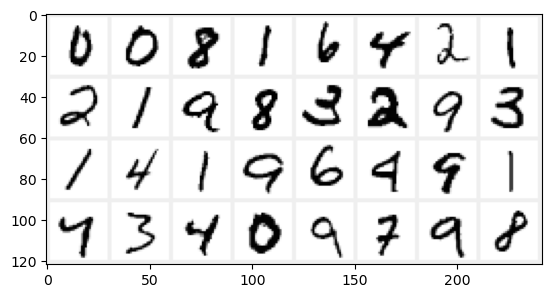

In [13]:
# create grid of images
dataiter = iter(trainloader)
images, labels = dataiter.next()
img_grid = torchvision.utils.make_grid(images[0:32])

print('Data samples')
# show images
imshow(img_grid, one_channel=True)


## Define expert and gate networks

In [14]:
# Convolutional network with one convultional layer and 2 hidden layers with ReLU activation
class expert_layers(nn.Module):
    def __init__(self, num_classes, channels=1):
        super(expert_layers, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=channels, out_channels=1, kernel_size=3)
        self.fc1 = nn.Linear(in_features=1*13*13, out_features=5) # this is a pure linear transform
        self.fc2 = nn.Linear(in_features=5, out_features=32) # this is a pure linear transform
        
        self.out = nn.Linear(in_features=32, out_features=num_classes)
                
    def forward(self, t):
        # conv 1
        t = self.conv1(t)
        # print('conv1', t.shape)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        # print('max pool', t.shape)
        # fc1
        t = t.reshape(-1, 1*13*13)
        t = self.fc1(t)
        t = F.relu(t)

        # fc2
        t = self.fc2(t)
                      
        self.hidden = t
            
        t = F.relu(t)
                
        # output
        t = F.softmax(self.out(t), dim=1) # The temperature parameter is 1 for all the experiments
        
        return t

In [15]:
# Attentive gate
# Convolutional network with one convolutional layer and 2 hidden layers with ReLU activation
class gate_attn_layers(nn.Module):
    def __init__(self, num_experts, channels=1):
        super(gate_attn_layers, self).__init__()
        # define layers
        self.conv1 = nn.Conv2d(in_channels=channels, out_channels=1, kernel_size=3)

        self.fc1 = nn.Linear(in_features=1*13*13, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=32)
                
    def forward(self, t, T=1.0, y=None):
        # conv 1
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        # fc1
        t = t.reshape(-1, 1*13*13)
            
        t = self.fc1(t)
        t = F.relu(t)

        # fc2
        t = self.fc2(t)
        
        return t


In [16]:
# Original gate
# Convolutional network with one convultional layer and 2 hidden layers with ReLU activation
class gate_layers(nn.Module):
    def __init__(self, num_experts, channels=1):
        super(gate_layers, self).__init__()
        # define layers
        self.conv1 = nn.Conv2d(in_channels=channels, out_channels=1, kernel_size=3)

        self.fc1 = nn.Linear(in_features=1*13*13, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=32)
        self.out = nn.Linear(in_features=32, out_features=num_experts)
        self.num_experts = num_experts

    def forward(self, t, T=1.0, y=None):
        # conv 1
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        # fc1
        t = t.reshape(-1, 1*13*13)
            
        t = self.fc1(t)
        t = F.relu(t)

        # fc2
        t = self.fc2(t)
        t = F.relu(t)

        # output
        t = self.out(t)
        t = F.softmax(t/T, dim=1)
        return t


In [17]:
# create a set of experts
def experts(num_experts, num_classes, expert_layers_type=expert_layers, channels=1):
    models = []
    for i in range(num_experts):
        models.append(expert_layers_type(num_classes, channels))
    return nn.ModuleList(models)

## Initialize configurations and helper functions

In [18]:
# Compute accuracy of the model
def accuracy(out, yb, mean=True):
    preds = torch.argmax(out, dim=1).to(device, non_blocking=True)
    if mean:
        return (preds == yb).float().mean()
    else:
        return (preds == yb).float()

## Functions to train models

### Function to train attentive gate model with and without regularization

* w_importance_range is the range of values for the $w_{importance}$ hyperparameter of the $L_{importance}$ regularization.
* w_sample_sim_same_range is the range of values for $\beta_s$ hyperparameter of the $L_s$ regularization.
* w_sample_sim_diff_range is the range of values for $\beta_d$ hyperparameter of the $L_s$ regularization.

In [19]:
def train_with_attention(model_1, model_name, k=0, trainloader=None, testloader=None, runs=1, temps=[[1.0]*20], w_importance_range=[0], 
                         w_sample_sim_same_range=[0.0], w_sample_sim_diff_range=[0.0],
                         num_classes=10, total_experts=5, num_epochs=20, channels=1):
    
    hidden = 32
    
    moe_model_types = {'moe_expectation_model':(moe_expectation_model,cross_entropy_loss().to(device)),
                       'moe_stochastic_model':(moe_stochastic_model, stochastic_loss(cross_entropy_loss).to(device)),
                       'moe_top_1_model':(moe_top_k_model, stochastic_loss(cross_entropy_loss).to(device)),
                       'moe_top_k_model':(moe_top_k_model, cross_entropy_loss().to(device))
                      }
    
    for T, w_importance, w_sample_sim_same, w_sample_sim_diff, in product(temps, w_importance_range,w_sample_sim_same_range,  w_sample_sim_diff_range):
        
        print('w_importance','{:.1f}'.format(w_importance))
        if w_sample_sim_same < 1:
            print('w_sample_sim_same',str(w_sample_sim_same))
        else:
            print('w_sample_sim_same','{:.1f}'.format(w_sample_sim_same))
        
        if w_sample_sim_diff < 1:
            print('w_sample_sim_diff',str(w_sample_sim_diff))
        else:
            print('w_sample_sim_diff','{:.1f}'.format(w_sample_sim_diff))

        n_run_models_1 = []
        for run in range(1,runs+1):

            print('Run:', run), 

            models = {model_name:{'model':moe_model_types[model_name][0],'loss':moe_model_types[model_name][1],
                                               'experts':{}},}
            for key, val in models.items():

                expert_models = experts(total_experts, num_classes, channels=channels)
                
                gate_model = gate_attn_layers(total_experts, channels)

                if k > 0:
                    moe_model = val['model'](k, total_experts, num_classes,
                                             experts=expert_models, gate=gate_model, device=device).to(device)
                else:
                    moe_model = val['model'](total_experts, num_classes,
                                         experts=expert_models, gate=gate_model, device=device).to(device)

                optimizer_moe = optim.Adam(moe_model.parameters(), lr=0.001, amsgrad=False)
                
                optimizer = default_optimizer(optimizer_moe=optimizer_moe)

                hist = moe_model.train(trainloader, testloader,  val['loss'], optimizer = optimizer,
                                       T = T, w_importance=w_importance, 
                                       w_sample_sim_same = w_sample_sim_same, w_sample_sim_diff = w_sample_sim_diff, 
                                       accuracy=accuracy, epochs=num_epochs)
                val['experts'][total_experts] = {'model':moe_model, 'history':hist}
            
            # Save all the trained models
            plot_file = generate_plot_file(model_1, T[0], w_importance=w_importance, 
                                           w_sample_sim_same=w_sample_sim_same,w_sample_sim_diff=w_sample_sim_diff,
                                           specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')
            
            
            if  os.path.exists(os.path.join(model_path, plot_file)):
                n_run_models_1 = torch.load(open(os.path.join(model_path, plot_file),'rb'))
                
            n_run_models_1.append(models)                                
            torch.save(n_run_models_1,open(os.path.join(model_path, plot_file),'wb'))
            n_run_models_1 = []
        print(plot_file)

### Function to distill the attentive gate model to the original model

In [20]:
def train_from_model(m, num_epochs, num_classes, total_experts, w_importance_range=[0.0], w_sample_sim_same_range=[0.0], w_sample_sim_diff_range=[0.0],
                     trainloader=None, testloader=None, expert_no_grad=True, gate_no_grad=False):
    
    T = [1.0]*num_epochs
    for w_importance, w_sample_sim_same, w_sample_sim_diff in product(w_importance_range, w_sample_sim_same_range, w_sample_sim_diff_range):
        
        print('w_importance','{:.1f}'.format(w_importance))
        
        if w_sample_sim_same < 1:
            print('w_sample_sim_same',str(w_sample_sim_same))
        else:
            print('w_sample_sim_same','{:.1f}'.format(w_sample_sim_same))
        
        if w_sample_sim_diff < 1:
            print('w_sample_sim_diff',str(w_sample_sim_diff))
        else:
            print('w_sample_sim_diff','{:.1f}'.format(w_sample_sim_diff))
        
        plot_file = generate_plot_file(m, temp=T[0], w_importance=w_importance,  
                                       w_sample_sim_same=w_sample_sim_same,w_sample_sim_diff=w_sample_sim_diff,
                                       specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')

        attn_models = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)

        n_run_models_1 = []
    
        for model in attn_models: 
            # Initialise the new expert weights to the weights of the experts of the trained attentive gate model.
            # Fix all the weights of the new experts so they are not trained.
            new_expert_models = experts(total_experts, num_classes).to(device)
            old_expert_models = model['moe_expectation_model']['experts'][total_experts]['model'].experts
            for i, expert in enumerate(new_expert_models):
                old_expert = old_expert_models[i]
                expert.load_state_dict(old_expert.state_dict())
                if expert_no_grad:
                    for param in expert.parameters():
                        param.requires_grad = False

            # Initialise the new gate weights to the weights of the gate of the trained attentive gate model.
            new_gate_model = gate_layers(total_experts).to(device)
            old_gate_model = model['moe_expectation_model']['experts'][total_experts]['model'].gate
            new_gate_model.load_state_dict(old_gate_model.state_dict(), strict=False)

            if gate_no_grad:
                for param in new_gate_model.parameters():
                    param.requires_grad = False
                new_gate_model.out = nn.Linear(in_features=32, out_features=num_experts)
                
            gate_model = new_gate_model

            models = {'moe_expectation_model':{'model':moe_expectation_model,'loss':cross_entropy_loss(),
                                           'experts':{}},}

            for key, val in models.items():

                # gate_model = gate_layers(total_experts).to(device)                

                moe_model = val['model'](total_experts, num_classes,
                                         experts=new_expert_models, gate= gate_model).to(device)

                optimizer_moe = optim.Adam(moe_model.parameters(), lr=0.001, amsgrad=False)

                optimizer = default_optimizer(optimizer_moe=optimizer_moe)
                
                hist = moe_model.train(trainloader, testloader,  val['loss'], optimizer = optimizer,
                                       T = T, accuracy=accuracy, epochs=num_epochs)
                val['experts'][total_experts] = {'model':moe_model, 'history':hist}

            plot_file = generate_plot_file('new_'+m, T[0], w_importance=w_importance, w_sample_sim_same=w_sample_sim_same,w_sample_sim_diff=w_sample_sim_diff,
                                           specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')
        
            if os.path.exists(os.path.join(model_path, plot_file)):
                n_run_models_1 = torch.load(open(os.path.join(model_path, plot_file),'rb'))
                
            n_run_models_1.append(models)                                
            torch.save(n_run_models_1,open(os.path.join(model_path, plot_file),'wb'))
            n_run_models_1 = []
            print(plot_file)
            



## Experiments

### Experiment 1: Attentive gate MoE model training

In [21]:
# Model with gate and expert parameters initialized to default values
model_1 = 'mnist_with_attention_hidden_32'

In [22]:
total_experts = 5

In [23]:
num_epochs = 20

In [24]:
runs = 1

In [25]:
train_with_attention(model_1, trainloader, testloader, runs, num_classes=num_classes, total_experts=total_experts, num_epochs=num_epochs)

w_importance 0.0
w_sample_sim_same 0.0
w_sample_sim_diff 0.0
Run: 1
epoch 0 training loss 2.06 , training accuracy 0.41 , test accuracy 0.70
epoch 1 training loss 1.68 , training accuracy 0.82 , test accuracy 0.88
epoch 2 training loss 1.58 , training accuracy 0.90 , test accuracy 0.91
epoch 3 training loss 1.56 , training accuracy 0.91 , test accuracy 0.92
epoch 4 training loss 1.54 , training accuracy 0.92 , test accuracy 0.93
epoch 5 training loss 1.54 , training accuracy 0.93 , test accuracy 0.93
epoch 6 training loss 1.53 , training accuracy 0.93 , test accuracy 0.93
epoch 7 training loss 1.53 , training accuracy 0.94 , test accuracy 0.93
epoch 8 training loss 1.53 , training accuracy 0.94 , test accuracy 0.93
epoch 9 training loss 1.52 , training accuracy 0.94 , test accuracy 0.94
epoch 10 training loss 1.52 , training accuracy 0.94 , test accuracy 0.94
epoch 11 training loss 1.52 , training accuracy 0.95 , test accuracy 0.94
epoch 12 training loss 1.52 , training accuracy 0.95 ,

### Experiment 2: Attentive gate MoE model training with $L_{importance}$ regularization

In [102]:
# Model with gate and expert parameters initialized to default values
model_2 = 'mnist_with_attn_reg_hidden_32'

In [103]:
total_experts = 5

In [104]:
num_epochs = 20

In [115]:
w_importance_range = [i * 0.2 for i in range(1, 6)]
print('w_importance_range = ', ['{:.1f}'.format(w) for w in w_importance_range])

w_importance_range =  ['0.2', '0.4', '0.6', '0.8', '1.0']


In [116]:
runs = 10

In [107]:
train_with_attention(model_2, trainloader, testloader, runs, w_importance_range=w_importance_range, 
                     num_classes=num_classes, total_experts=total_experts, num_epochs=num_epochs)

w_importance 1.0
w_sample_sim_same 0.0
w_sample_sim_diff 0.0
Run: 1
epoch 0 training loss 1.49 , training accuracy 0.55 , test accuracy 0.82
epoch 1 training loss 0.51 , training accuracy 0.87 , test accuracy 0.92
epoch 2 training loss 0.31 , training accuracy 0.92 , test accuracy 0.93
epoch 3 training loss 0.25 , training accuracy 0.93 , test accuracy 0.94
epoch 4 training loss 0.21 , training accuracy 0.94 , test accuracy 0.94
epoch 5 training loss 0.20 , training accuracy 0.95 , test accuracy 0.95
epoch 6 training loss 0.18 , training accuracy 0.95 , test accuracy 0.94
epoch 7 training loss 0.17 , training accuracy 0.95 , test accuracy 0.95
epoch 8 training loss 0.16 , training accuracy 0.96 , test accuracy 0.95
epoch 9 training loss 0.15 , training accuracy 0.96 , test accuracy 0.96
epoch 10 training loss 0.14 , training accuracy 0.96 , test accuracy 0.96
epoch 11 training loss 0.13 , training accuracy 0.96 , test accuracy 0.96
epoch 12 training loss 0.13 , training accuracy 0.97 ,

### Experiment 3: Attentive gate MoE model training with sample similarity $L_s$ regularization

In [108]:
# Model with gate and expert parameters initialized to default values
model_3 = 'mnist_with_attn_sample_sim_reg_hidden_32'

In [109]:
total_experts = 5

In [110]:
num_epochs = 20

In [118]:
w_sample_sim_same_range = [1e-6, 1e-5]
w_sample_sim_diff_range = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1]
print('w_sample_sim_same_range = ', w_sample_sim_same_range)
print('w_sample_sim_diff_range = ', w_sample_sim_diff_range)

w_sample_sim_same_range =  [1e-06, 1e-05]
w_sample_sim_diff_range =  [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1]


In [119]:
runs = 10

In [113]:
train_with_attention(model_3, trainloader, testloader, runs,
                     w_sample_sim_same_range=w_sample_sim_same_range, w_sample_sim_diff_range=w_sample_sim_diff_range, 
                     num_classes=num_classes, total_experts=total_experts, num_epochs=num_epochs)

w_importance 0.0
w_sample_sim_same 1e-06
w_sample_sim_diff 0.1
Run: 1
epoch 0 training loss 1.46 , training accuracy 0.63 , test accuracy 0.89
epoch 1 training loss 0.51 , training accuracy 0.91 , test accuracy 0.93
epoch 2 training loss 0.40 , training accuracy 0.94 , test accuracy 0.94
epoch 3 training loss 0.36 , training accuracy 0.95 , test accuracy 0.95
epoch 4 training loss 0.34 , training accuracy 0.96 , test accuracy 0.95
epoch 5 training loss 0.33 , training accuracy 0.96 , test accuracy 0.96
epoch 6 training loss 0.32 , training accuracy 0.96 , test accuracy 0.96
epoch 7 training loss 0.31 , training accuracy 0.97 , test accuracy 0.96
epoch 8 training loss 0.30 , training accuracy 0.97 , test accuracy 0.97
epoch 9 training loss 0.29 , training accuracy 0.97 , test accuracy 0.96
epoch 10 training loss 0.28 , training accuracy 0.97 , test accuracy 0.97
epoch 11 training loss 0.28 , training accuracy 0.97 , test accuracy 0.97
epoch 12 training loss 0.27 , training accuracy 0.98

### Experiment 4: Distilling attentive gate MoE model

#### Distilling attentive gate MoE model with $L_{importance}$ regularization

In [88]:
m = 'mnist_with_attn_reg_hidden_32'

total_experts = 5
num_classes = 10
num_epochs = 20

w_importance_range = [i * 0.2 for i in range(1, 6)]
print('w_importance_range = ', ['{:.1f}'.format(w) for w in w_importance_range])

train_from_model(m, num_epochs, num_classes, total_experts, w_importance_range=w_importance_range, trainloader=trainloader, testloader=testloader)

w_importance 0.2
w_sample_sim_same 0.0
w_sample_sim_diff 0.0
epoch 0 training loss 0.59 , training accuracy 0.83 , test accuracy 0.90
epoch 1 training loss 0.26 , training accuracy 0.92 , test accuracy 0.93
epoch 2 training loss 0.22 , training accuracy 0.93 , test accuracy 0.94
epoch 3 training loss 0.20 , training accuracy 0.94 , test accuracy 0.94
epoch 4 training loss 0.19 , training accuracy 0.94 , test accuracy 0.94
epoch 5 training loss 0.18 , training accuracy 0.95 , test accuracy 0.94
epoch 6 training loss 0.17 , training accuracy 0.95 , test accuracy 0.95
epoch 7 training loss 0.16 , training accuracy 0.95 , test accuracy 0.94
epoch 8 training loss 0.16 , training accuracy 0.95 , test accuracy 0.95
epoch 9 training loss 0.15 , training accuracy 0.95 , test accuracy 0.95
epoch 10 training loss 0.15 , training accuracy 0.96 , test accuracy 0.95
epoch 11 training loss 0.15 , training accuracy 0.96 , test accuracy 0.95
epoch 12 training loss 0.14 , training accuracy 0.96 , test a

#### Distilling attentive gate MoE model with $L_{s}$ regularization

In [89]:
m = 'mnist_with_attn_sample_sim_reg_hidden_32'

total_experts = 5
num_classes = 10
num_epochs = 20

w_sample_sim_same_range = [1e-6, 1e-5]
w_sample_sim_diff_range = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1]
print('w_sample_sim_same_range = ', w_sample_sim_same_range)
print('w_sample_sim_diff_range = ', w_sample_sim_diff_range)

train_from_model(m, num_epochs, num_classes, total_experts, w_sample_sim_same_range=w_sample_sim_same_range, w_sample_sim_diff_range=w_sample_sim_diff_range,
                 trainloader=trainloader, testloader=testloader)

w_importance 0.0
w_sample_sim_same 1e-06
w_sample_sim_diff 1e-06
epoch 0 training loss 0.74 , training accuracy 0.79 , test accuracy 0.89
epoch 1 training loss 0.33 , training accuracy 0.90 , test accuracy 0.91
epoch 2 training loss 0.26 , training accuracy 0.92 , test accuracy 0.92
epoch 3 training loss 0.23 , training accuracy 0.93 , test accuracy 0.93
epoch 4 training loss 0.20 , training accuracy 0.94 , test accuracy 0.94
epoch 5 training loss 0.19 , training accuracy 0.95 , test accuracy 0.94
epoch 6 training loss 0.18 , training accuracy 0.95 , test accuracy 0.94
epoch 7 training loss 0.17 , training accuracy 0.95 , test accuracy 0.95
epoch 8 training loss 0.16 , training accuracy 0.95 , test accuracy 0.95
epoch 9 training loss 0.15 , training accuracy 0.96 , test accuracy 0.95
epoch 10 training loss 0.15 , training accuracy 0.96 , test accuracy 0.95
epoch 11 training loss 0.14 , training accuracy 0.96 , test accuracy 0.95
epoch 12 training loss 0.14 , training accuracy 0.96 , te

## Results

### Collect the train error, test error, mutual information $I(E;Y)$, sample entropy $H_s$ and expert usage entropy $H_u$ for all the models trained with MNIST dataset. Store the reuslts in the '../results/mnist_results.csv' file.

In [21]:
import csv
from helper import moe_models

def collect_results(m, model_name, temps=[1.0], w_importance_range=[0.0], w_ortho_range=[0.0], 
                    w_sample_sim_same_range=[0.0], w_sample_sim_diff_range=[0.0],
                    total_experts=5, num_classes=10, num_epochs=20, 
                    testloader=None, model_path=None, results_path=None, filename='mnist_results.csv'):
    
    filename = os.path.join(results_path, filename)
    
    if os.path.exists(filename):
        p = 'a'
    else:
        p = 'w'
        
    header = ['filename', 'train error', 'test error','mutual information', 'sample entropy', 'experts usage']
    
    with open(filename, p) as f:
                
        writer = csv.writer(f)        
        
        if p == 'w':            
            writer.writerow(header)
        
        for w_importance, w_sample_sim_same, w_sample_sim_diff in product(w_importance_range, w_sample_sim_same_range, w_sample_sim_diff_range):
            plot_file = generate_plot_file(m, w_importance=w_importance, w_sample_sim_same=w_sample_sim_same, w_sample_sim_diff=w_sample_sim_diff, 
                                           specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')

            models = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)
            for _ in range(len(models)):
                mod = models.pop()
                data = [plot_file]    
                # model
                model = mod[model_name]['experts'][total_experts]['model']
                # history
                history = mod[model_name]['experts'][total_experts]['history']
                # train error
                data.append(1-history['accuracy'][-1].item())
                
                running_test_accuracy = 0.0
                running_entropy = 0.0
                num_batches = 0
                
                # initialise the count matrix C for computing mutual information
                ey =  torch.zeros((num_classes, total_experts)).to(device)
                for test_inputs, test_labels in testloader:
                    test_inputs, test_labels = test_inputs.to(device, non_blocking=True), test_labels.to(device, non_blocking=True)                
                    outputs = model(test_inputs)
                    running_test_accuracy += accuracy(outputs, test_labels)
                    
                    selected_experts = torch.argmax(model.gate_outputs, dim=1)
                    y = test_labels
                    e = selected_experts
                    for j in range(y.shape[0]):
                        ey[int(torch.argmax(model.expert_outputs[j,e[j],:])), int(e[j])] += 1

                    running_entropy += moe_models.entropy(model.gate_outputs)
                    
                    num_batches+=1
                     
                mutual_EY,_,_,_ = moe_models.mutual_information(ey.detach())
    
                test_error = 1-(running_test_accuracy/num_batches)
                data.append(test_error.item())
                data.append(mutual_EY.item())
                
                data.append(running_entropy.item()/num_batches)
                gate_probabilities_sum = torch.mean(model.gate_outputs, dim=0).detach().cpu().numpy()             
                data.append(entropy(gate_probabilities_sum).item())
                
                writer.writerow(data)
            
            

In [22]:
import csv
from helper import moe_models
from scipy.stats import entropy


def collect_loss_gate_results(m, model_type='moe_expectation_model', temps=[1.0], w_importance_range=[0.0], 
                    w_sample_sim_same_range=[0.0], w_sample_sim_diff_range=[0.0],
                    total_experts=5, num_classes=10, num_epochs=20, 
                    testloader=None, model_path=None, results_path=None, filename ='mnist_results.csv' ):
    
    filename = os.path.join(results_path, filename)
    
    if os.path.exists(filename):
        p = 'a'
    else:
        p = 'w'
        
    header = ['filename', 'train error', 'test error','mutual information', 'sample entropy', 'experts usage']
    
    with open(filename, p) as f:
                
        writer = csv.writer(f)        
        
        if p == 'w':            
            writer.writerow(header)
        
        for w_importance, w_sample_sim_same, w_sample_sim_diff in product(w_importance_range, w_sample_sim_same_range, w_sample_sim_diff_range):
            plot_file = generate_plot_file(m, w_importance=w_importance, w_sample_sim_same=w_sample_sim_same, w_sample_sim_diff=w_sample_sim_diff, 
                                               specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')

            models = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)
            for _ in range(len(models)):
                mod = models.pop()
                data = [plot_file]
                # model
                model = mod[model_type]['experts'][total_experts]['model']
                # history
                history = mod[model_type]['experts'][total_experts]['history']
                # train error
                data.append(1-history['accuracy'][-1].item())
                running_top1_accuracy = 0.0
                running_entropy = 0.0
                num_batches = 0
                ey =  torch.zeros((num_classes, total_experts)).to(device)
                for test_inputs, test_labels in testloader:
                    test_inputs, test_labels = test_inputs.to(device, non_blocking=True), test_labels.to(device, non_blocking=True)                
                    outputs = model(test_inputs)
                    expert_outputs = model.expert_outputs
                    gate_outputs = F.softmax(model.gate_outputs, dim=1)
                    running_top1_accuracy += accuracy(outputs, test_labels)
                    
                    selected_experts = torch.argmax(gate_outputs, dim=1)
                    y = test_labels
                    e = selected_experts
                    for j in range(y.shape[0]):
                        ey[int(torch.argmax(expert_outputs[j,e[j],:])), int(e[j])] += 1

                    running_entropy += np.mean(entropy(gate_outputs.detach().cpu().numpy()))
                    
                    num_batches+=1
 
                mutual_EY,_,_,_ = moe_models.mutual_information(ey.detach())
    
                top1_error = 1-(running_top1_accuracy/num_batches)
                
                data.append(top1_error.item())
                data.append(mutual_EY.item())
                
                data.append(running_entropy.item()/num_batches)  
                gate_probabilities_sum = torch.mean(gate_outputs, dim=0).detach().cpu().numpy()   
                data.append(entropy(gate_probabilities_sum).item())
                
                writer.writerow(data)
            
            

#### Collect results for all the trained models

In [23]:
import sys
sys.path.append('../src/mnist')

In [24]:
total_experts = 10
num_classes = 10
num_epochs = 100

In [23]:
filename = 'mnist_top_k_results.csv'

In [25]:
for k in range(1, 3):
    m = 'mnist_without_reg_rand_init_top_'+str(k)
    collect_results(m, 'moe_top_k_model', total_experts=total_experts, num_classes=num_classes, num_epochs=num_epochs, 
                    testloader=testloader, model_path=model_path, results_path=results_path, filename=filename)

device cuda:0
Image shape torch.Size([1, 28, 28])
Train samples  60000
Test samples  10000


In [26]:
for k in range(1, 3):
    m = 'mnist_with_attention_rand_init_top_'+str(k)
    collect_results(m, 'moe_top_k_model', total_experts=total_experts, num_classes=num_classes, num_epochs=num_epochs, 
                    testloader=testloader, model_path=model_path, results_path=results_path, filename=filename)

In [27]:
m = 'mnist_without_reg_rand_init'
collect_results(m, 'moe_expectation_model', total_experts=total_experts, num_classes=num_classes, num_epochs=num_epochs, 
                    testloader=testloader, model_path=model_path, results_path=results_path, filename=filename)

In [28]:
m = 'mnist_without_reg_loss_gate_rand_init'
collect_loss_gate_results(m, 'moe_expert_loss_model', total_experts=total_experts, num_classes=num_classes, num_epochs=num_epochs, 
                    testloader=testloader, model_path=model_path, results_path=results_path, filename=filename)

In [ ]:
m = 'mnist_with_attention_rand_init'
collect_results(m, 'moe_expectation_model', total_experts=total_experts, num_classes=num_classes, num_epochs=num_epochs, 
                    testloader=testloader, model_path=model_path, results_path=results_path, filename=filename)

In [24]:
m = 'mnist_importance_rand_init'
w_importance_range = [i * 0.2 for i in range(1, 6)]
collect_results(m, 'moe_expectation_model', w_importance_range=w_importance_range,
                total_experts=total_experts, num_classes=num_classes, num_epochs=num_epochs, 
                testloader=testloader, model_path=model_path, results_path=results_path, filename=filename)

device cuda:0
Image shape torch.Size([1, 28, 28])
Train samples  60000
Test samples  10000


In [25]:
m = 'mnist_with_attn_importance_rand_init'
w_importance_range = [i * 0.2 for i in range(1, 6)]
collect_results(m, 'moe_expectation_model', w_importance_range=w_importance_range,
                total_experts=total_experts, num_classes=num_classes, num_epochs=num_epochs, 
                testloader=testloader, model_path=model_path, results_path=results_path, filename=filename)

In [27]:
m = 'mnist_importance_rand_init_top_2'
w_importance_range = [i * 0.2 for i in range(1, 6)]
collect_results(m, 'moe_top_k_model',w_importance_range=w_importance_range,
                total_experts=total_experts, num_classes=num_classes, num_epochs=num_epochs, 
                testloader=testloader, model_path=model_path, results_path=results_path, filename=filename)

In [28]:
m = 'mnist_with_attn_importance_rand_init_top_2'
w_importance_range = [i * 0.2 for i in range(1, 6)]
collect_results(m, 'moe_top_k_model', w_importance_range=w_importance_range,
                total_experts=total_experts, num_classes=num_classes, num_epochs=num_epochs, 
                testloader=testloader, model_path=model_path, results_path=results_path, filename=filename)

In [ ]:
m = 'mnist_sample_sim_rand_init'
w_sample_sim_same_range = [1e-6, 1e-5]
w_sample_sim_diff_range = [1e-6, 1e-5,1e-4,1e-3,1e-2,1e-1]
collect_results(m, 'moe_expectation_model', w_sample_sim_same_range=w_sample_sim_same_range,
                w_sample_sim_diff_range=w_sample_sim_diff_range,
                total_experts=total_experts, num_classes=num_classes, num_epochs=num_epochs, 
                testloader=testloader, model_path=model_path, results_path=results_path, filename=filename)

In [ ]:
m = 'mnist_with_attn_sample_sim_rand_init'
w_sample_sim_same_range = [1e-6, 1e-5]
w_sample_sim_diff_range = [1e-6, 1e-5,1e-4,1e-3,1e-2,1e-1]
collect_results(m, 'moe_expectation_model', w_sample_sim_same_range=w_sample_sim_same_range, 
                w_sample_sim_diff_range=w_sample_sim_diff_range,
                total_experts=total_experts, num_classes=num_classes, num_epochs=num_epochs, 
                testloader=testloader, model_path=model_path, results_path=results_path, filename=filename)

In [30]:
m = 'mnist_sample_sim_rand_init_top_2'
w_sample_sim_same_range = [1e-6, 1e-5]
w_sample_sim_diff_range = [1e-6, 1e-5,1e-4,1e-3,1e-2,1e-1]
collect_results(m, 'moe_top_k_model', w_sample_sim_same_range=w_sample_sim_same_range,
                w_sample_sim_diff_range=w_sample_sim_diff_range,
                total_experts=total_experts, num_classes=num_classes, num_epochs=num_epochs, 
                testloader=testloader, model_path=model_path, results_path=results_path, filename=filename)

In [31]:
m = 'mnist_with_attn_sample_sim_rand_init_top_2'
w_sample_sim_same_range = [1e-6, 1e-5]
w_sample_sim_diff_range = [1e-6, 1e-5,1e-4,1e-3,1e-2,1e-1]
collect_results(m, 'moe_top_k_model', w_sample_sim_same_range=w_sample_sim_same_range,
                w_sample_sim_diff_range=w_sample_sim_diff_range,
                total_experts=total_experts, num_classes=num_classes, num_epochs=num_epochs, 
                testloader=testloader, model_path=model_path, results_path=results_path, filename=filename)

### Final results

#### These are the final performance results, reported in the paper, on the test data for the model with the minimum training error for each category of MoE model and training method.

In [50]:
import pandas as pd
filename = os.path.join(results_path, 'mnist_top_k_results.csv')
data = pd.read_csv(filename)

In [51]:
final_results_filename = os.path.join(results_path, 'mnist_top_k_final_results.csv')

In [54]:
models = ['mnist_without_reg_rand_init_10'] + \
         ['mnist_with_attention_rand_init_10'] + \
         ['mnist_without_reg_rand_init_top_'+str(k) for k in range(1, 3)] + \
         ['mnist_with_attention_rand_init_top_'+str(k) for k in range(1,3)] + \
         ['mnist_without_reg_loss_gate_rand_init', 
          'mnist_importance_rand_init_importance', 'mnist_with_attn_importance_rand_init_importance',
          'mnist_importance_rand_init_top_2', 'mnist_with_attn_importance_rand_init_top_2',
          'mnist_sample_sim_rand_init_sample', 'mnist_with_attn_sample_sim_rand_init_sample',
          'mnist_sample_sim_rand_init_top_2', 'mnist_with_attn_sample_sim_rand_init_top_2'
         ]
header = True
for i, m in enumerate(models):
    if i:
        header = False
    # select model with the minimum train error
    # print(data['filename'].str.startswith(m), 'FILENAME', data['filename'],'MMM',m,'\n\n')
    # print('FILENAME:',data[data['filename'].str.startswith(m)], m)
    model_data = data[data['filename'].str.startswith(m)]
    if model_data.empty:
        continue
    else:   
        row = data.loc[[data[data['filename'].str.startswith(m)]['train error'].idxmin()]]
        row['train error'] = (1-row['train error'])*100
        row['test error'] = (1-row['test error'])*100   
    
    # compute the std of test error over the 10 runs
    std = '{:.3f}'.format(data[data['filename'].str.startswith(m)]['test error'].std())
    row['val error std'] = std
    row.to_csv(final_results_filename, mode='a', header=header, index=False, float_format='%.3f')

In [49]:
models = ['mnist_without_reg_rand_init_10'] + \
         ['mnist_with_attention_rand_init_10'] + \
         ['mnist_without_reg_rand_init_top_'+str(k) for k in range(1, 3)] + \
         ['mnist_with_attention_rand_init_top_'+str(k) for k in range(1,3)] + \
         ['mnist_without_reg_loss_gate_rand_init', 
          'mnist_importance_rand_init_importance', 'mnist_with_attn_importance_rand_init_importance',
          'mnist_importance_rand_init_top_2', 'mnist_with_attn_importance_rand_init_top_2',
          'mnist_sample_sim_rand_init_sample', 'mnist_with_attn_sample_sim_rand_init_sample',
          'mnist_sample_sim_rand_init_top_2', 'mnist_with_attn_sample_sim_rand_init_top_2'
         ]

header = True
df = None
std = ['{:.3f}'.format(std_val) for std_val in data.groupby('filename')['test error'].std().values]
print(std)
data = data.groupby('filename').mean().reset_index()
for i, m in enumerate(models):
    model_data = data[data['filename'].str.startswith(m)]
    if model_data.empty:
        continue
    if i:
        header = False
    index = model_data.index.values[0]
    series = model_data.mean(numeric_only=True)
    row = pd.DataFrame([series.values], columns=series.index)
    row['train error'] = (1-row['train error'])*100
    row['test error'] = (1-row['test error'])*100   
    row.insert(2, 'test error std', std[index])
    row.insert(0, 'filename' , model_data['filename'].iloc[0])
    if df is None:
        df = row
    else:
        df = pd.concat([df, row])
header = ['filename', 'train error', 'test error', 'test error std', 'mutual information', 'sample entropy', 'experts usage']
    
df.to_csv(final_results_filename,mode='a',header=header, index=False, float_format='%.3f')

['0.004', '0.010', '0.010', '0.014', '0.008', '0.006', '0.007', '0.005', '0.006', '0.002', '0.008', '0.004', '0.007', '0.007', '0.008', '0.006', '0.010', '0.006', '0.008', '0.008', '0.011', '0.007', '0.008', '0.068', '0.005', '0.004', '0.005', '0.003', '0.003', '0.004', '0.004', '0.004', '0.004', '0.003', '0.004', '0.005', '0.003', '0.005', '0.004', '0.003', '0.004', '0.003', '0.004', '0.006', '0.005', '0.003', '0.005', '0.015', '0.019', '0.003', '0.011']


In [55]:
# display final results
data = pd.read_csv(final_results_filename)
data.fillna('NA', inplace=True)
data

filename  train error  \
0         mnist_without_reg_rand_init_10_10_models.pt         96.9   
1      mnist_with_attention_rand_init_10_10_models.pt         98.4   
2   mnist_without_reg_rand_init_top_1_10_10_models.pt         91.2   
3   mnist_without_reg_rand_init_top_2_10_10_models.pt         98.3   
4   mnist_with_attention_rand_init_top_1_10_10_mod...         91.7   
5   mnist_with_attention_rand_init_top_2_10_10_mod...         99.5   
6   mnist_without_reg_loss_gate_rand_init_10_10_mo...         95.7   
7   mnist_importance_rand_init_importance_0.6_10_1...         99.0   
8   mnist_with_attn_importance_rand_init_importanc...         99.1   
9   mnist_importance_rand_init_top_2_importance_0....         99.6   
10  mnist_with_attn_importance_rand_init_top_2_imp...         99.9   
11  mnist_sample_sim_rand_init_top_2_sample_sim_sa...         99.1   
12  mnist_with_attn_sample_sim_rand_init_top_2_sam...         99.9   

    test error  mutual information  sample entropy  experts usage  \
0         95.4               1.536           0.034          1.067   
1         96.1               2.259           0.007          1.676   
2         91.1               0.000           0.001          0.001   
3         96.8               2.179           0.035          1.517   
4         91.3               0.000           0.000          0.000   
5         97.2               2.407           0.018          1.781   
6         94.5               1.340           8.308          2.176   
7         97.9               3.272           0.058          2.301   
8         97.5               3.319           0.007          2.301   
9         97.8               3.277           0.058          2.302   
10        97.6               3.215           0.019          2.301   
11        97.2               2.468           0.043          1.711   
12        97.6               2.876           0.014          2.034   

   val error std  
0             NA  
1             NA  
2             NA  
3             NA  
4             NA  
5             NA  
6             NA  
7             NA  
8             NA  
9             NA  
10            NA  
11            NA  
12            NA

In [51]:
# display final results
data = pd.read_csv(final_results_filename)
data.fillna('NA', inplace=True)
data

filename  train error  test error  \
0            mnist_without_reg_10_10_models.pt       91.031      90.731   
1  mnist_without_reg_inf_top_1_10_10_models.pt       90.941      90.934   
2  mnist_without_reg_inf_top_2_10_10_models.pt       91.600      91.561   
3   mnist_with_attention_top_1_10_10_models.pt       89.439      89.309   
4   mnist_with_attention_top_2_10_10_models.pt       96.097      94.835   
5         mnist_with_attention_10_10_models.pt       95.784      94.607   
6  mnist_without_reg_loss_gate_10_10_models.pt       91.294      90.953   

   test error std  mutual information  sample entropy  experts usage  
0           0.002               0.000           0.105          0.073  
1           0.006               0.000           0.109          0.076  
2           0.005               0.000           0.822          0.570  
3           0.029               0.000           0.000          0.000  
4           0.004               1.420           0.077          1.142  
5           0.005               1.996           0.006          1.481  
6           0.003              -0.000           9.211          1.740

In [55]:
# display final results
data = pd.read_csv(final_results_filename)
data.fillna('NA', inplace=True)
data

filename  train error  test error  \
0             mnist_without_reg_10_10_models.pt       91.674      91.373   
1   mnist_without_reg_inf_top_1_10_10_models.pt       89.817      89.727   
2   mnist_without_reg_inf_top_2_10_10_models.pt       94.714      94.095   
3   mnist_without_reg_inf_top_3_10_10_models.pt       96.174      95.532   
4   mnist_without_reg_inf_top_4_10_10_models.pt       95.265      94.540   
5   mnist_without_reg_inf_top_5_10_10_models.pt       96.086      95.253   
6   mnist_without_reg_inf_top_6_10_10_models.pt       96.091      95.400   
7   mnist_without_reg_inf_top_7_10_10_models.pt       95.846      95.147   
8   mnist_without_reg_inf_top_8_10_10_models.pt       96.209      95.439   
9   mnist_without_reg_inf_top_9_10_10_models.pt       96.621      95.742   
10   mnist_with_attention_top_1_10_10_models.pt       88.541      88.096   
11   mnist_with_attention_top_2_10_10_models.pt       97.285      95.913   
12         mnist_with_attention_10_10_models.pt       93.540      92.812   
13  mnist_without_reg_loss_gate_10_10_models.pt       90.220      90.001   

    test error std  mutual information  sample entropy  experts usage  
0            0.021               0.585           0.018          0.599  
1            0.007               0.123           0.000          0.848  
2            0.019               1.138           0.055          1.167  
3            0.010               1.664           0.118          1.787  
4            0.018               1.276           0.108          1.404  
5            0.017               1.539           0.103          1.664  
6            0.011               1.671           0.135          1.839  
7            0.012               1.391           0.136          1.606  
8            0.007               1.634           0.126          1.826  
9            0.009               1.686           0.119          1.862  
10           0.075               0.750           0.000          2.023  
11           0.006               1.843           0.046          1.982  
12           0.038               1.768           0.014          1.809  
13           0.011               0.270           8.907          1.809

In [25]:
total_experts = 10
num_classes = 10
num_epochs = 100

In [26]:
def show_results(m, model_type, model_path=None):
    classes = range(num_classes)
    test_loader = testloader

    # plot_file = generate_plot_file(m, specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')

    # mod = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)
    
    mod, model_file = find_best_model(m, w_importance_range=[0.0], num_classes=num_classes, total_experts=total_experts, 
                                        num_epochs=num_epochs, model_path=model_path, device=device)
    
    # model
    model = mod[model_type]['experts'][total_experts]['model']
    for test_inputs, test_labels in testloader:
        test_inputs, test_labels = test_inputs.to(device, non_blocking=True), test_labels.to(device, non_blocking=True)                
        outputs = model(test_inputs)
        
        print('test error', 1-accuracy(outputs,test_labels))
        expert_outputs = model.expert_outputs
        gate_outputs = model.gate_outputs
        
        expected_expert_outputs = expert_outputs[torch.arange(expert_outputs.shape[0]).type_as(test_labels),:, test_labels]
        eps=1e-15
        e_logp =torch.log(expected_expert_outputs+eps)
        print('expert log loss:\n', e_logp[0:5])
        print('expert log loss predicted by gate:\n', gate_outputs[0:5])
        
        selected_experts = torch.argmax(gate_outputs, dim=1)
        
        class_expert_table = np.asarray([[0] * num_classes]*total_experts)
        for label, expert in zip(test_labels, selected_experts):
            class_expert_table[expert,label] += 1

        fig1,ax = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(24, 15))
        cmap = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)
        sns.heatmap(class_expert_table, yticklabels=['E'+str(i) for i in range(1,total_experts+1)], 
                    xticklabels=[classes[i] for i in range(0, num_classes)],
                    annot=True, cmap=cmap, fmt='d', ax=ax)

        plt.title('Experts selected per digit for '+str(len(test_loader))+' samples of\n MNIST test data', 
                  fontsize=12)
        
        pred_labels = torch.argmax(outputs, dim=1)
        fig1,ax = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(16, 8))
        cmap = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)
        sns.heatmap(confusion_matrix(test_labels.cpu(), pred_labels.cpu()), 
                    xticklabels=[classes[i] for i in range(0, num_classes)],
                    yticklabels=[classes[i] for i in range(0, num_classes)], 
                    annot=True, cmap=cmap, fmt='d', ax=ax)
        plt.title('Moe predictions')
        plt.show()


        exp_class_prob = torch.zeros(total_experts, num_classes).to(device)

        for e in range(total_experts):
            for index, l in enumerate(test_labels):
                exp_class_prob[e,l] += gate_outputs[index,e]


        exp_total_prob = torch.sum(exp_class_prob, dim=1).view(-1,1).to(device)
        fig,ax = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(16,8))

        sns.heatmap(exp_class_prob.detach().cpu().numpy(), yticklabels=['E'+str(i) for i in range(1,total_experts+1)], 
                            xticklabels=[classes[i] for i in range(0, num_classes)],
                            cmap=cmap, annot=True,  ax=ax)
        plt.title('Experts selected per digit for '+str(len(test_loader))+' samples of\n MNIST test data', 
                  fontsize=12)

        for i in range(total_experts):
            expert_output = expert_outputs[torch.arange(expert_outputs.shape[0]),i]
            pred_labels = torch.argmax(expert_output, dim=1)
            # print(test_labels[0:100])
            # print(pred_labels[0:100])
            fig1,ax = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(16, 8))
            cmap = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)
            sns.heatmap(confusion_matrix(test_labels.cpu(), pred_labels.cpu()), 
                        xticklabels=[classes[i] for i in range(0, num_classes)],
                        yticklabels=[classes[i] for i in range(0, num_classes)], 
                        annot=True, cmap=cmap, fmt='d', ax=ax)
            plt.title('Expert %d predictions'%(i+1))
            plt.show()


device cuda:0
Image shape torch.Size([1, 28, 28])
Train samples  60000
Test samples  10000
mnist_with_attention_top_1_10_10_models.pt
Min Training Error 0.081
Mutual Information 1.211
Sample Entropy 0.000
Expert Usage 2.792
mnist_with_attention_top_1_10_10_models.pt


<Figure size 640x480 with 0 Axes>

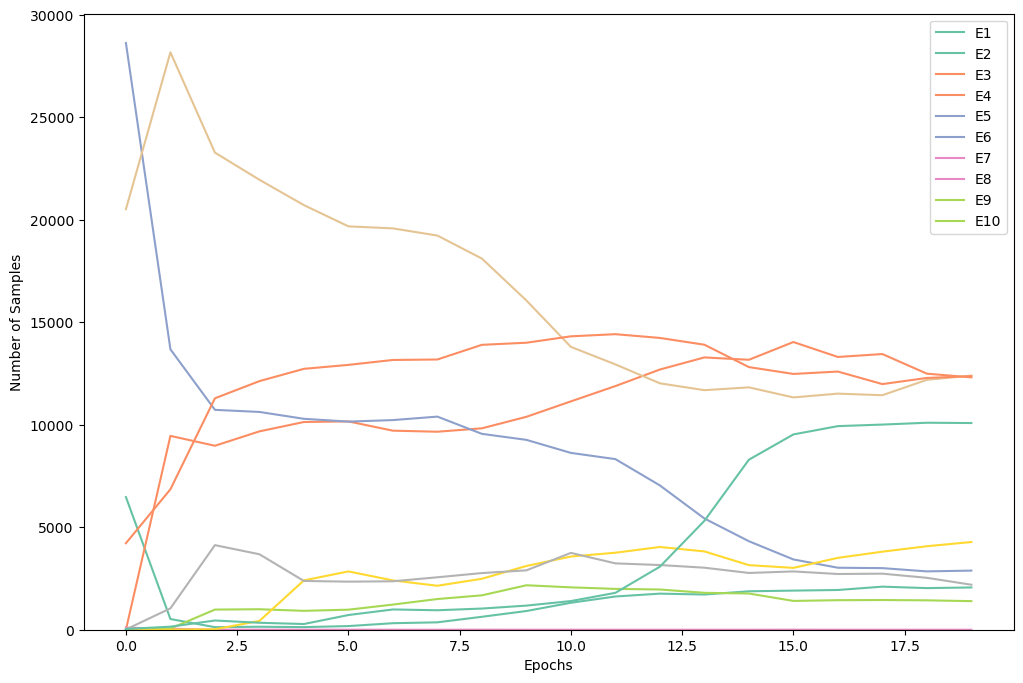

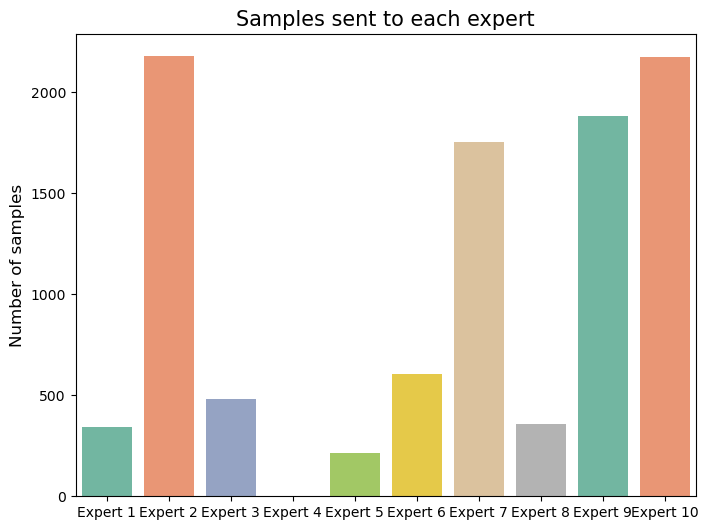

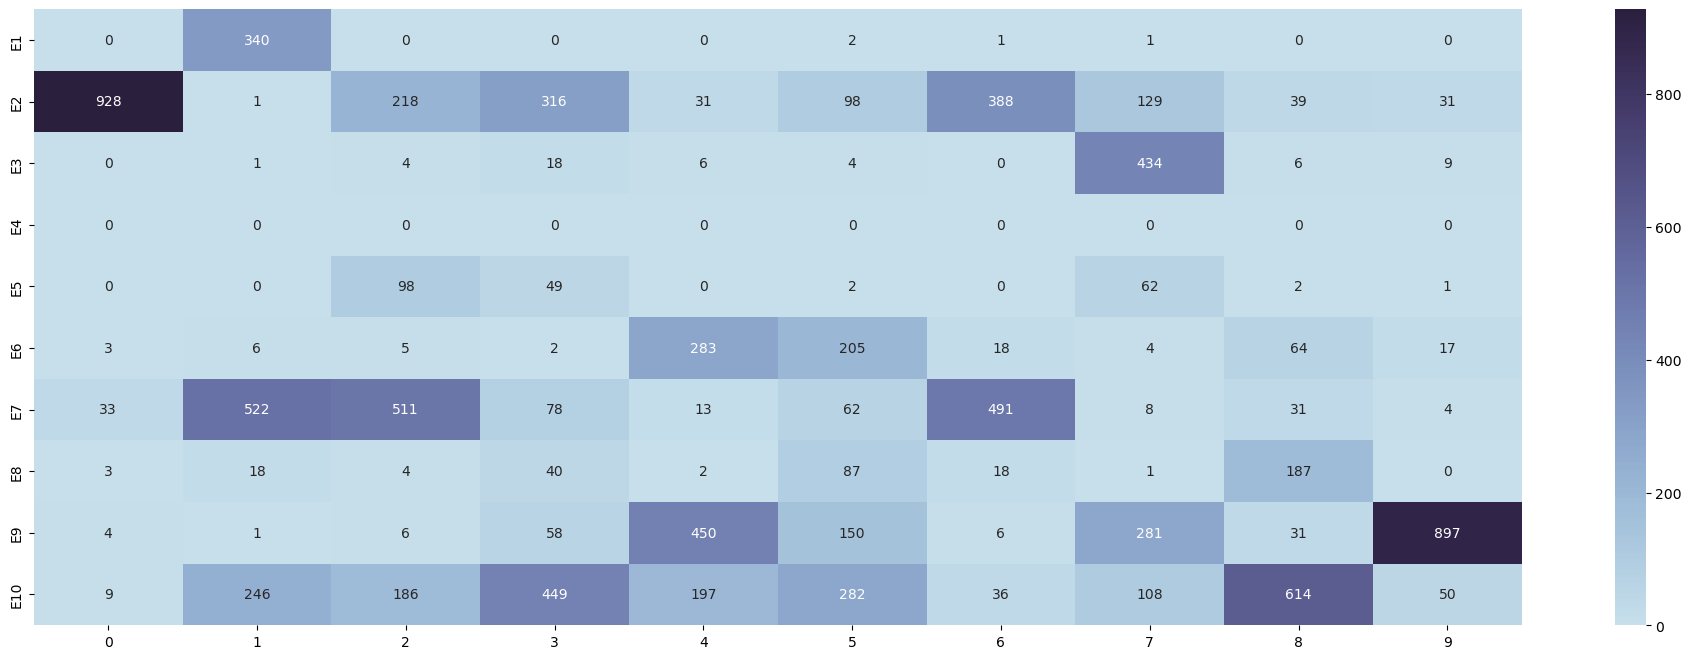


Experts used by the gate for classification of each class


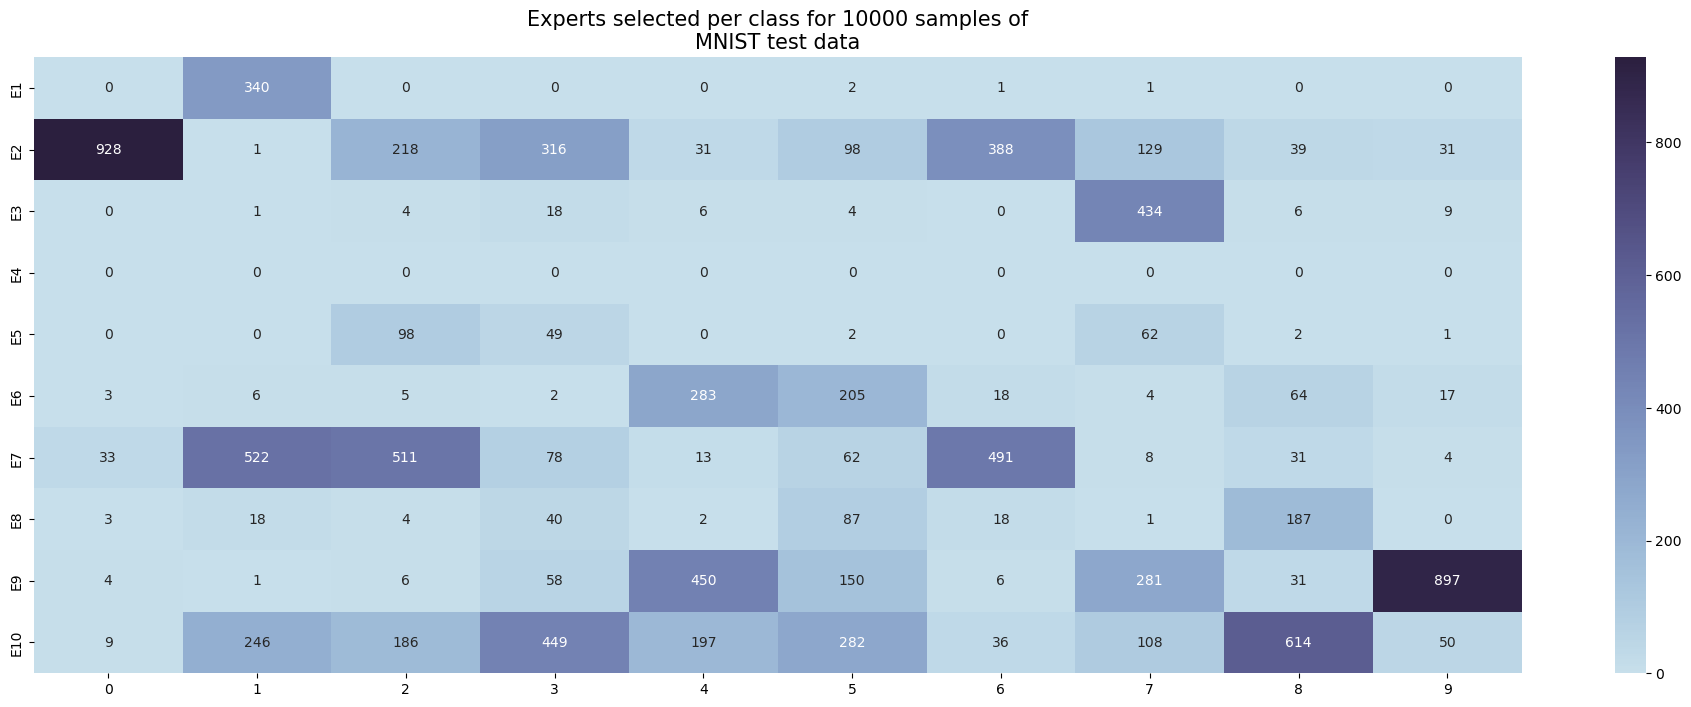

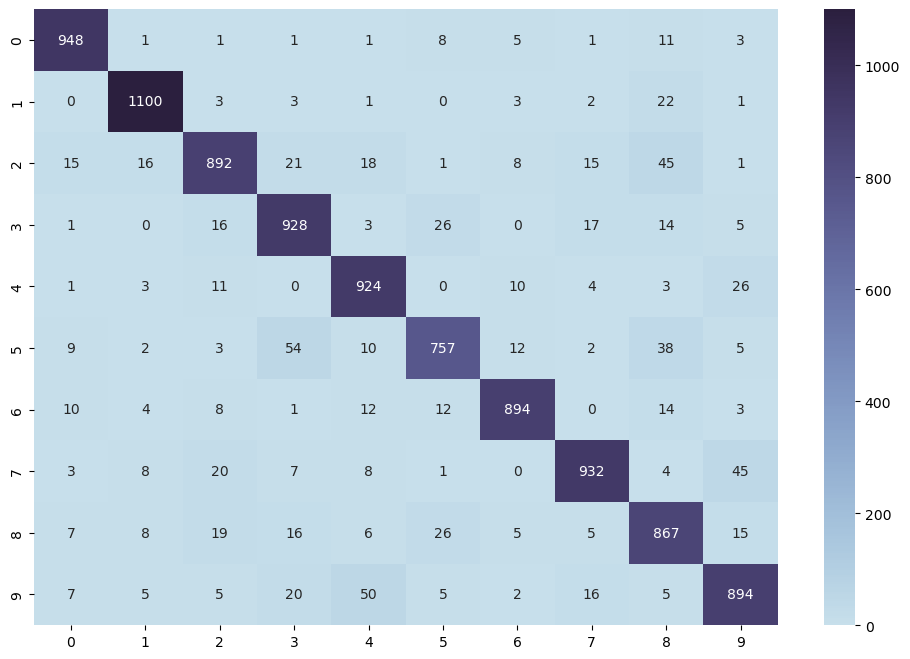

In [35]:
m = 'mnist_with_attention_top_1'
total_experts = 10
num_classes = 10
classes = range(10)
num_epochs = 20

w_importance_range = [0.0]
test_loader = testloader

plot_expert_usage(m, test_loader,w_importance_range=w_importance_range,
                  total_experts=total_experts,num_classes=num_classes,
                 classes=classes, num_epochs=num_epochs, fig_path=fig_path,
                  model_path=model_path, device=device)

mnist_with_attention_top_2_10_10_models.pt
Min Training Error 0.017
Mutual Information 2.486
Sample Entropy 0.041
Expert Usage 2.616
mnist_with_attention_top_2_10_10_models.pt


<Figure size 640x480 with 0 Axes>

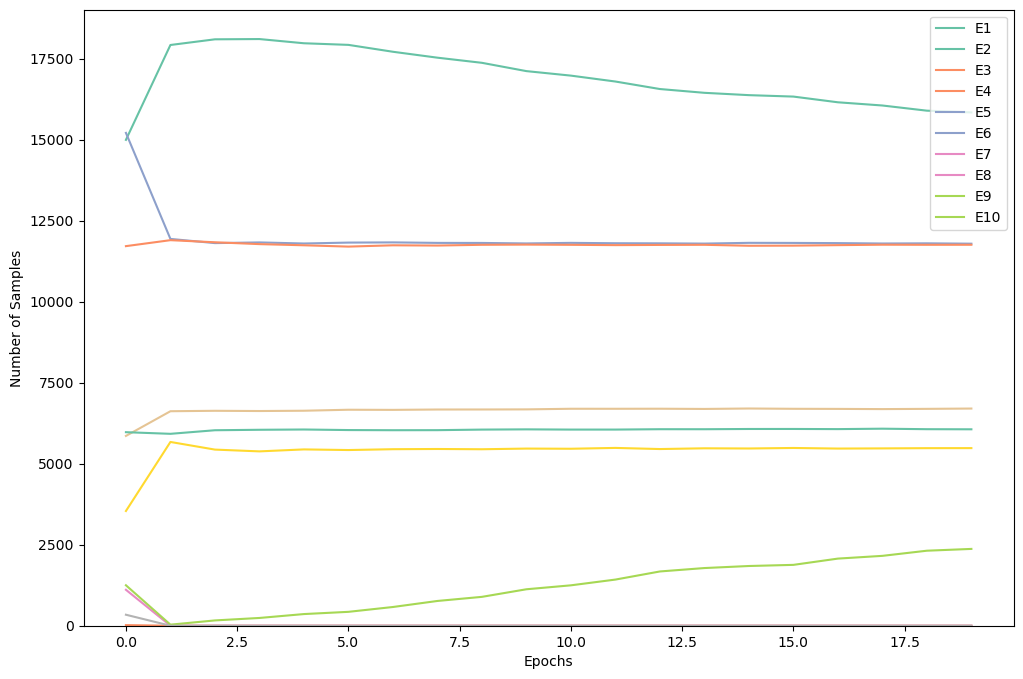

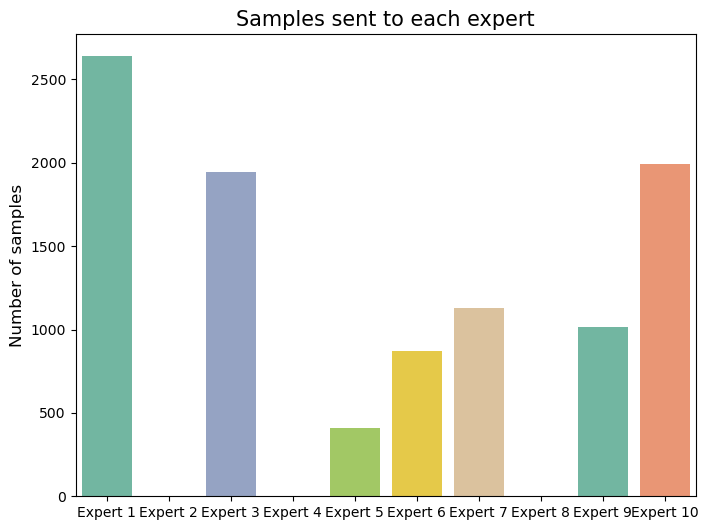

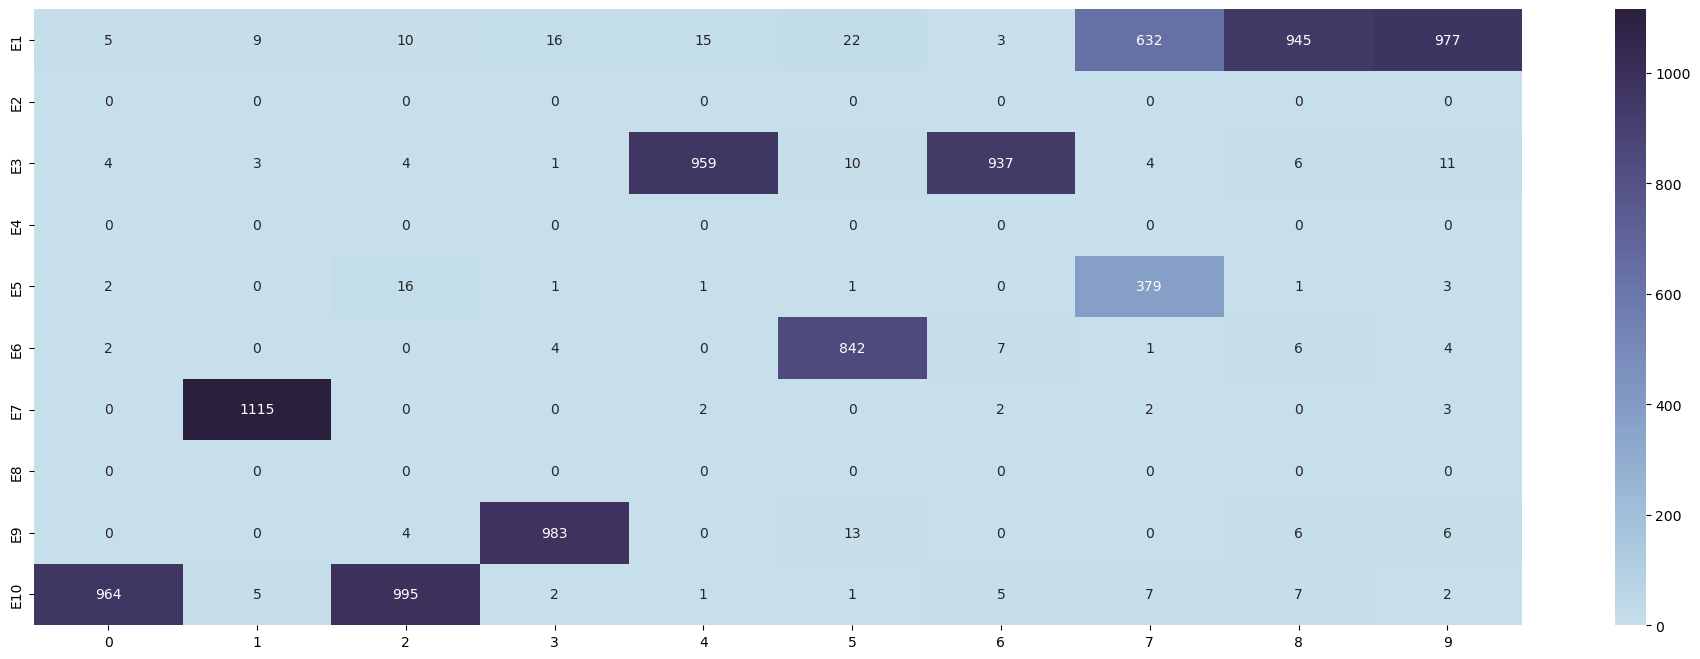


Experts used by the gate for classification of each class


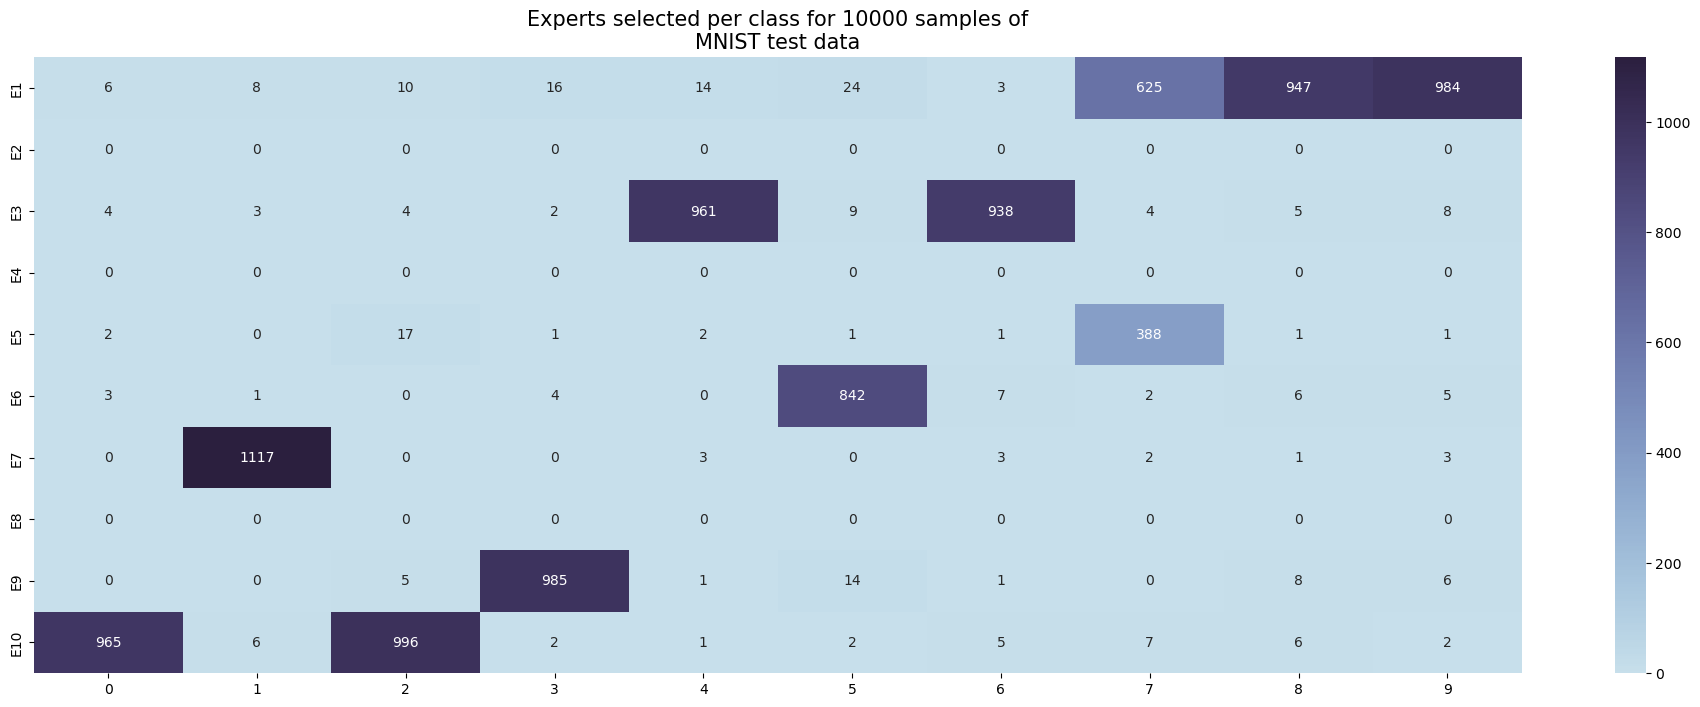

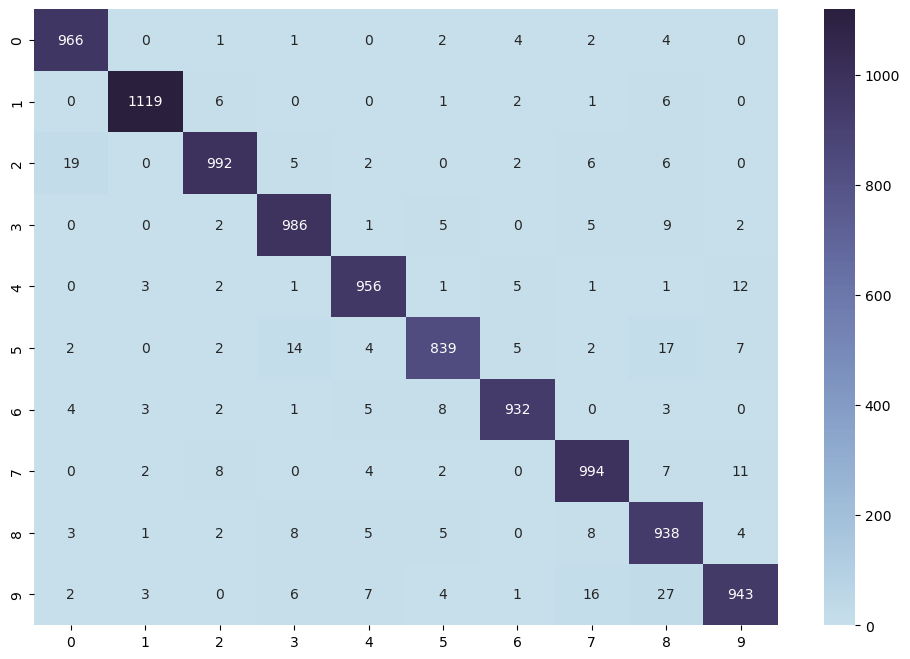

In [36]:
m = 'mnist_with_attention_top_2'
total_experts = 10
num_classes = 10
classes = range(10)
num_epochs = 20

w_importance_range = [0.0]
test_loader = testloader

plot_expert_usage(m, test_loader,w_importance_range=w_importance_range,
                  total_experts=total_experts,num_classes=num_classes,
                 classes=classes, num_epochs=num_epochs, fig_path=fig_path,
                  model_path=model_path, device=device)

mnist_without_reg_inf_top_2_10_10_models.pt
Min Training Error 0.024
Mutual Information 1.961
Sample Entropy 0.052
Expert Usage 1.969
mnist_without_reg_inf_top_2_10_10_models.pt


<Figure size 640x480 with 0 Axes>

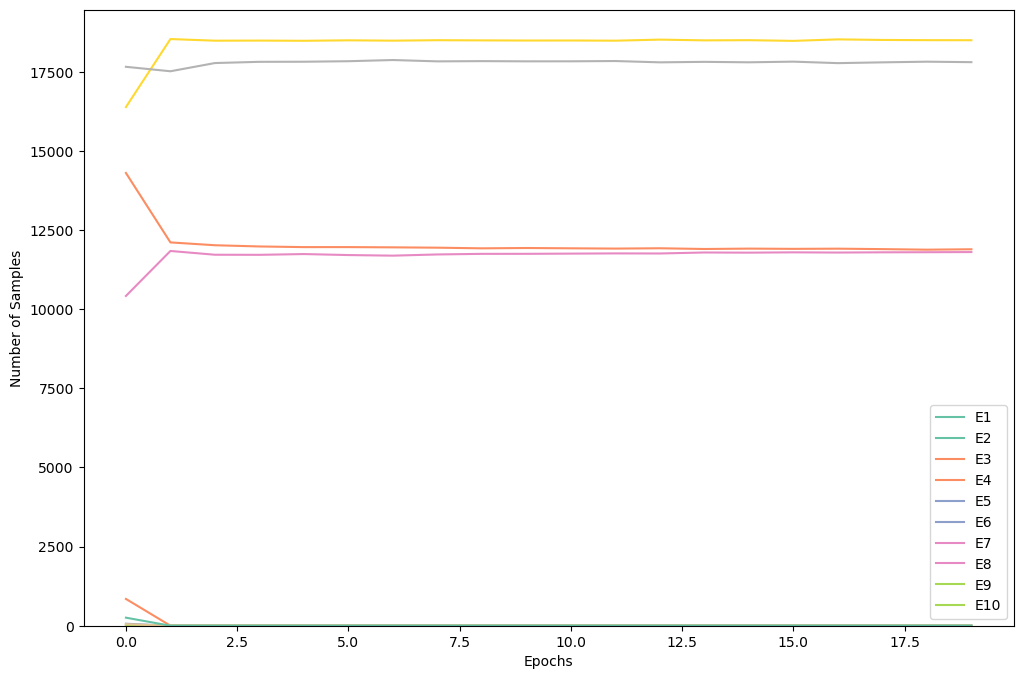

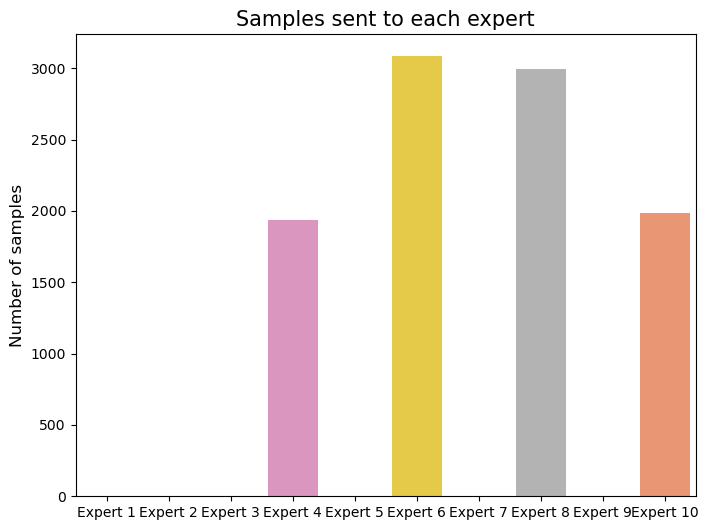

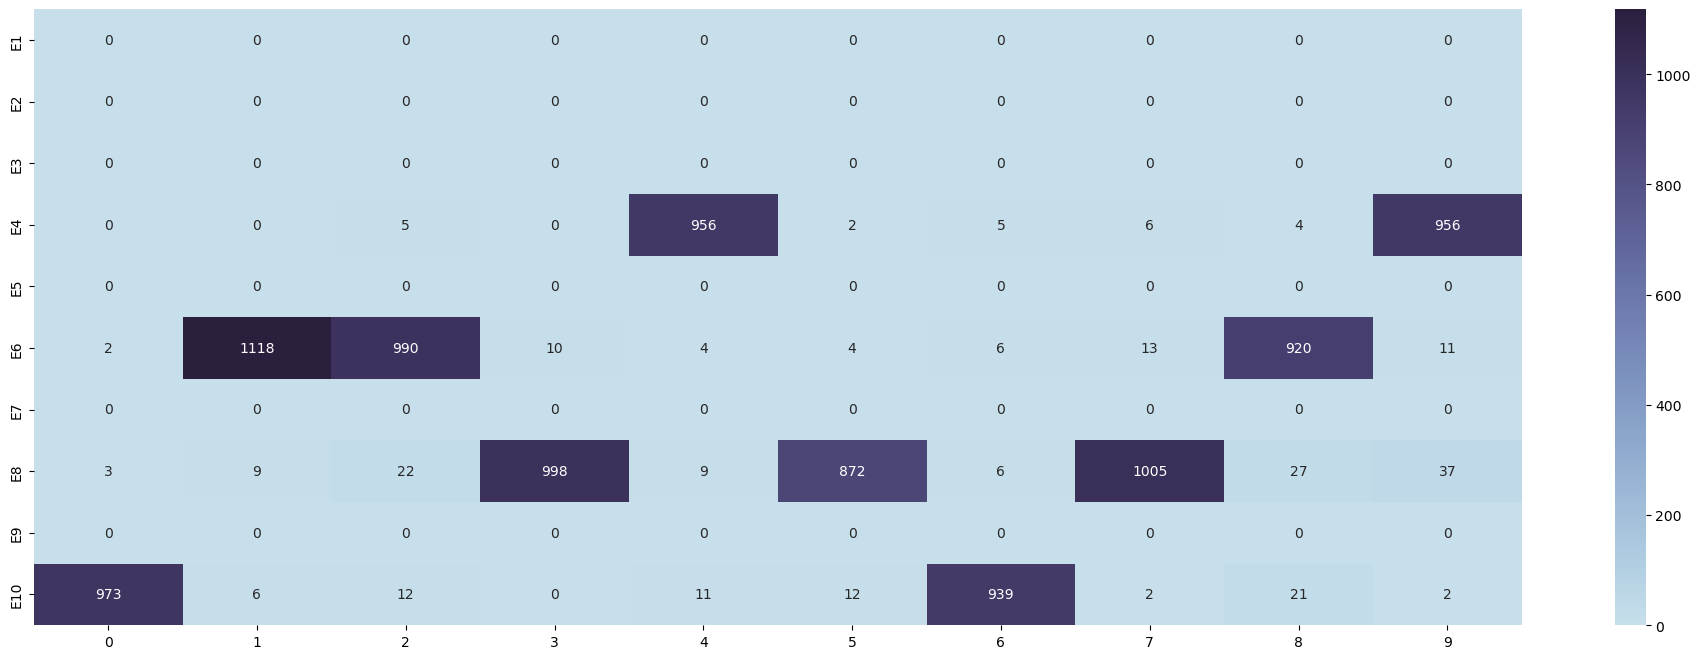


Experts used by the gate for classification of each class


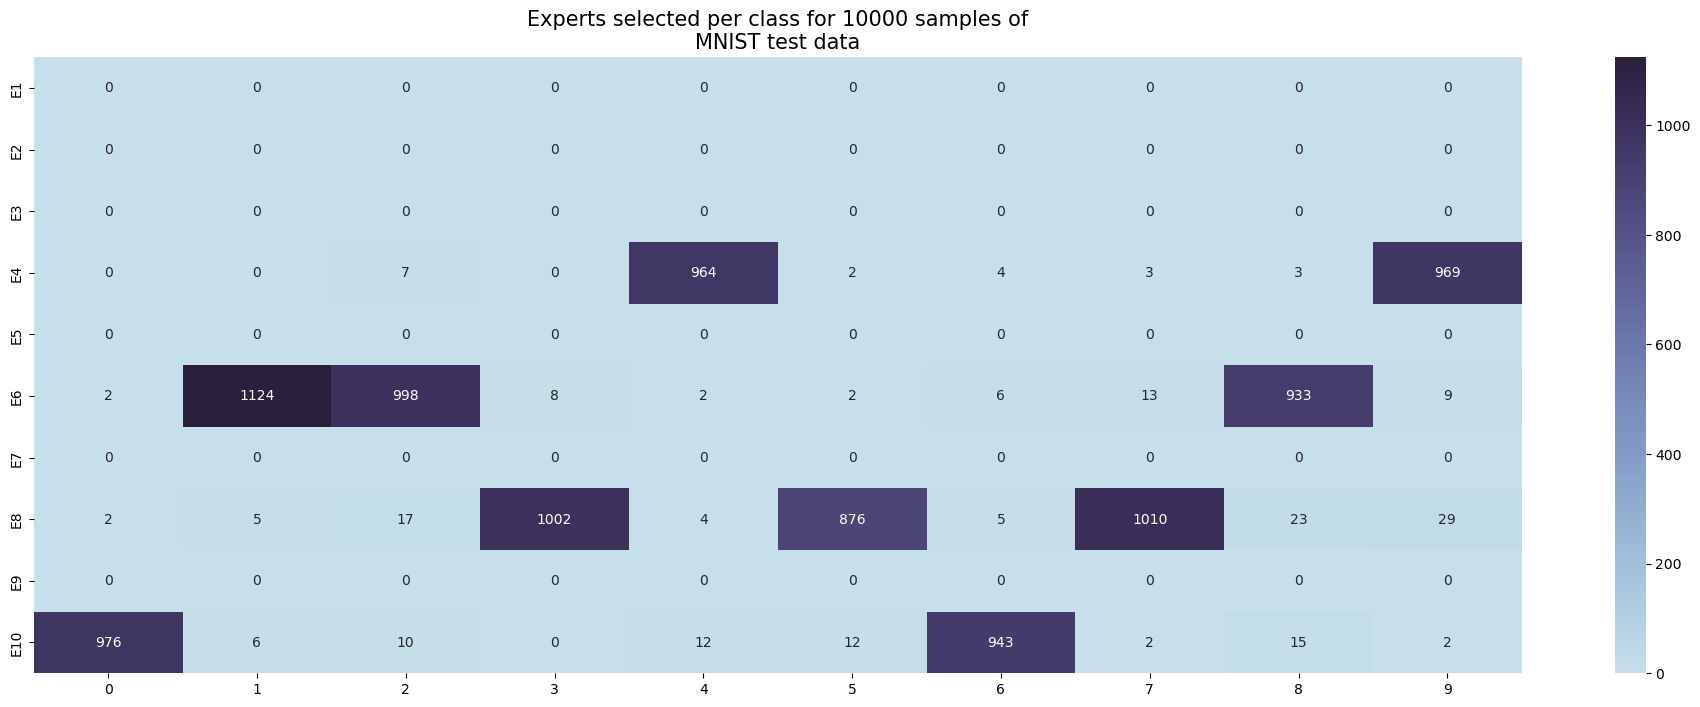

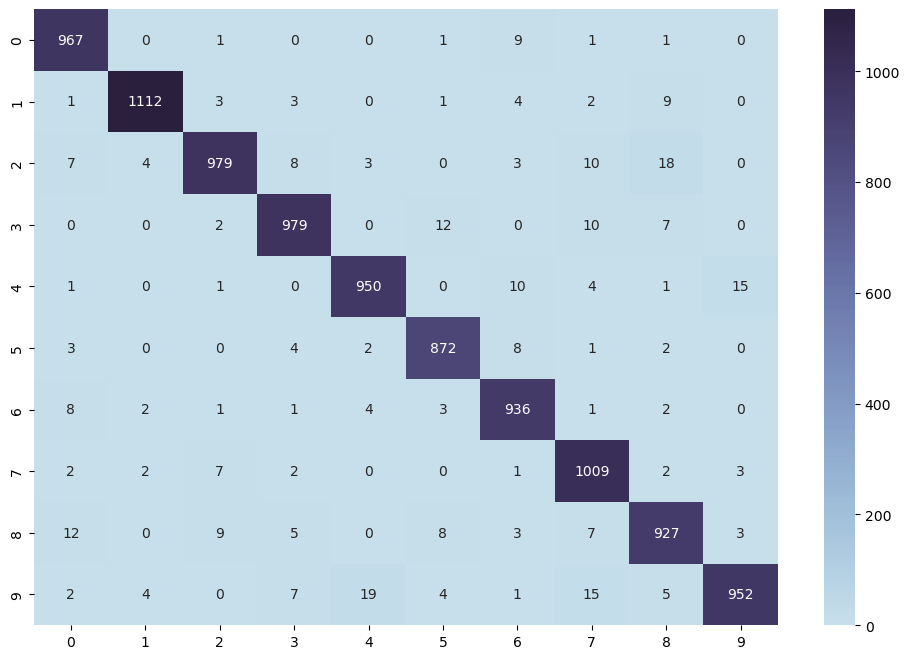

In [37]:
m = 'mnist_without_reg_rand_init_top_2'
total_experts = 10
num_classes = 10
classes = range(10)
num_epochs = 20

w_importance_range = [0.0]
test_loader = testloader

plot_expert_usage(m, test_loader,w_importance_range=w_importance_range,
                  total_experts=total_experts,num_classes=num_classes,
                 classes=classes, num_epochs=num_epochs, fig_path=fig_path,
                  model_path=model_path, device=device)

mnist_with_attn_importance_rand_init_top_2_importance_0.2_10_10_models.pt
Min Training Error 0.001
Mutual Information 3.157
Sample Entropy 0.014
Expert Usage 3.320
mnist_with_attn_importance_rand_init_top_2_importance_0.2_10_10_models.pt


<Figure size 640x480 with 0 Axes>

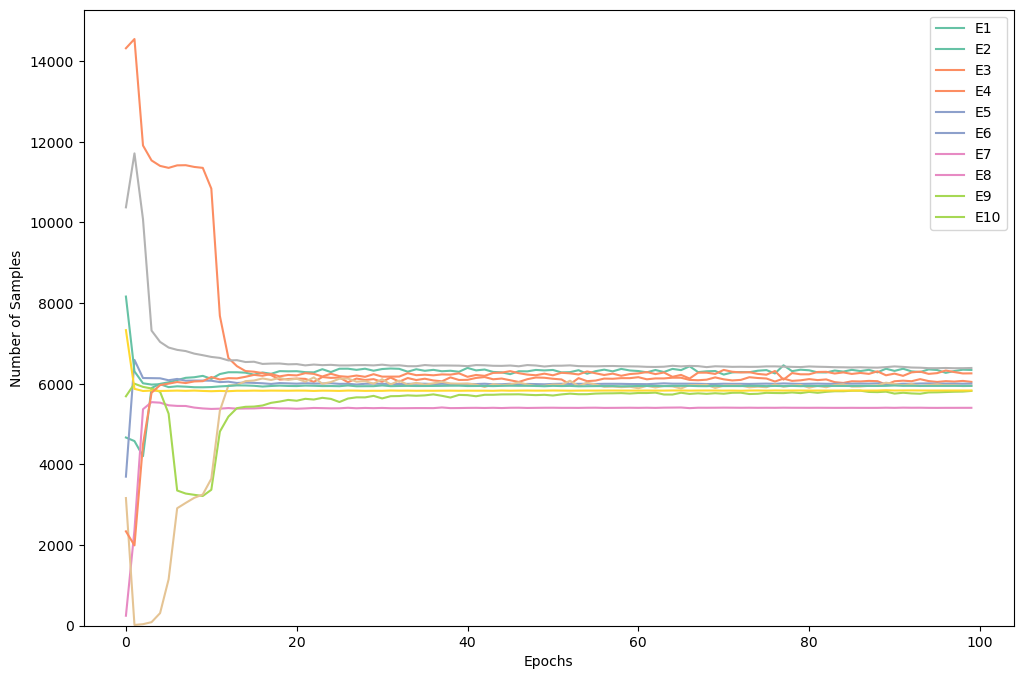

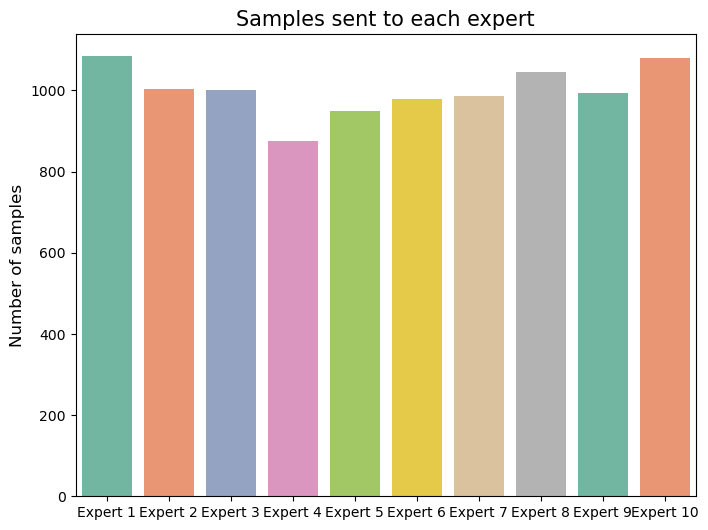

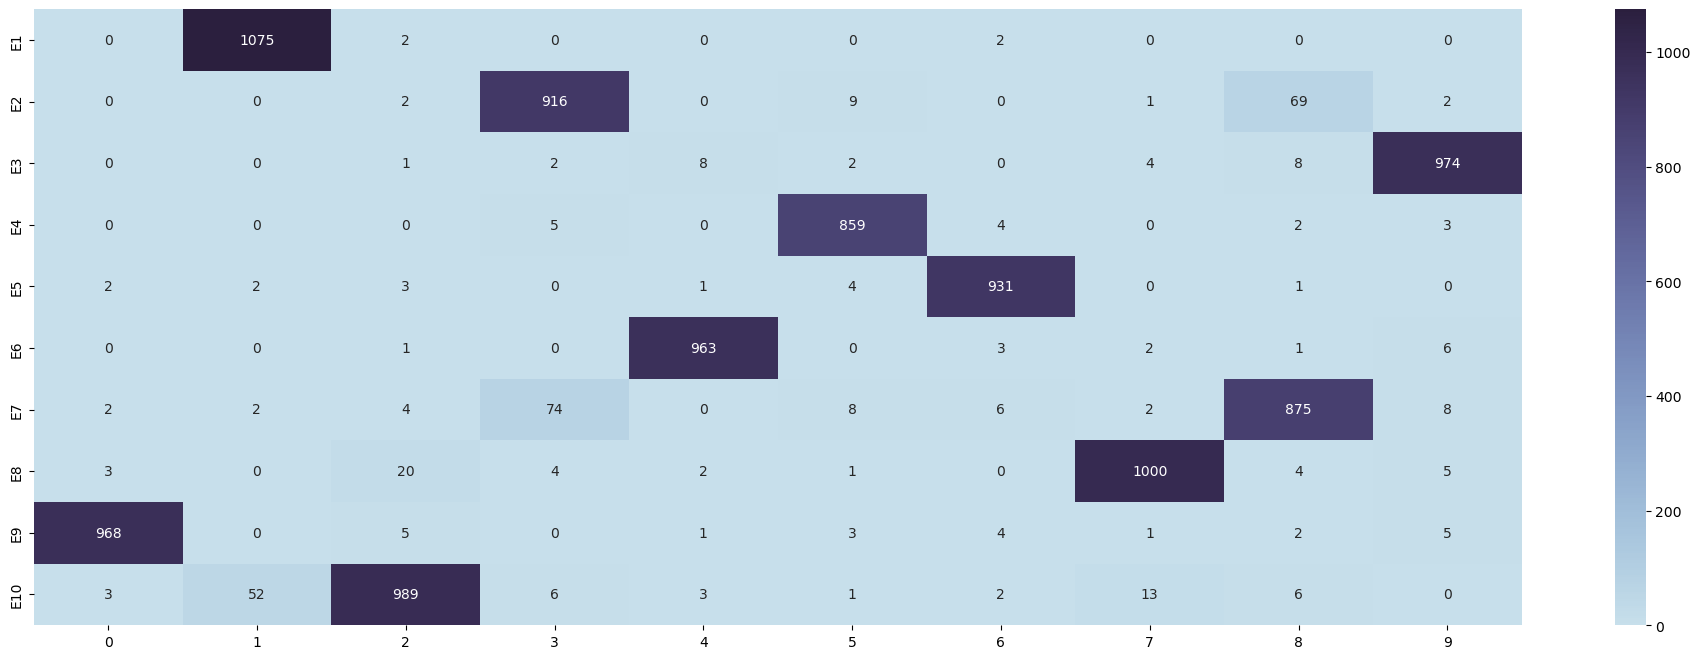


Experts used by the gate for classification of each class


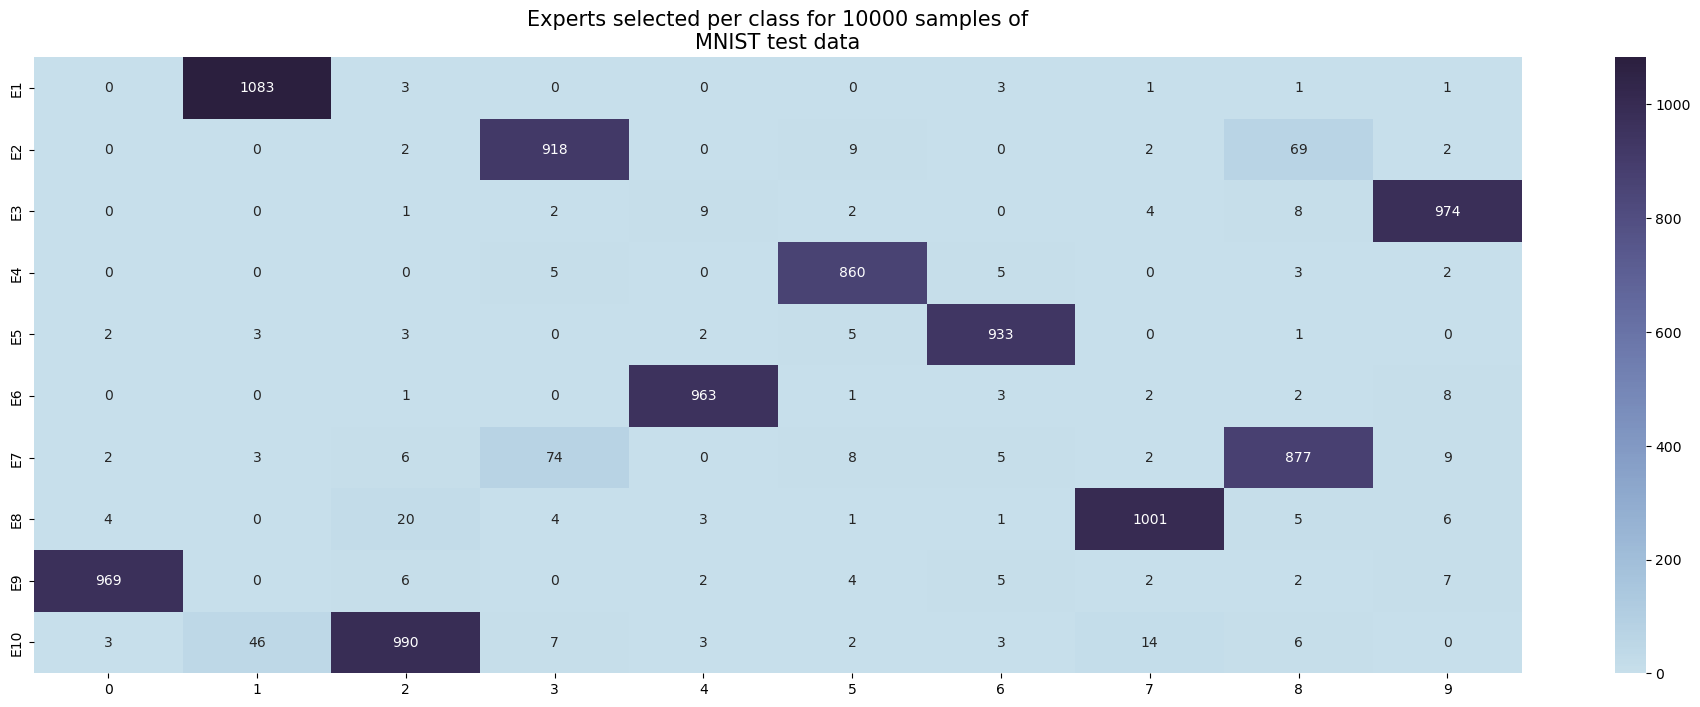

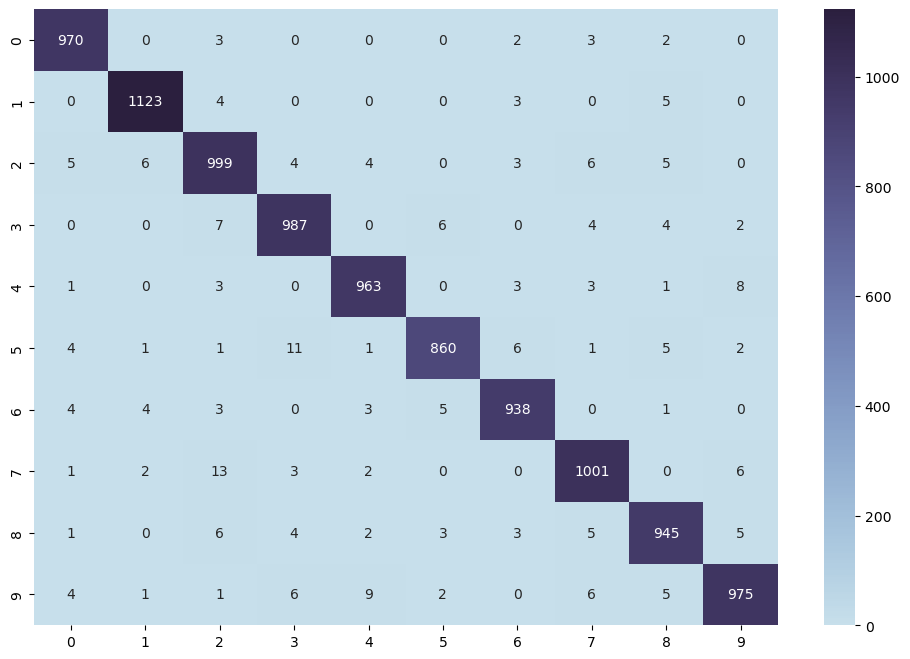

In [28]:
m = 'mnist_with_attn_importance_rand_init_top_2'
total_experts = 10
num_classes = 10
classes = range(10)
num_epochs = 100

w_importance_range = [0.2]
test_loader = testloader

plot_expert_usage(m, test_loader,w_importance_range=w_importance_range,
                  total_experts=total_experts,num_classes=num_classes,
                 classes=classes, num_epochs=num_epochs, fig_path=fig_path,
                  model_path=model_path, device=device)

device cuda:0
Image shape torch.Size([1, 28, 28])
Train samples  60000
Test samples  10000
mnist_importance_rand_init_top_2_importance_0.2_10_10_models.pt
Min Training Error 0.006
Mutual Information 2.847
Sample Entropy 0.049
Expert Usage 2.956
mnist_importance_rand_init_top_2_importance_0.2_10_10_models.pt


<Figure size 640x480 with 0 Axes>

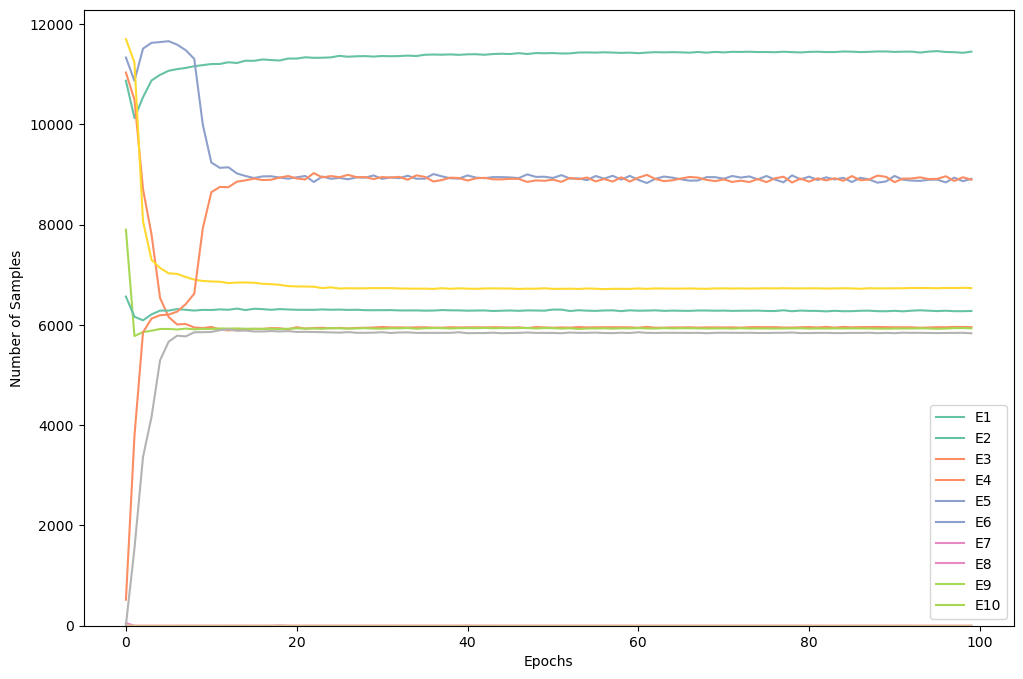

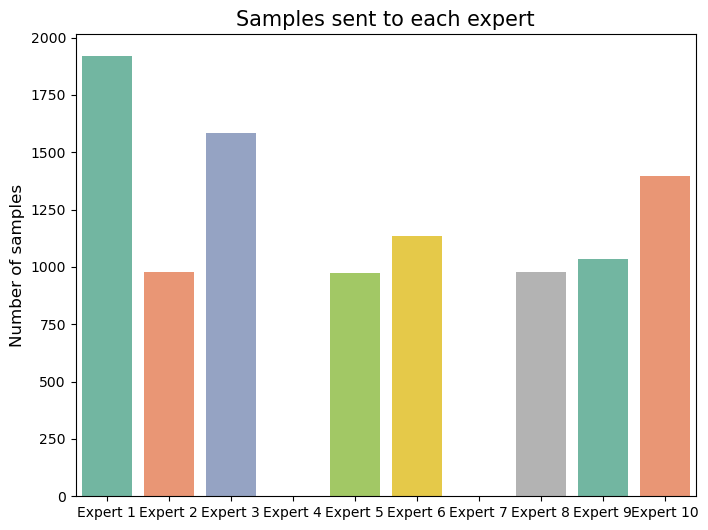

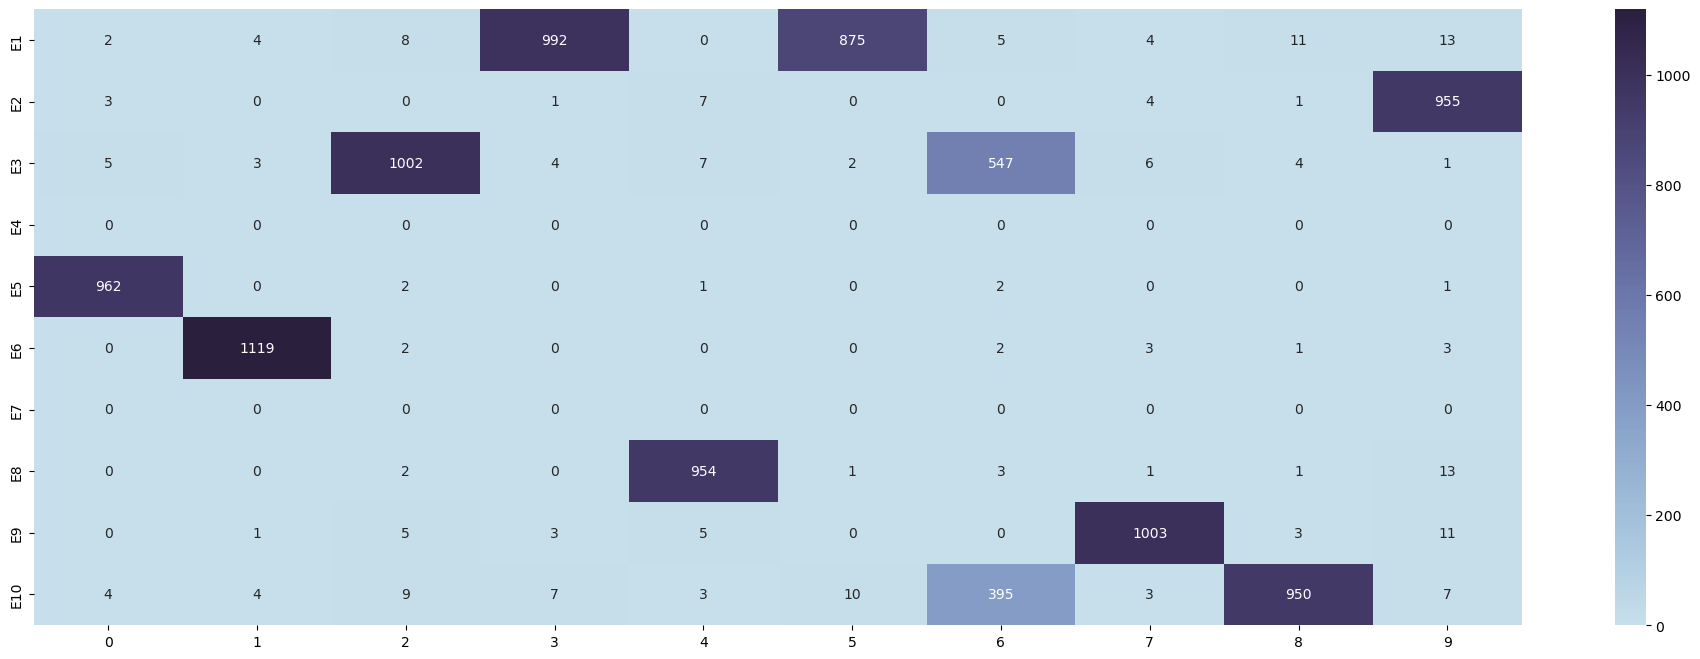


Experts used by the gate for classification of each class


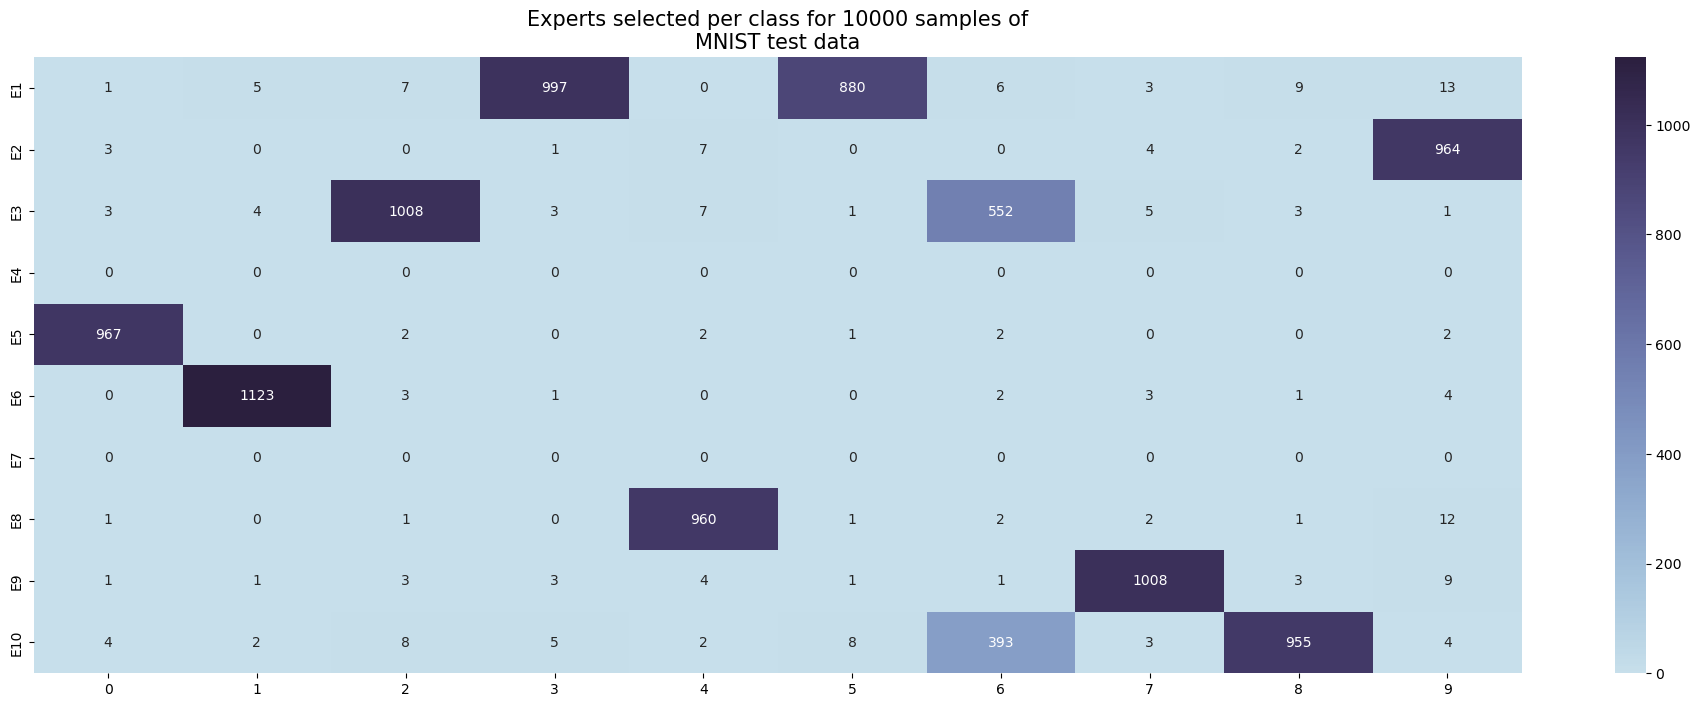

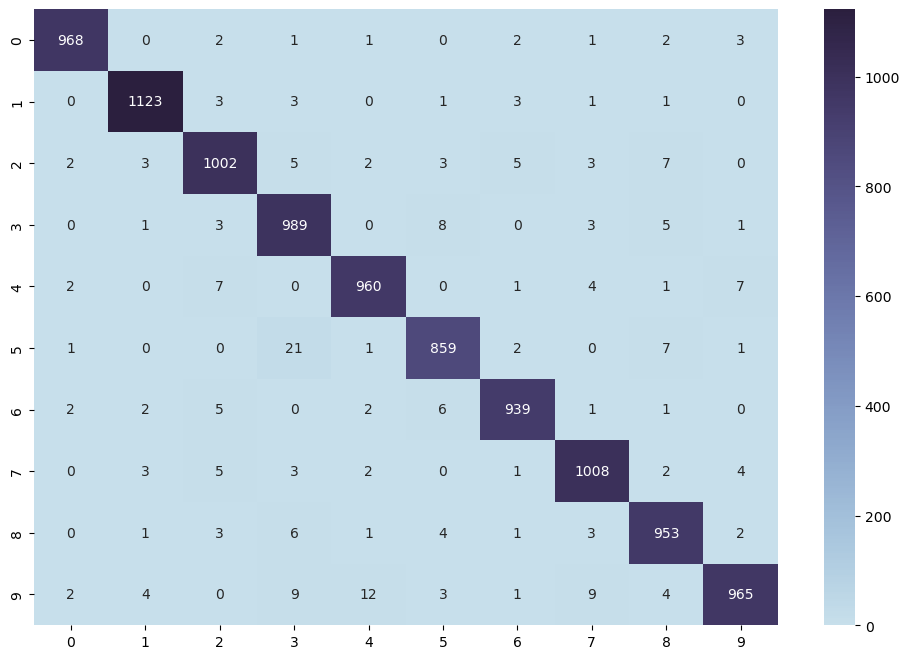

In [27]:
m = 'mnist_importance_rand_init_top_2'
total_experts = 10
num_classes = 10
classes = range(10)
num_epochs = 100

w_importance_range = [0.2]
test_loader = testloader

plot_expert_usage(m, test_loader,w_importance_range=w_importance_range,
                  total_experts=total_experts,num_classes=num_classes,
                 classes=classes, num_epochs=num_epochs, fig_path=fig_path,
                  model_path=model_path, device=device)

mnist_without_reg_loss_gate_10_10_models.pt
Min Training Error 0.077
Mutual Information 0.697
Sample Entropy 0.160
Expert Usage 0.000
test error tensor(0.0794, device='cuda:0')
expert log loss:
 tensor([[-2.3795e+00, -1.0560e-03, -2.4374e+00, -5.1908e+00, -2.8391e+00,
         -3.2216e+00, -2.3567e+00, -1.0208e+01, -2.3869e+00, -3.0974e-03],
        [-2.3542e+00, -4.2124e-01, -2.4172e+00, -1.9171e-03, -2.7914e+00,
         -6.9322e-03, -2.0063e+00, -3.0280e-05, -2.3263e+00, -7.6516e-01],
        [-2.2865e+00, -2.1666e+00, -2.4802e+00, -7.5356e-03, -1.5177e+00,
         -3.5744e+00, -2.0689e+00, -6.8294e+00, -2.1840e+00, -1.2301e-02],
        [-2.3807e+00, -1.3100e-03, -2.2141e+00, -1.4106e-03, -2.9615e+00,
         -1.8840e-03, -2.7569e+00, -1.1255e+01, -2.2030e+00, -1.2750e-01],
        [-2.2854e+00, -4.1272e+00, -2.0690e+00, -4.5372e+00, -2.8571e+00,
         -2.6696e-02, -2.2065e+00, -1.0714e+01, -2.4303e+00, -2.9224e-02]],
       device='cuda:0', grad_fn=<SliceBackward0>)
expert lo

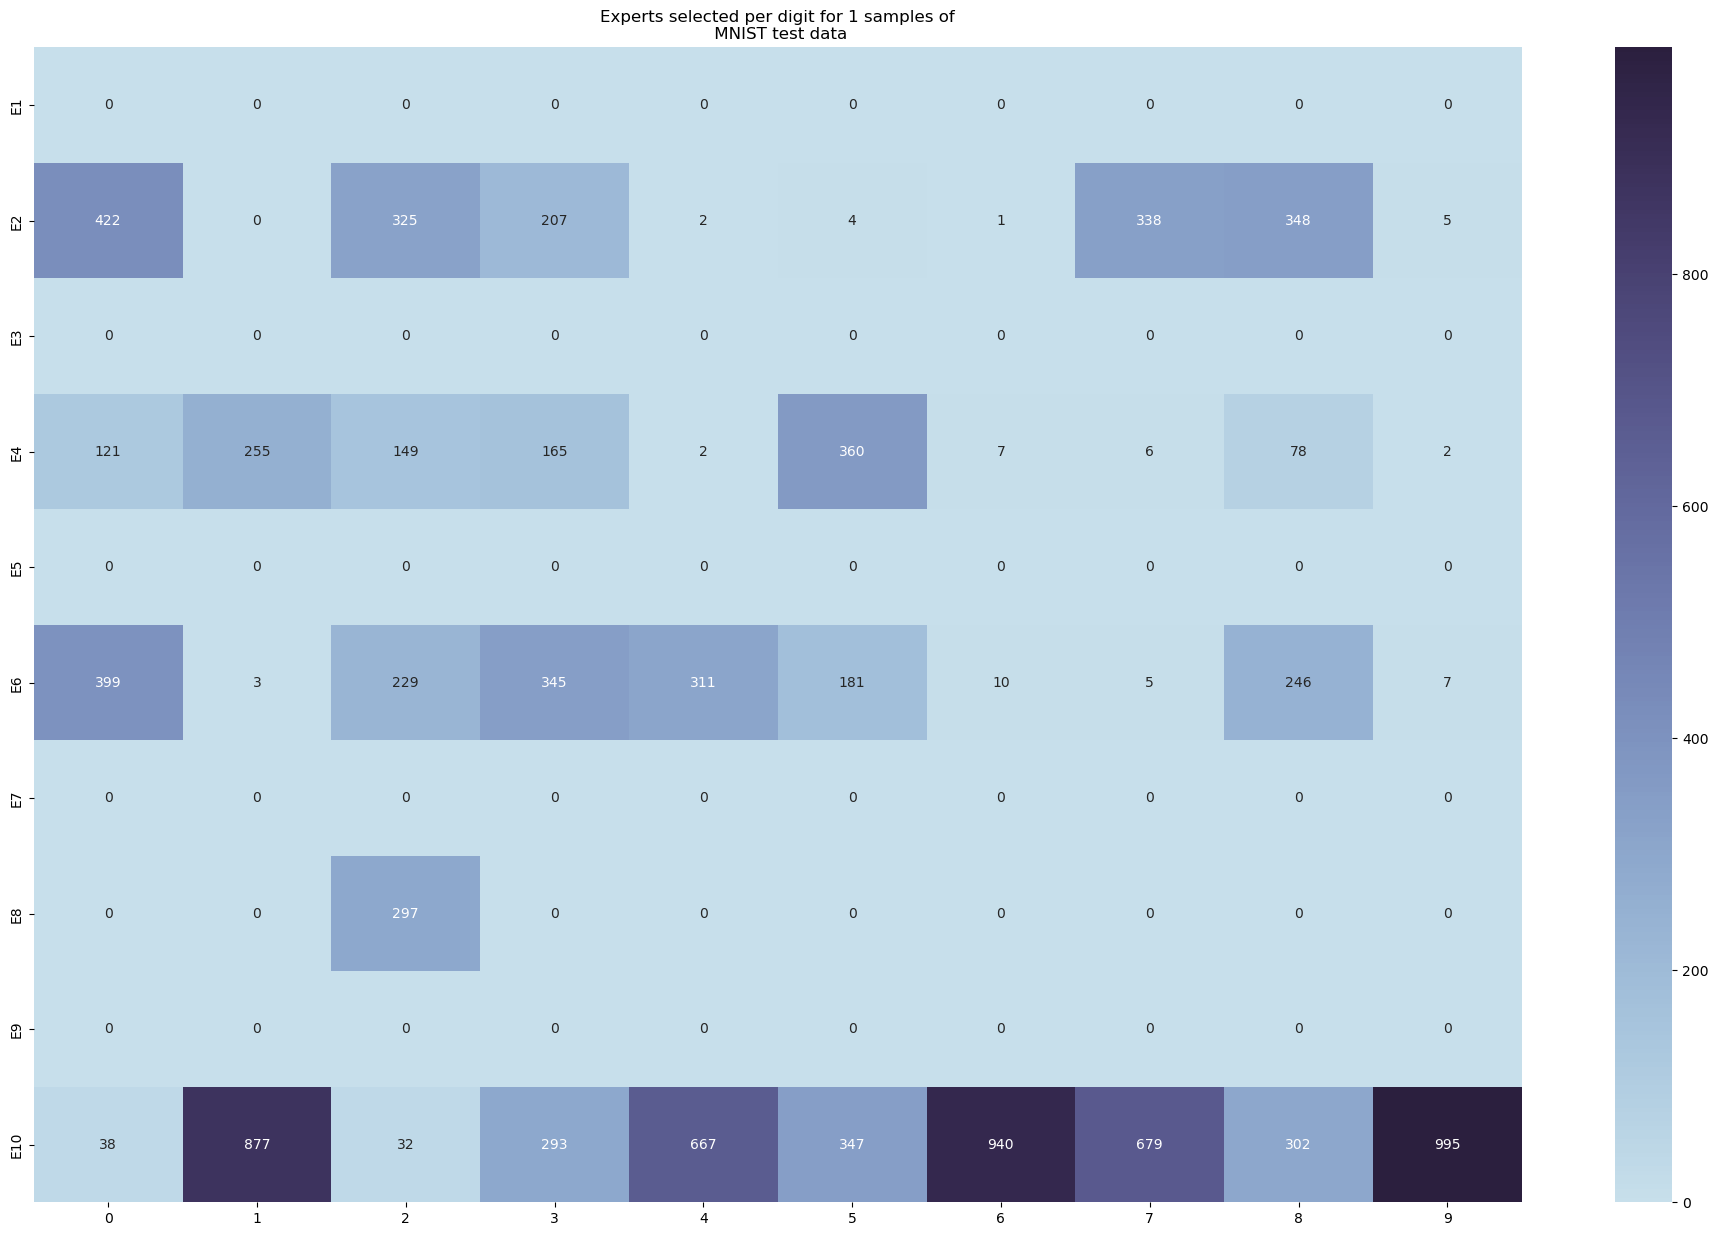

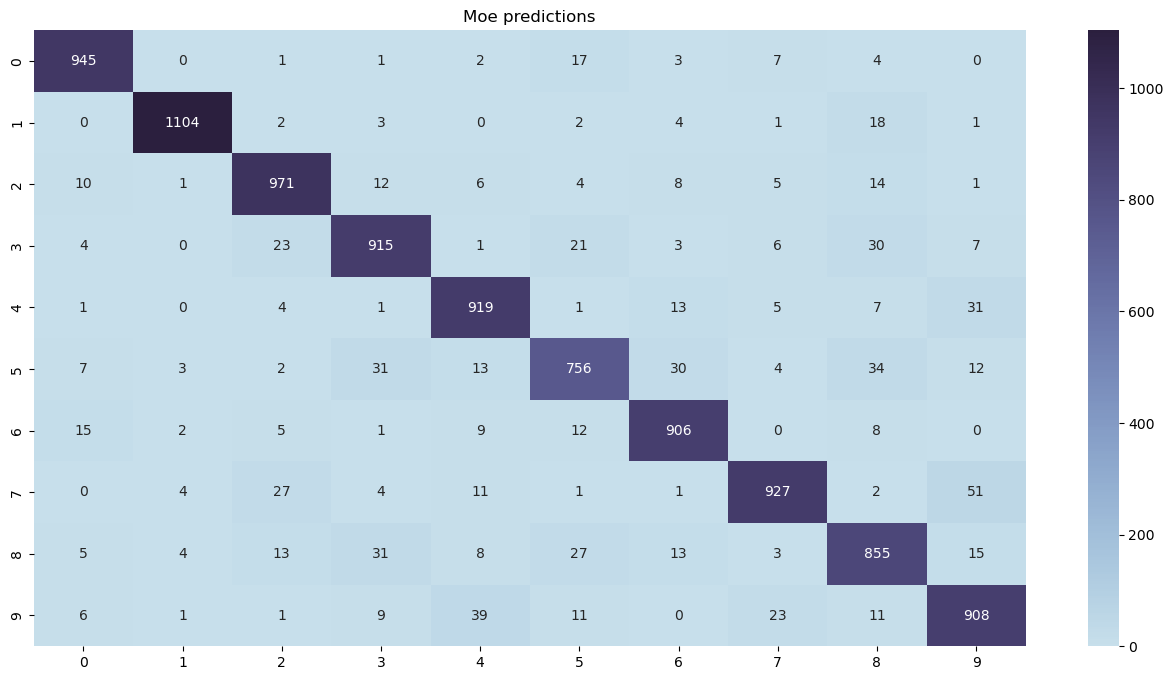

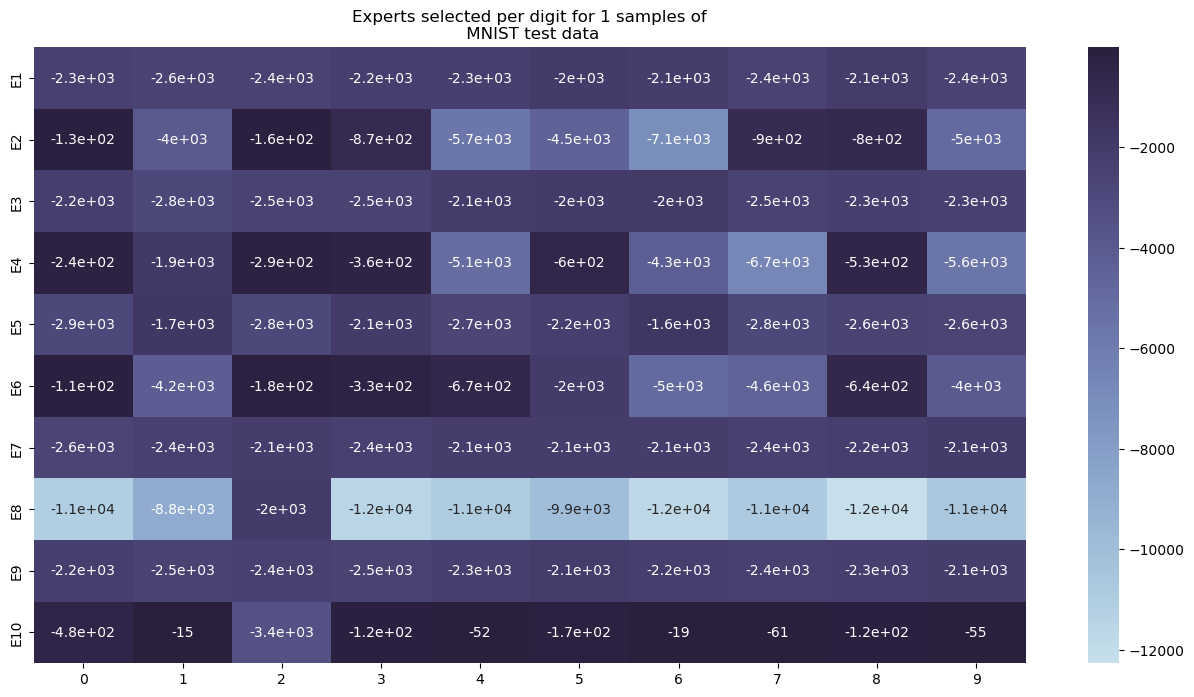

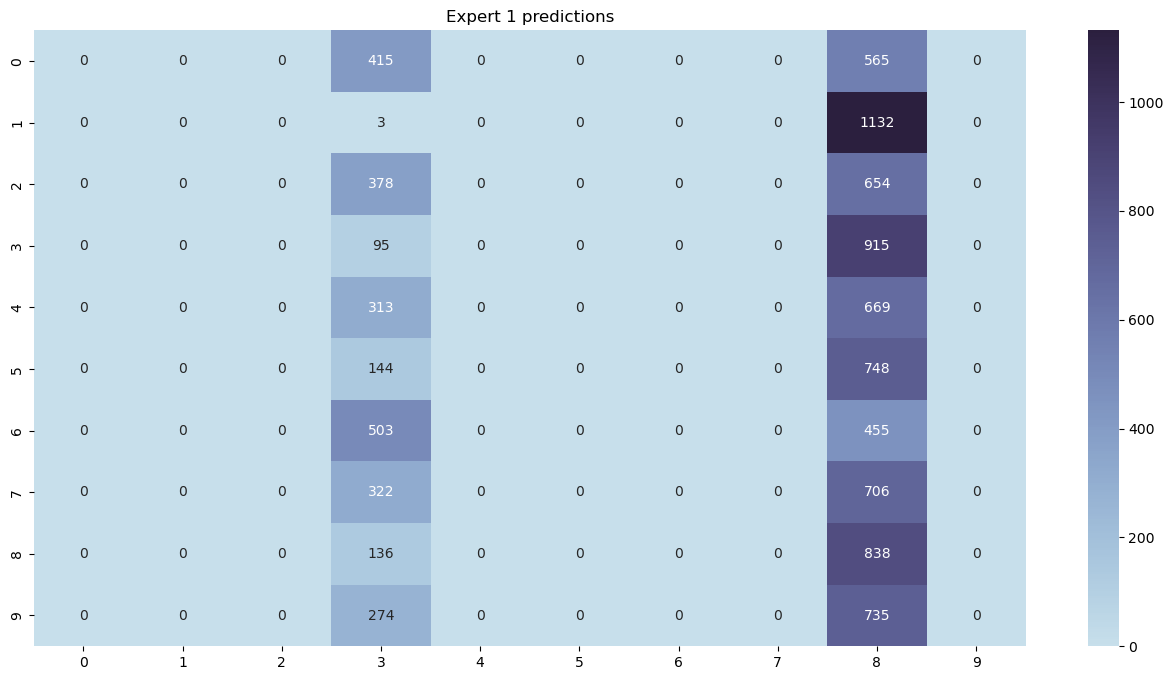

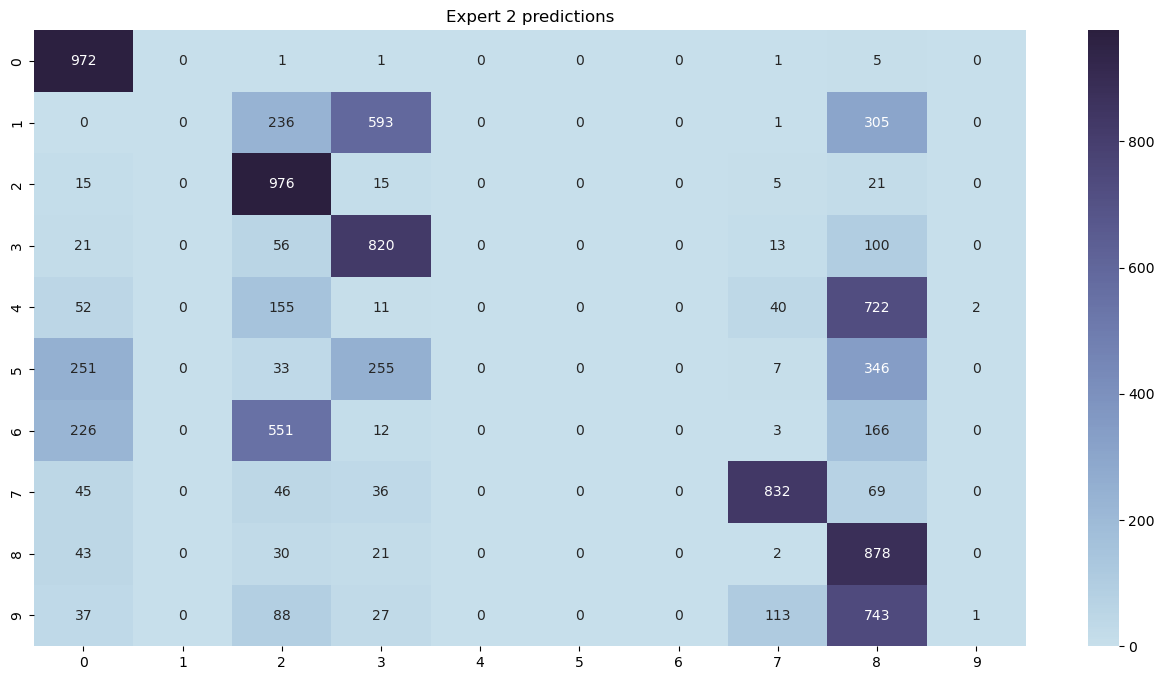

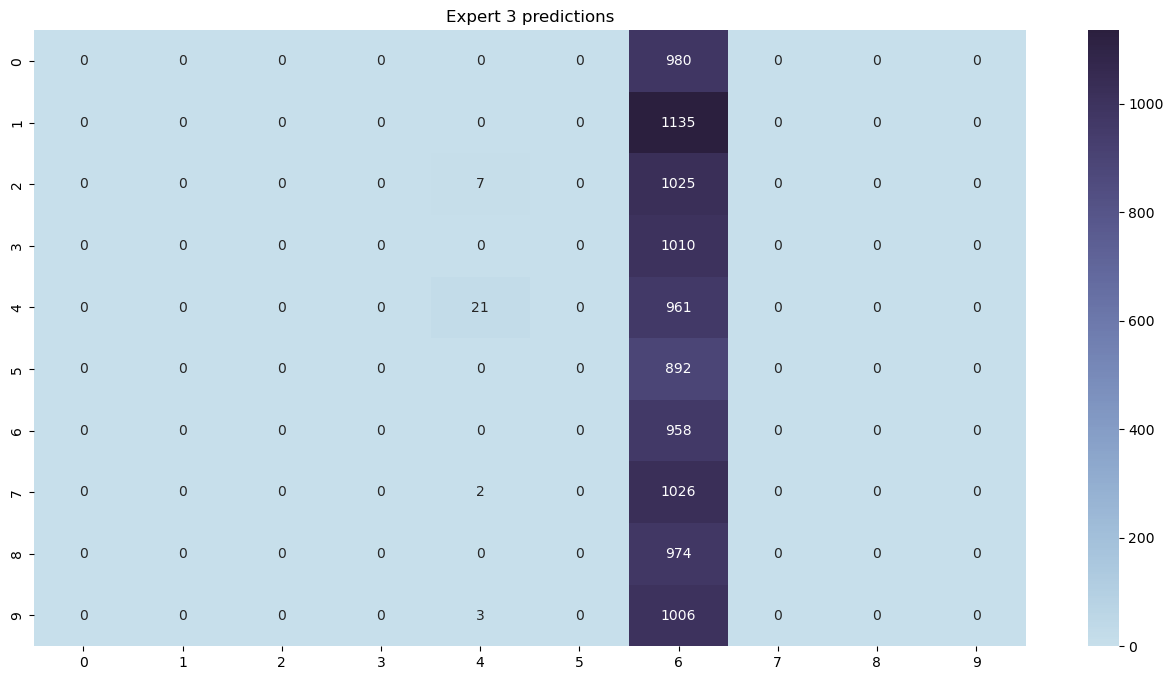

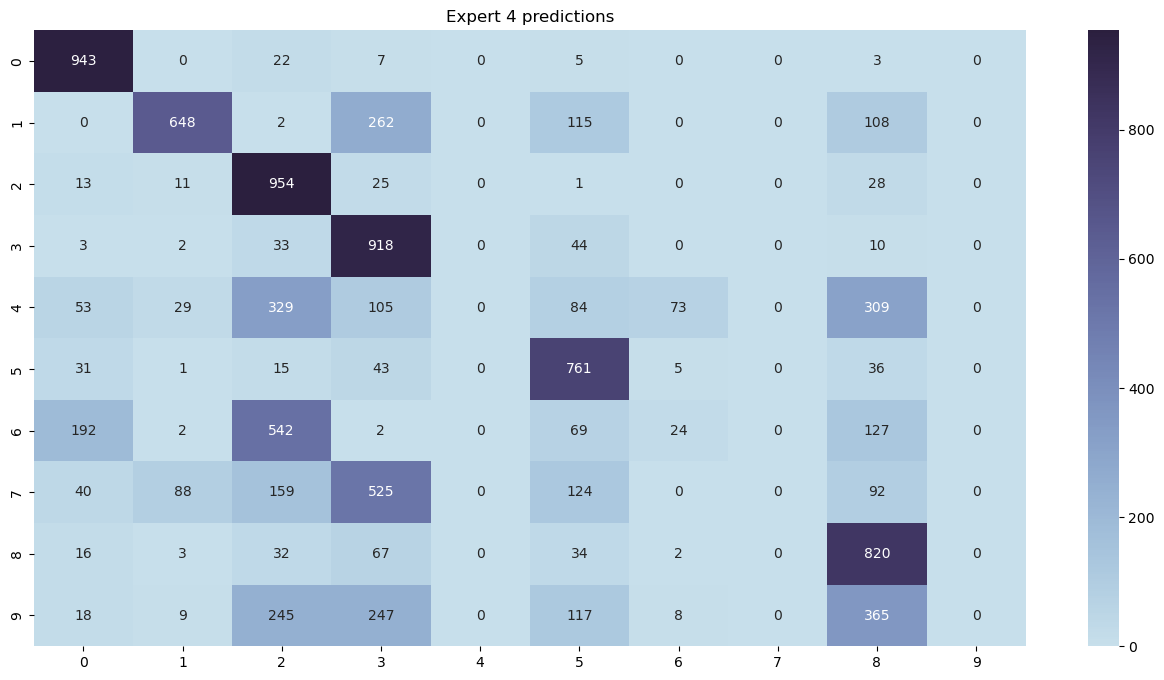

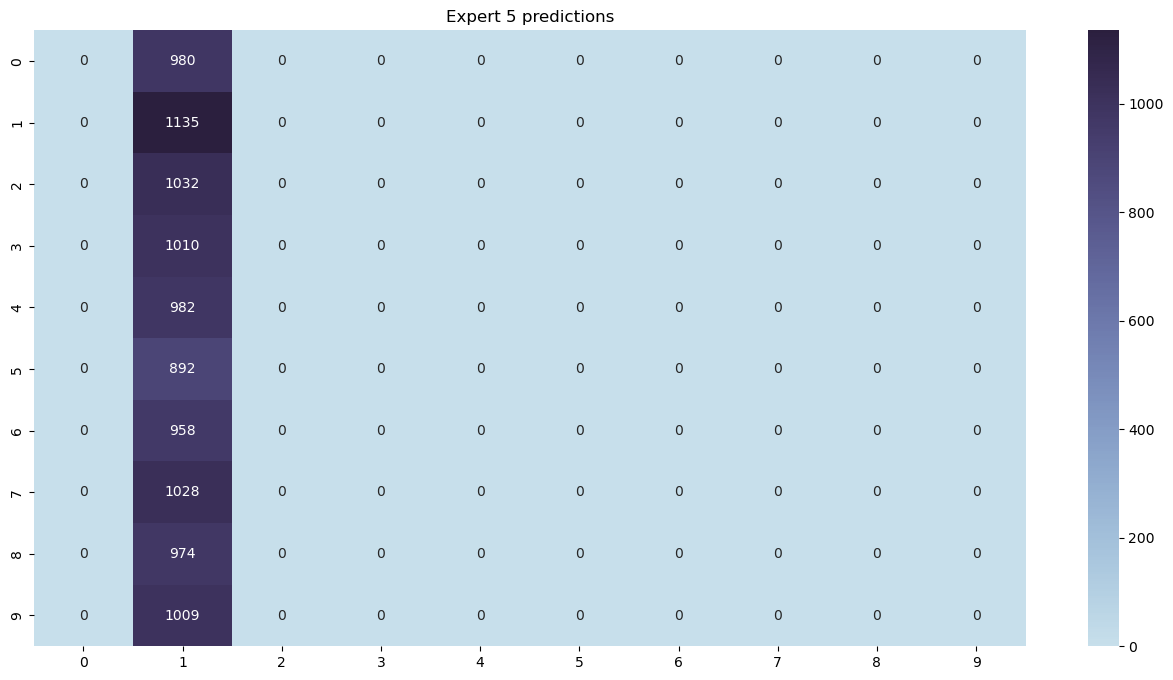

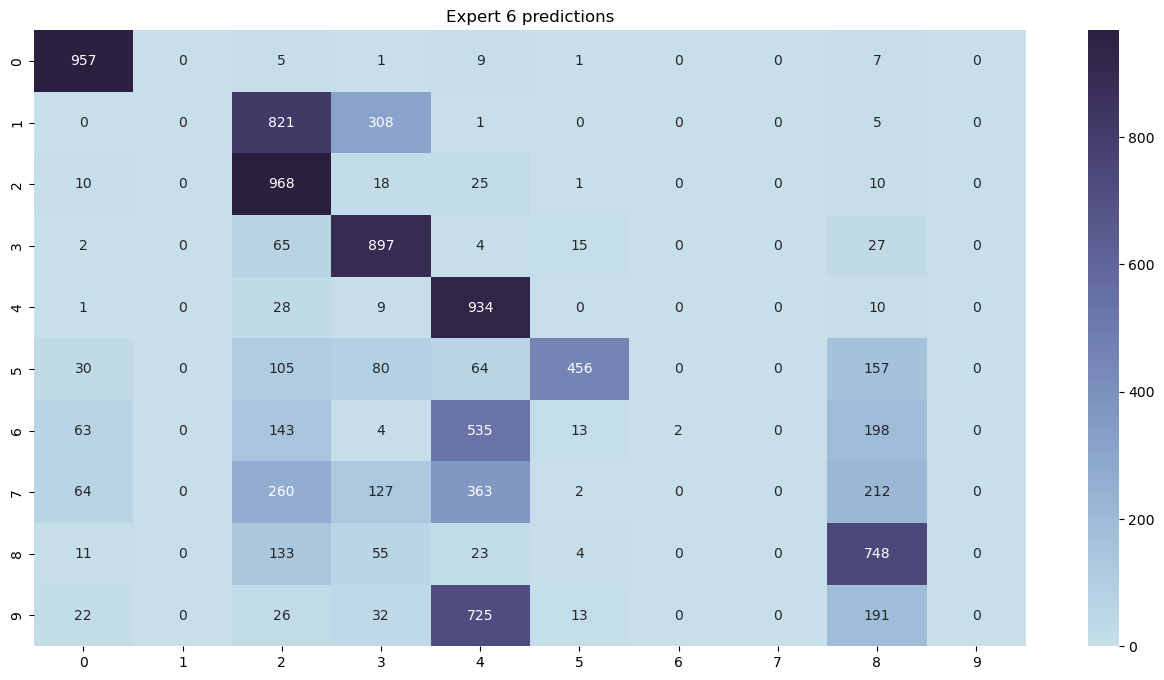

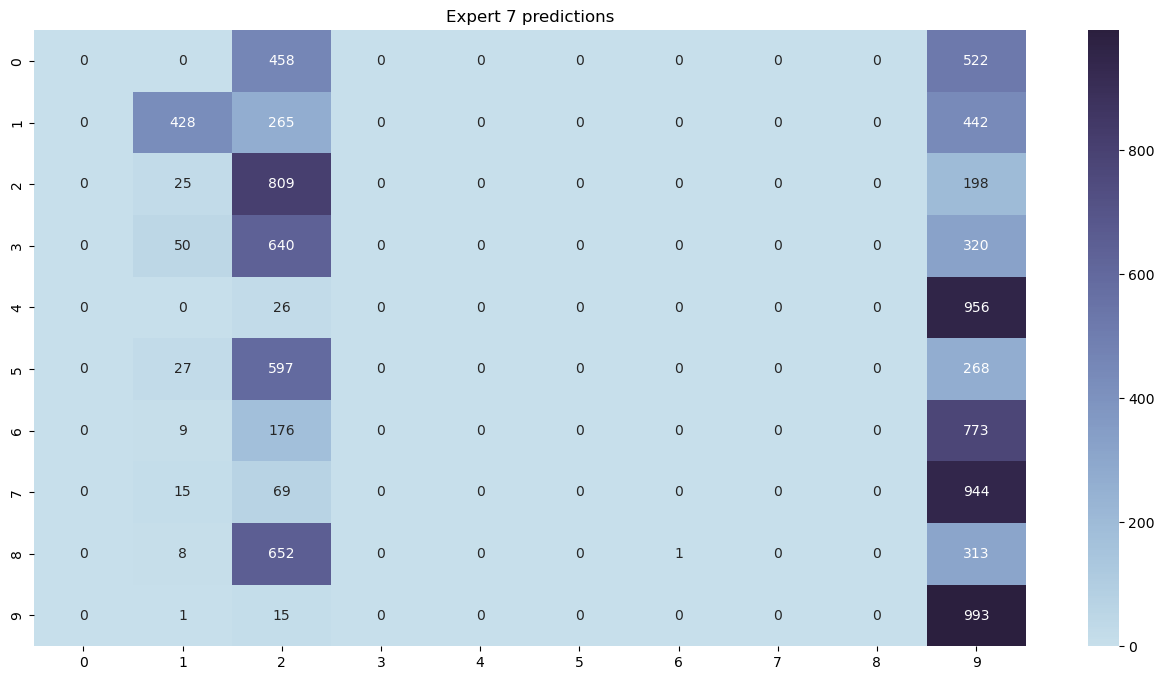

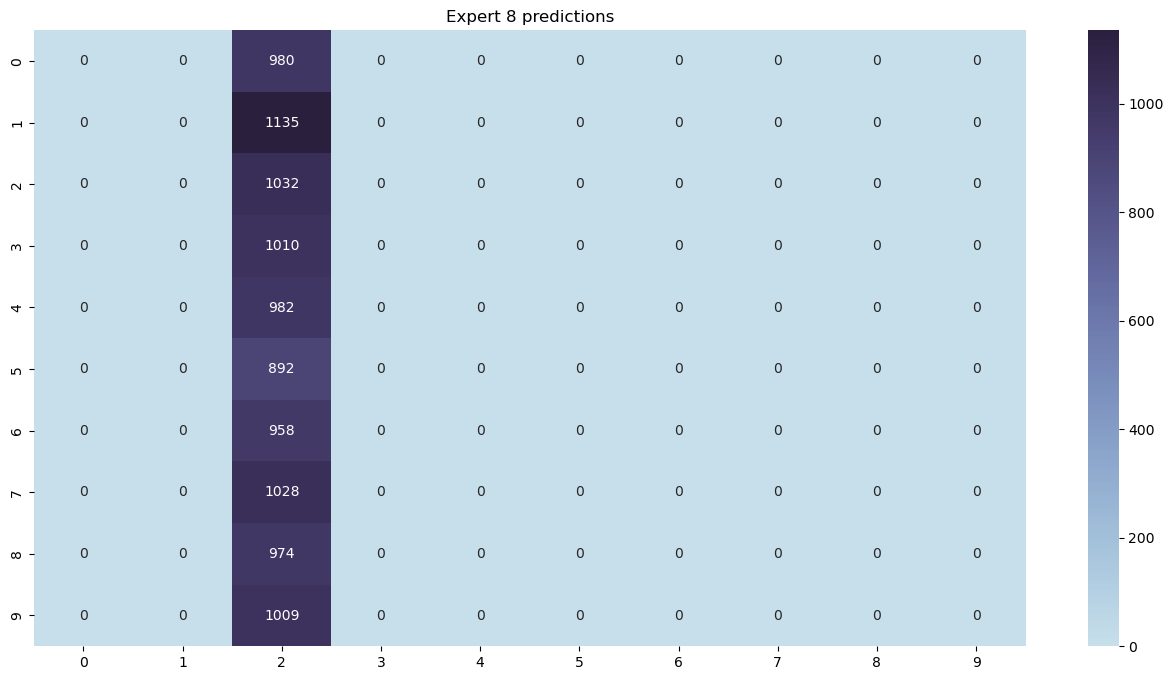

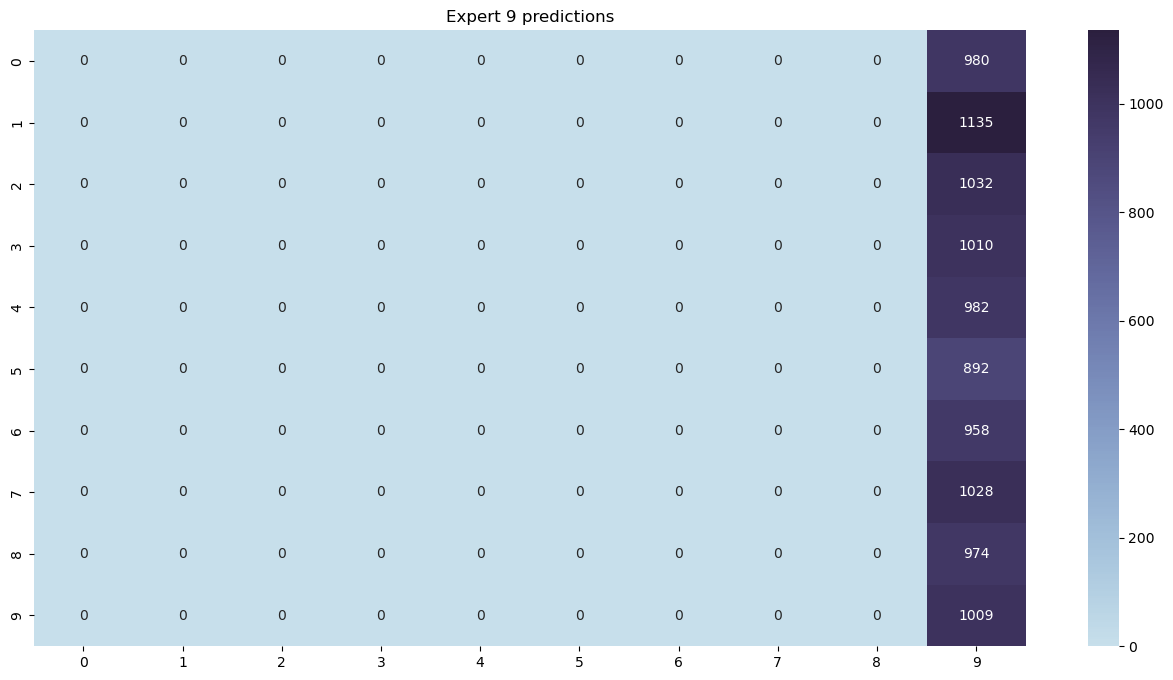

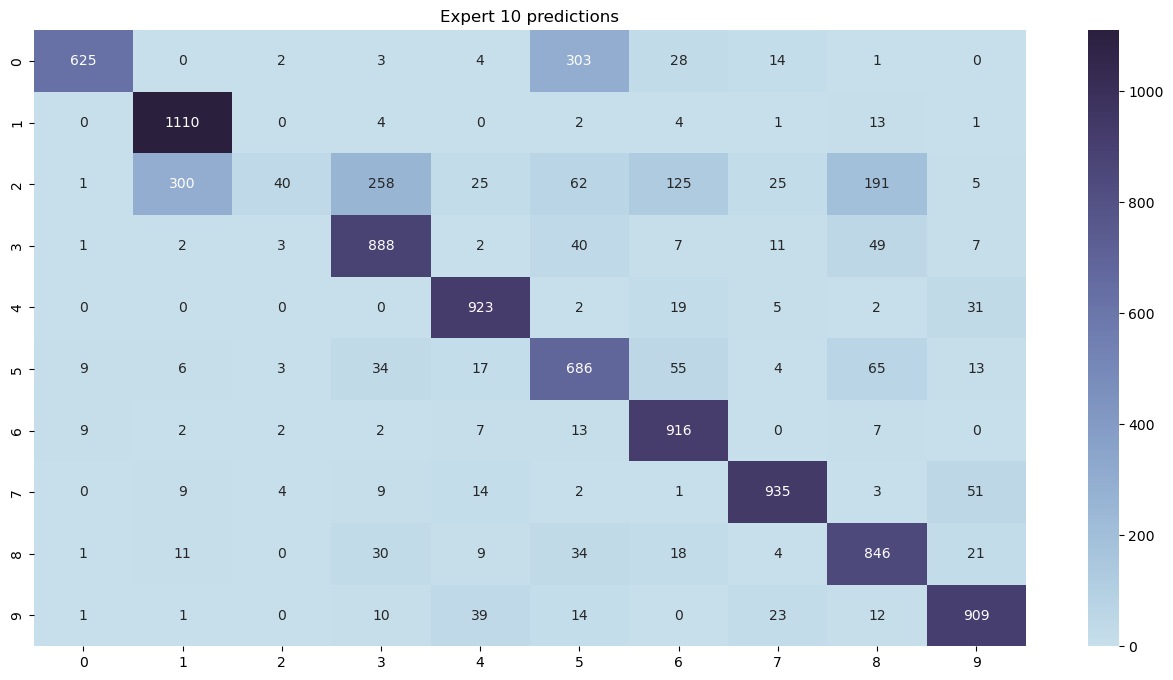

In [57]:
m = 'mnist_without_reg_loss_gate'
model_type = 'moe_expert_loss_model'
show_results(m, model_type, model_path=os.path.join(model_path, 'top_k_random_gate'))

mnist_without_reg_loss_gate_10_10_models.pt
Min Training Error 0.084
Mutual Information 0.000
Sample Entropy 0.000
Expert Usage 0.000
test error tensor(0.0890, device='cuda:0')
expert log loss:
 tensor([[-6.7710e-04, -2.4585e+00, -2.3817e+00, -2.4011e+00, -2.1788e+00,
         -2.5766e+00, -2.0479e+00, -2.5126e+00, -2.2207e+00, -2.4379e+00],
        [-1.0051e-02, -2.2041e+00, -2.4405e+00, -2.4346e+00, -2.5520e+00,
         -2.4868e+00, -2.5625e+00, -2.1675e+00, -2.1741e+00, -2.2920e+00],
        [-3.5283e-03, -2.3481e+00, -2.1923e+00, -2.5173e+00, -2.2197e+00,
         -2.1623e+00, -2.4986e+00, -2.1711e+00, -2.6374e+00, -2.3270e+00],
        [-1.2105e-03, -2.2042e+00, -2.3322e+00, -2.0574e+00, -2.4265e+00,
         -2.0347e+00, -2.0424e+00, -2.4568e+00, -2.3030e+00, -2.3780e+00],
        [-3.5957e-02, -2.2280e+00, -2.2257e+00, -2.3733e+00, -2.1173e+00,
         -2.2965e+00, -2.3384e+00, -2.2922e+00, -2.3237e+00, -2.2314e+00]],
       device='cuda:0', grad_fn=<SliceBackward0>)
expert lo

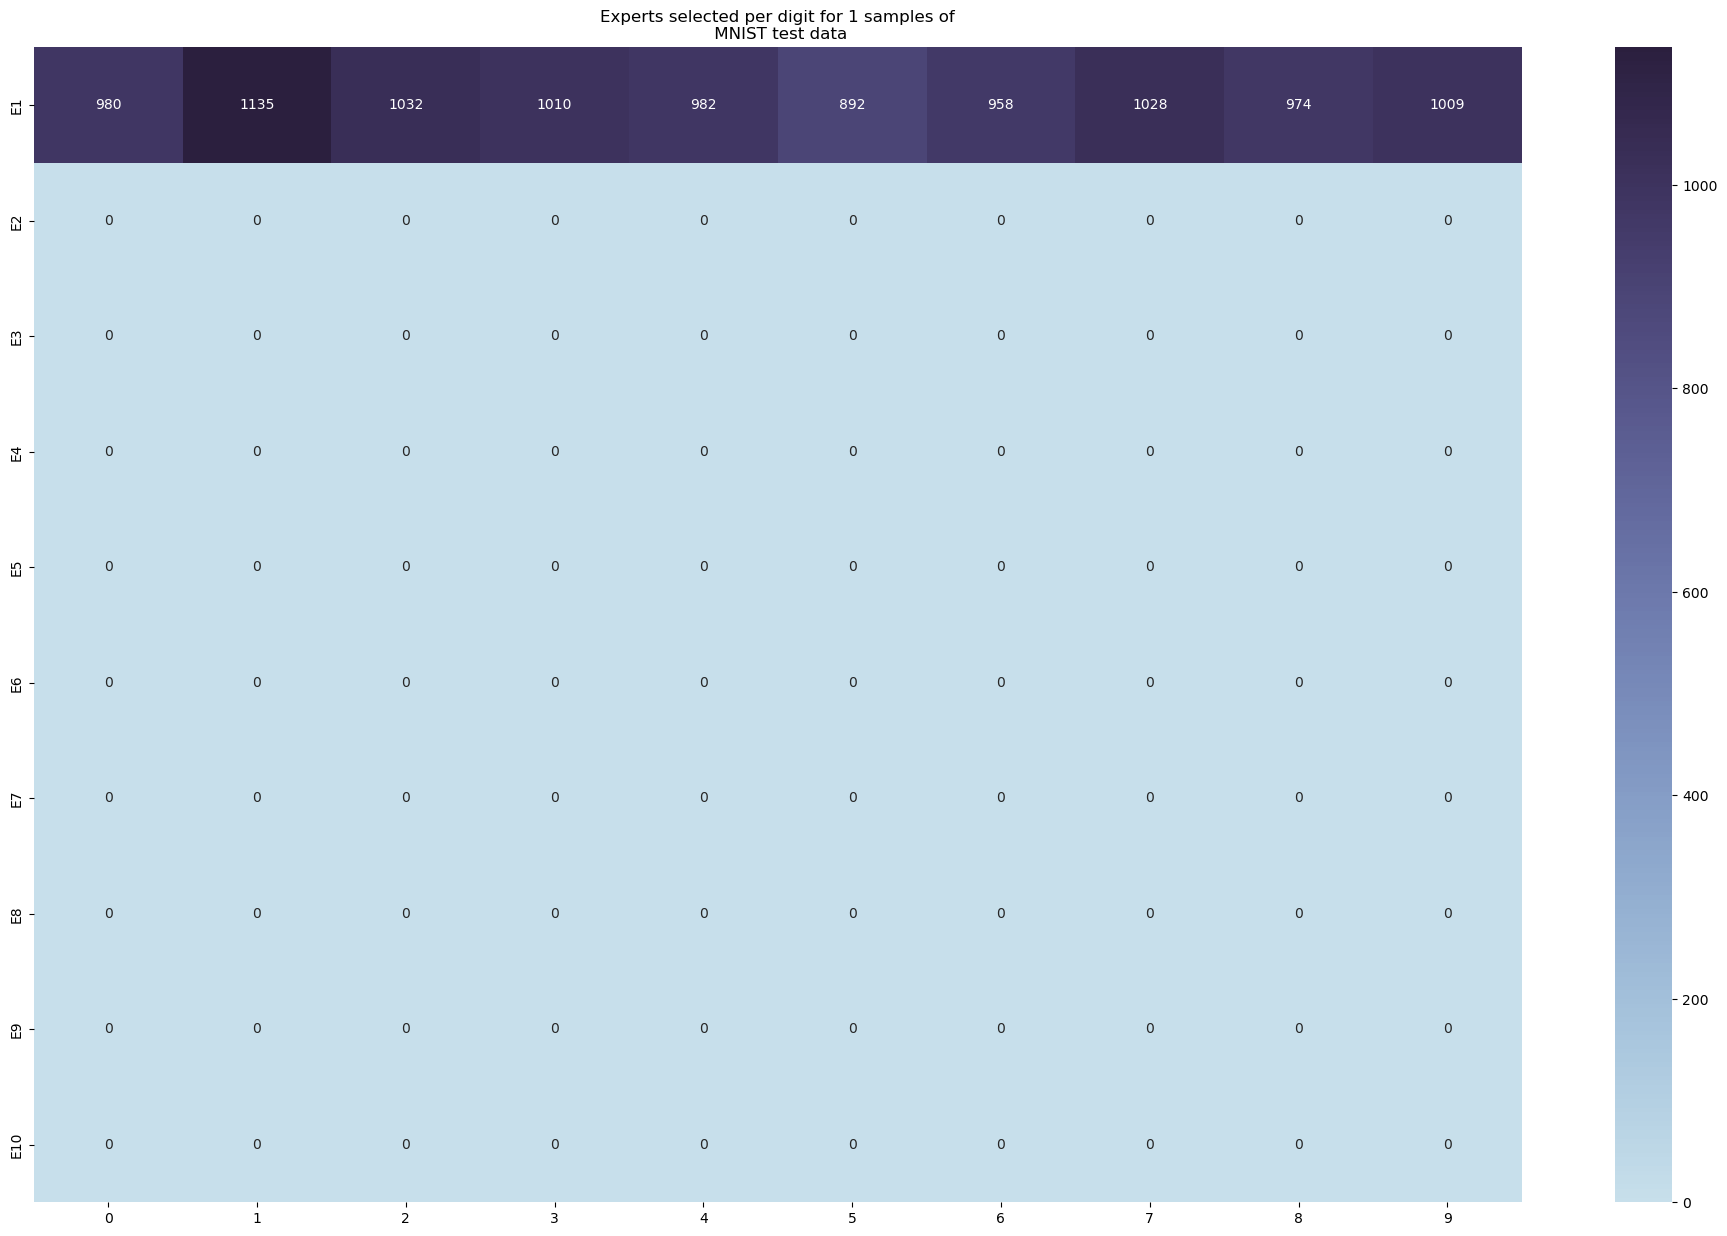

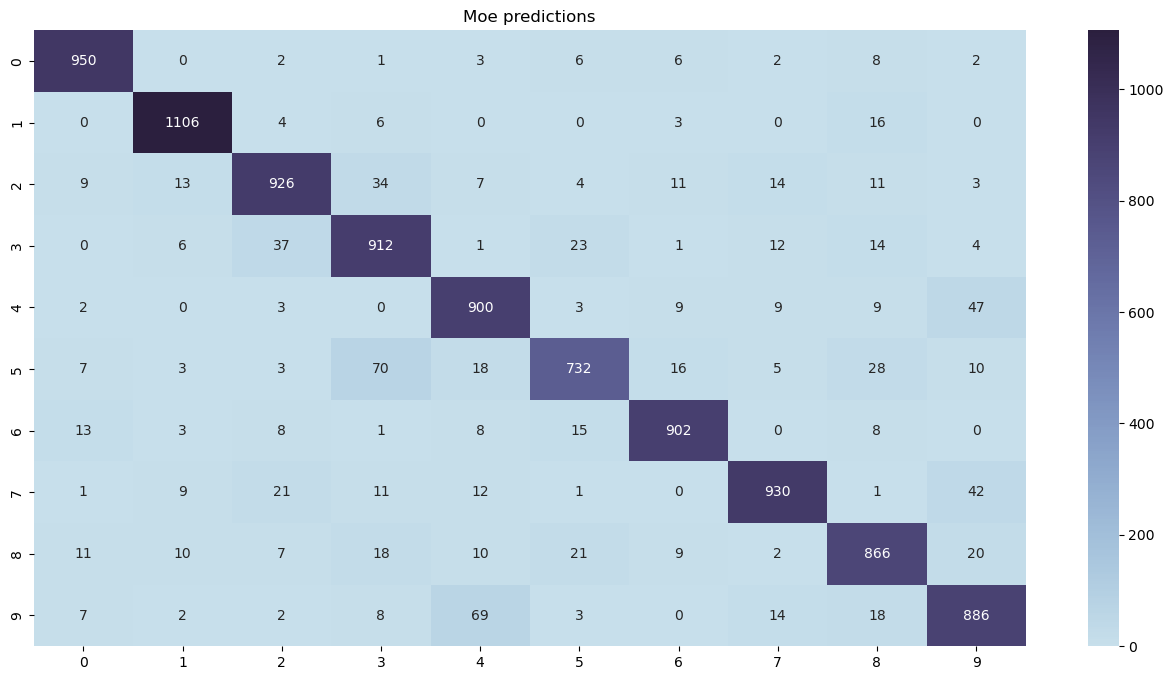

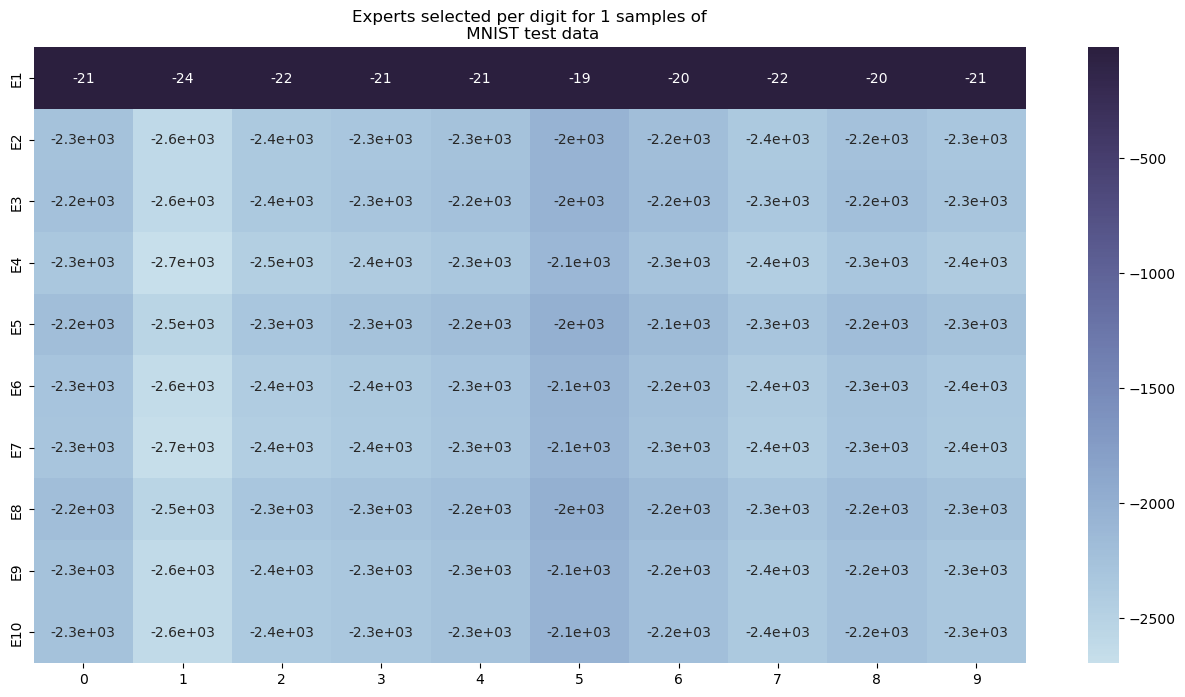

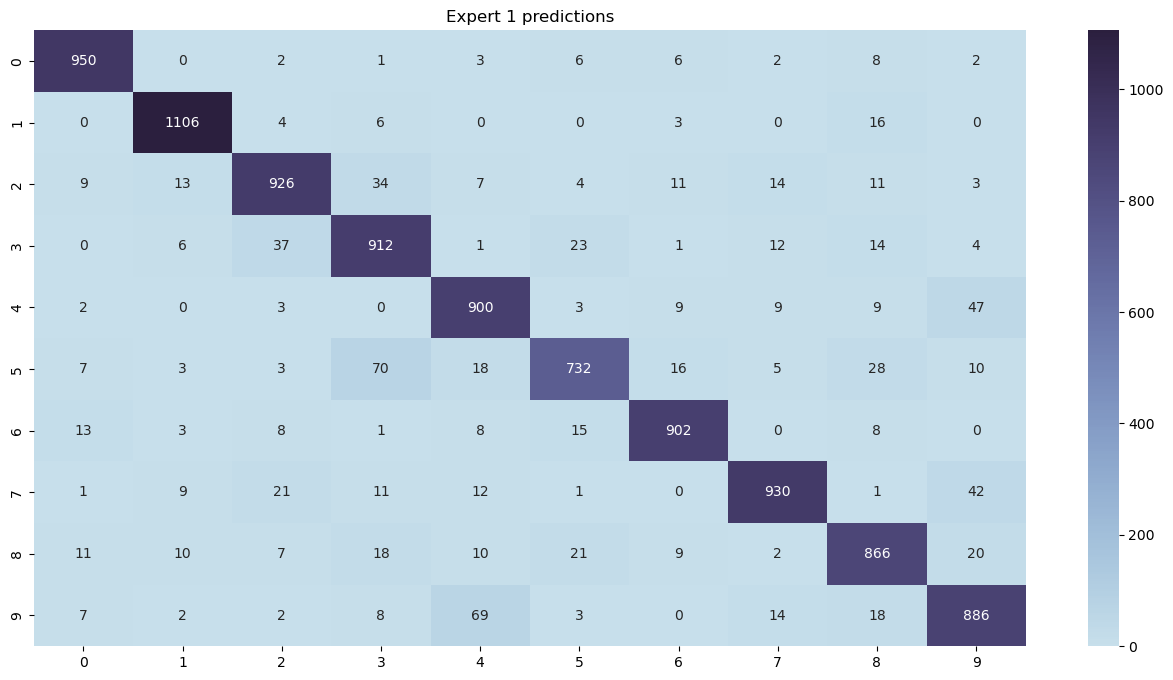

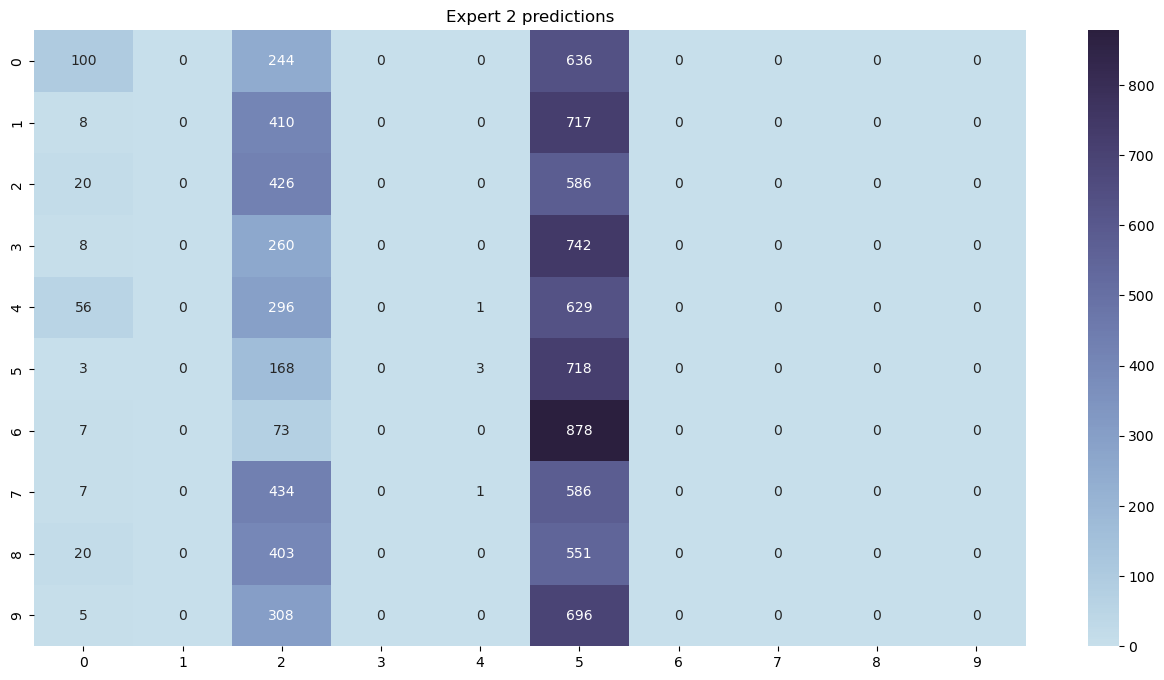

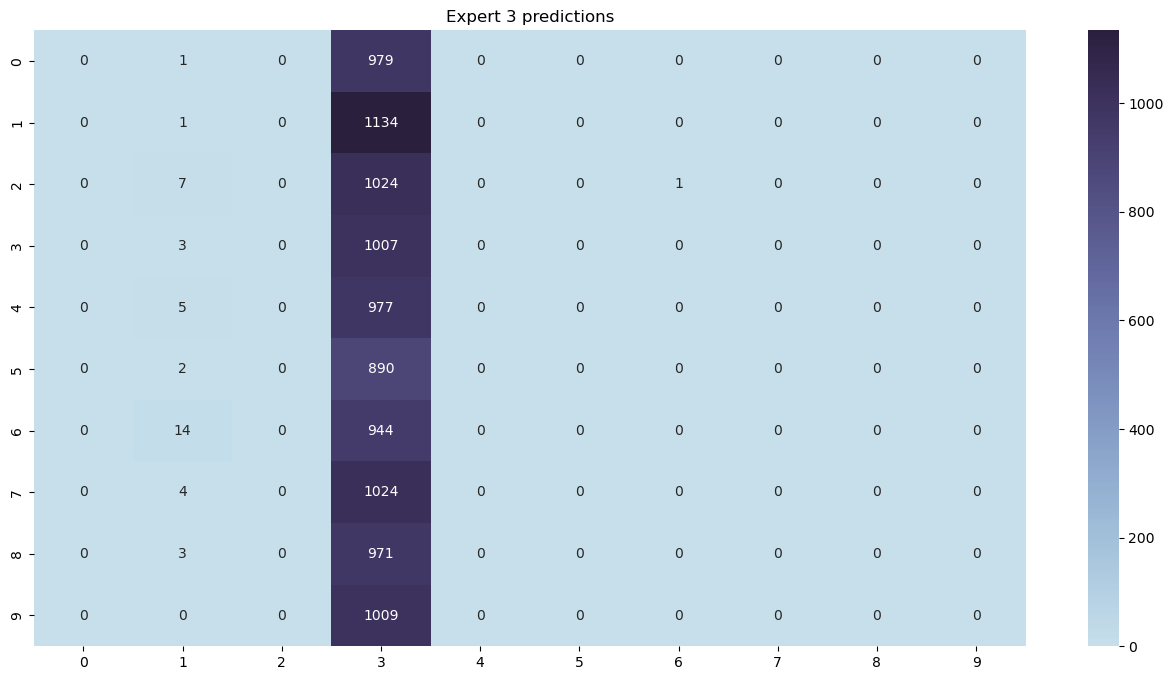

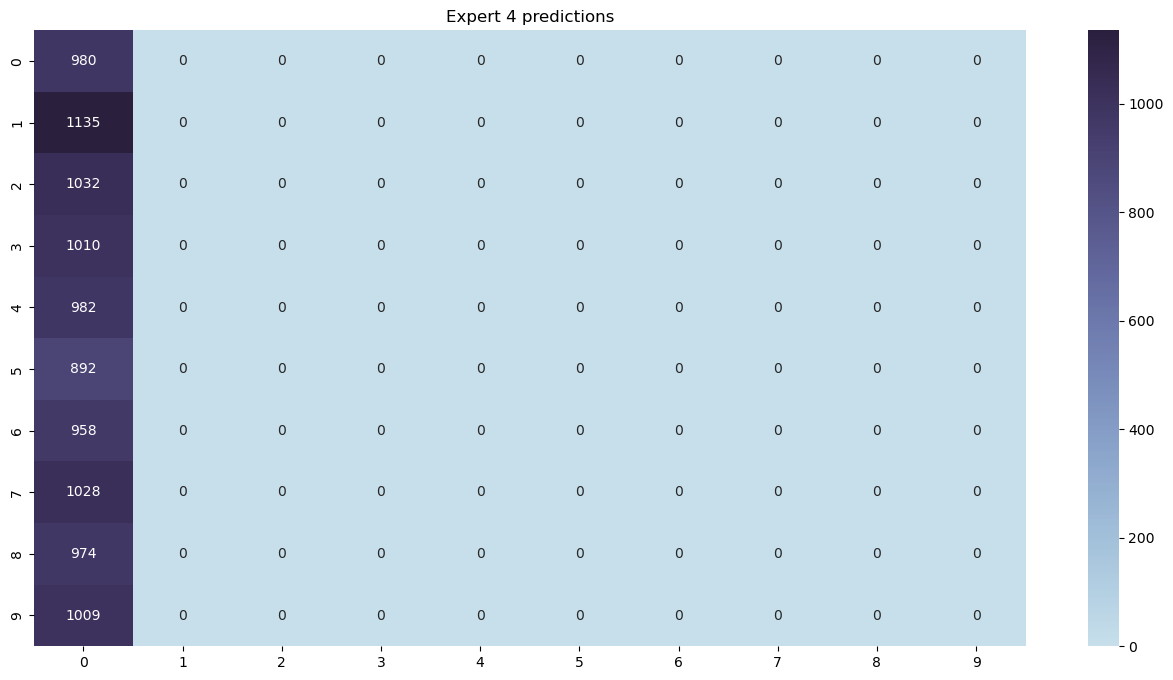

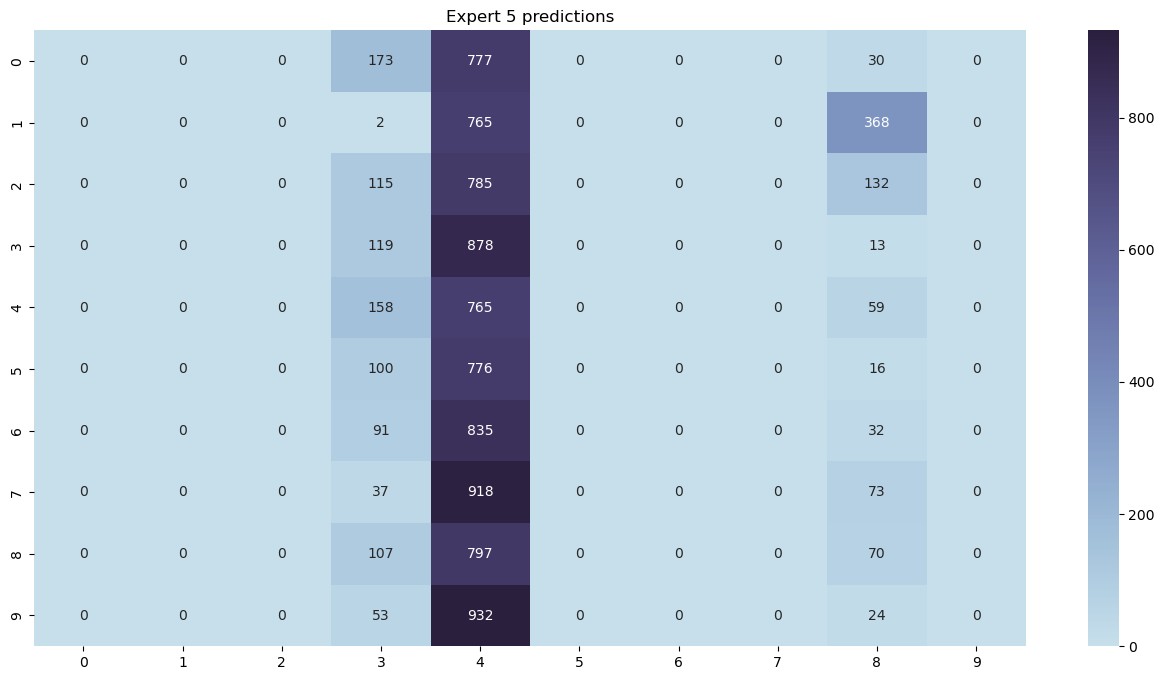

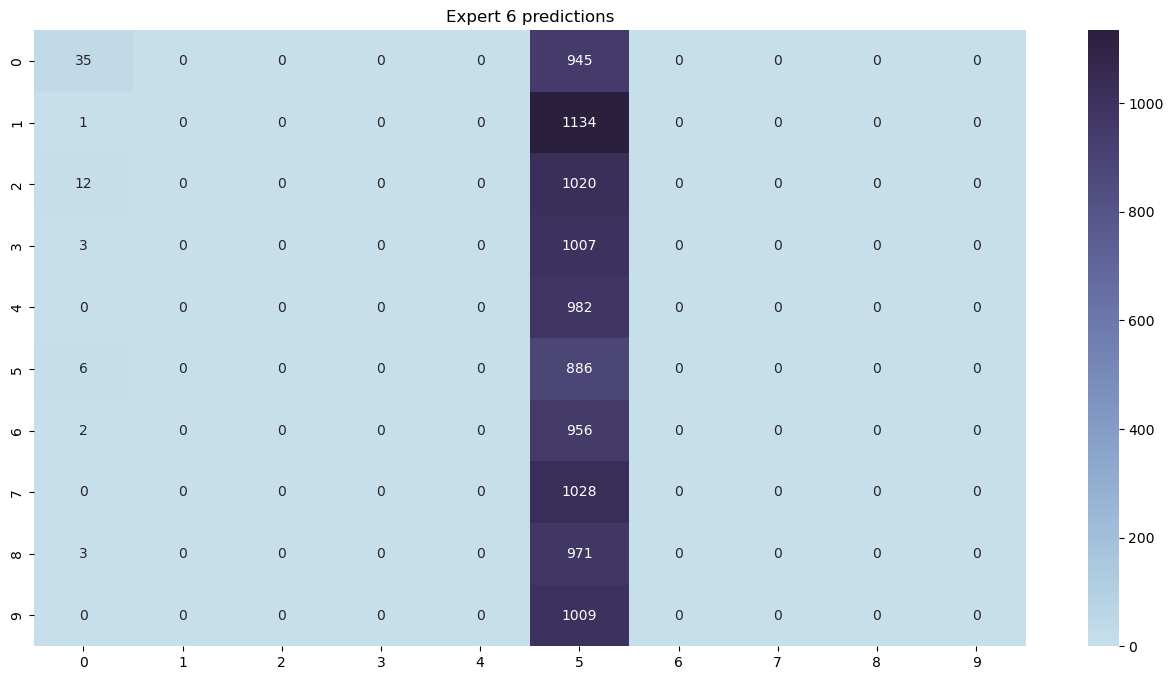

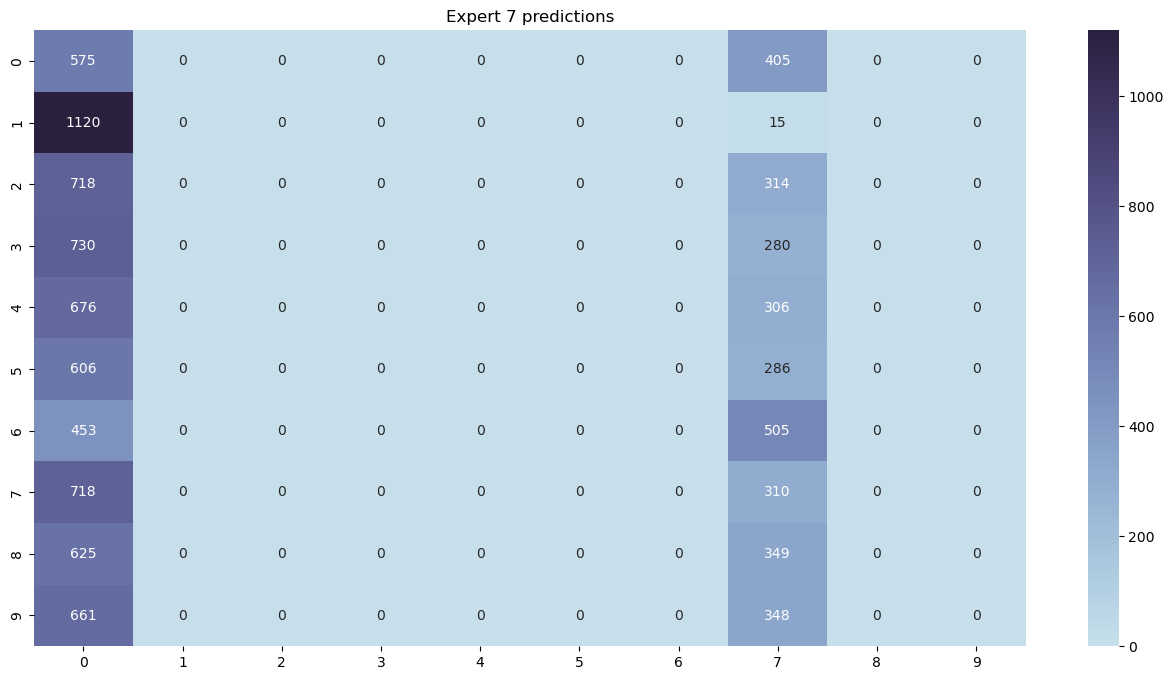

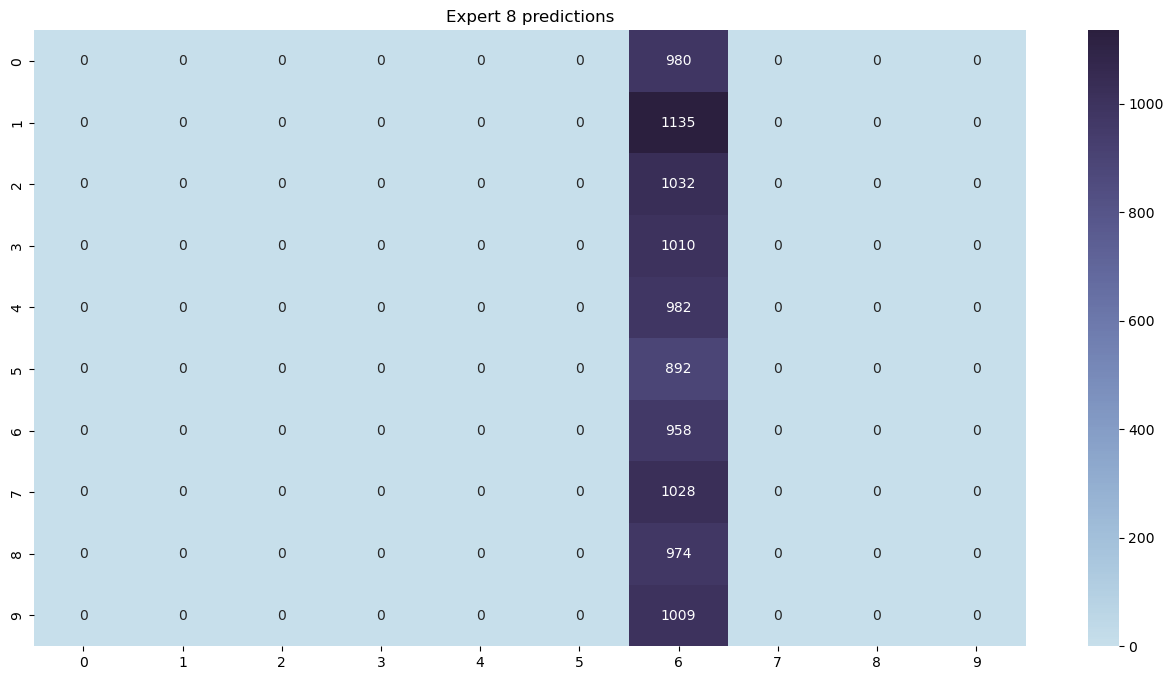

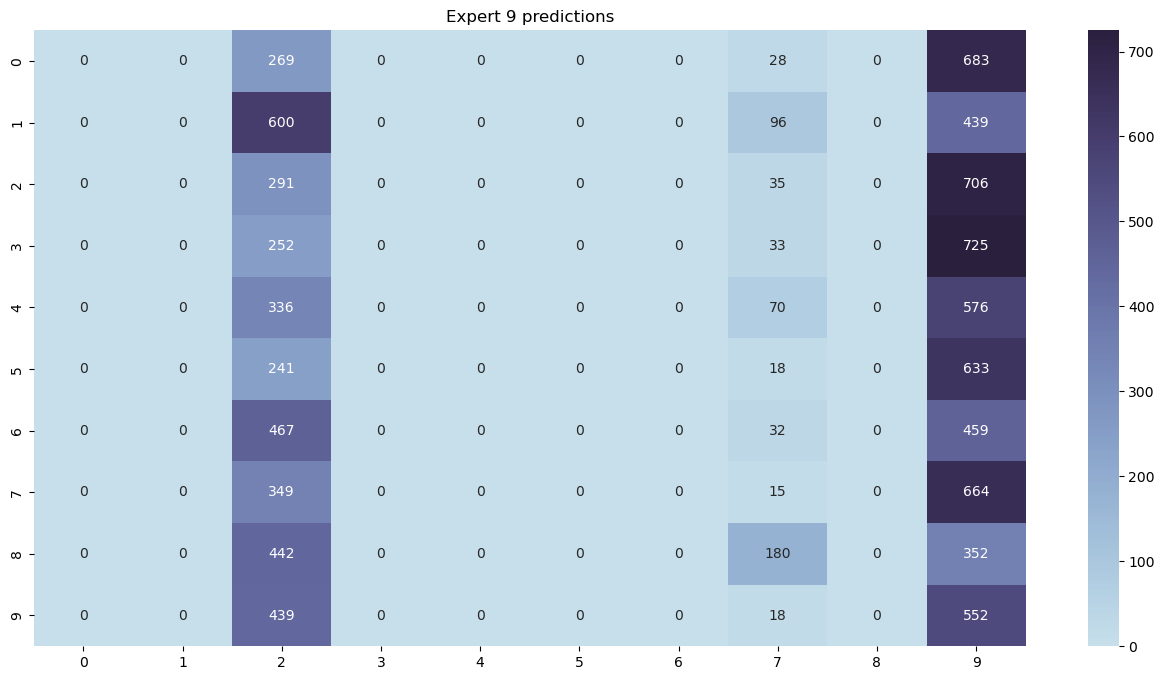

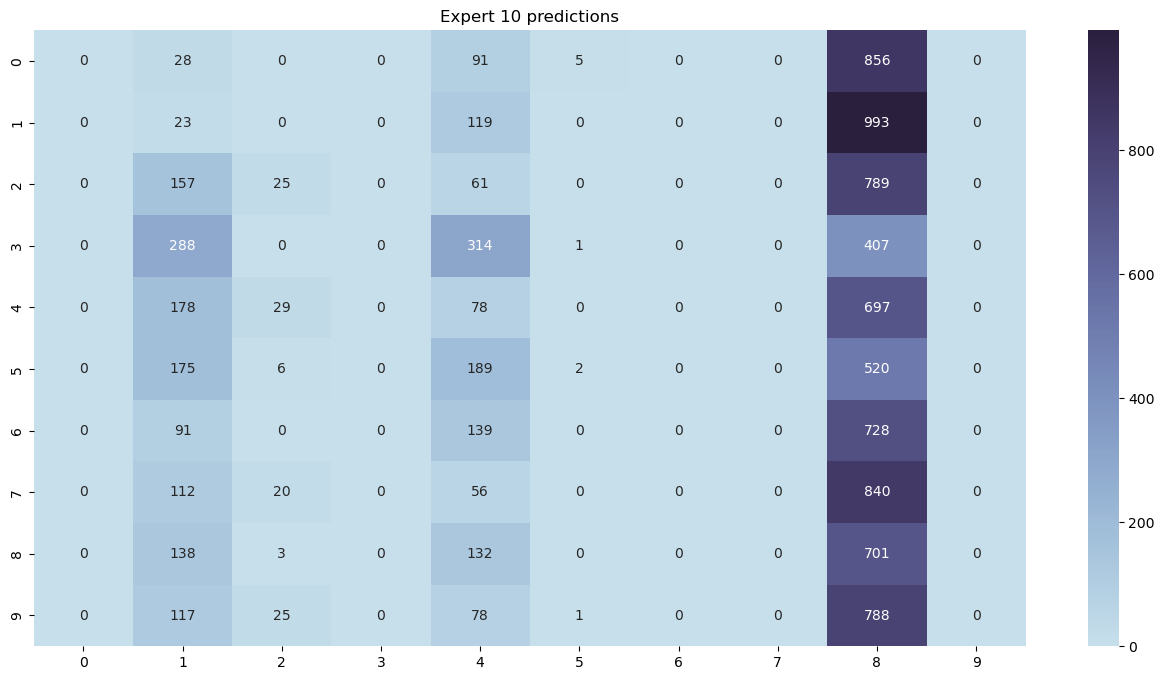

In [54]:
m = 'mnist_without_reg_loss_gate'
model_type = 'moe_expert_loss_model'
show_results(m, model_type)

mnist_without_reg_loss_gate_10_10_models.pt
Min Training Error 0.084
Mutual Information 0.000
Sample Entropy 0.000
Expert Usage 0.000
mnist_without_reg_loss_gate_10_10_models.pt


<Figure size 640x480 with 0 Axes>

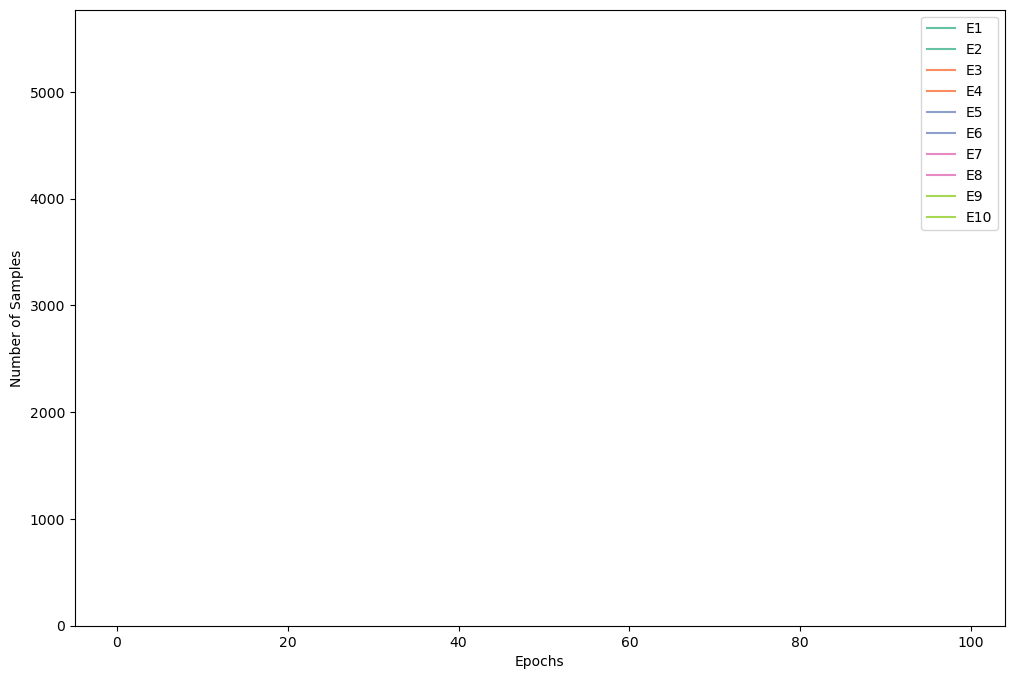

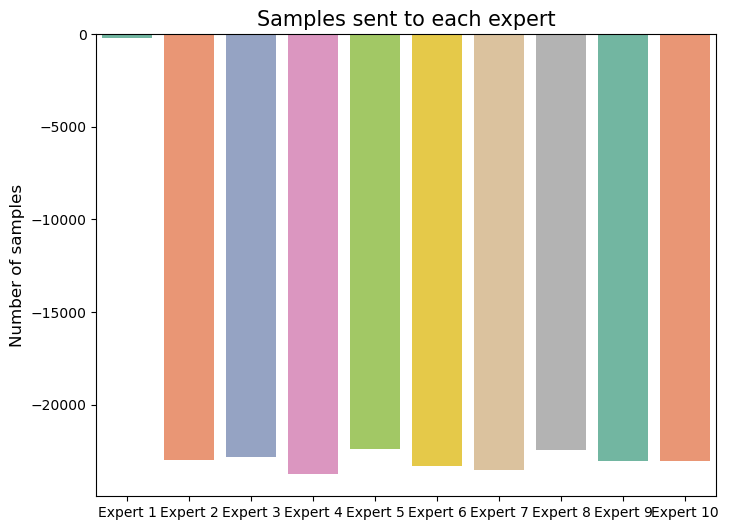

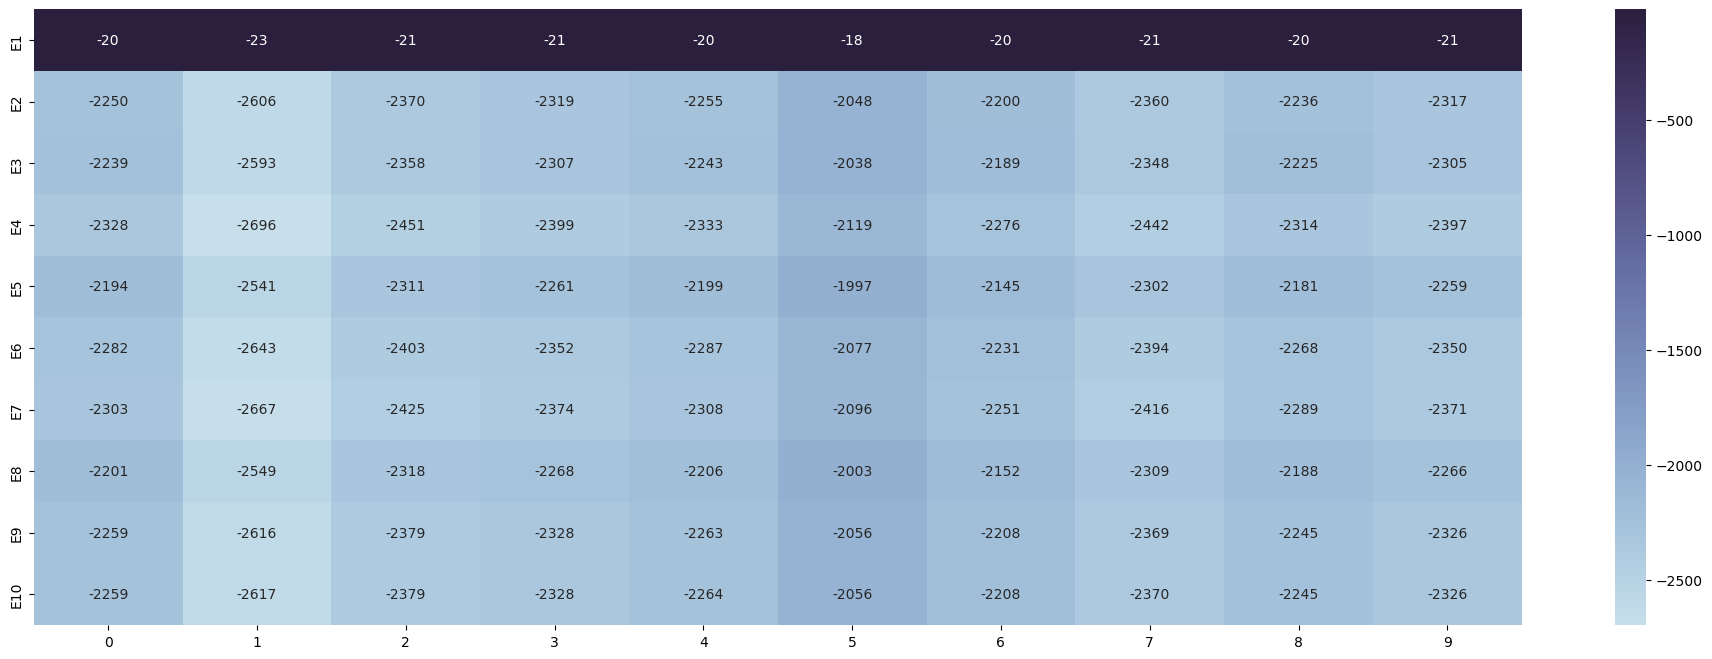


Experts used by the gate for classification of each class


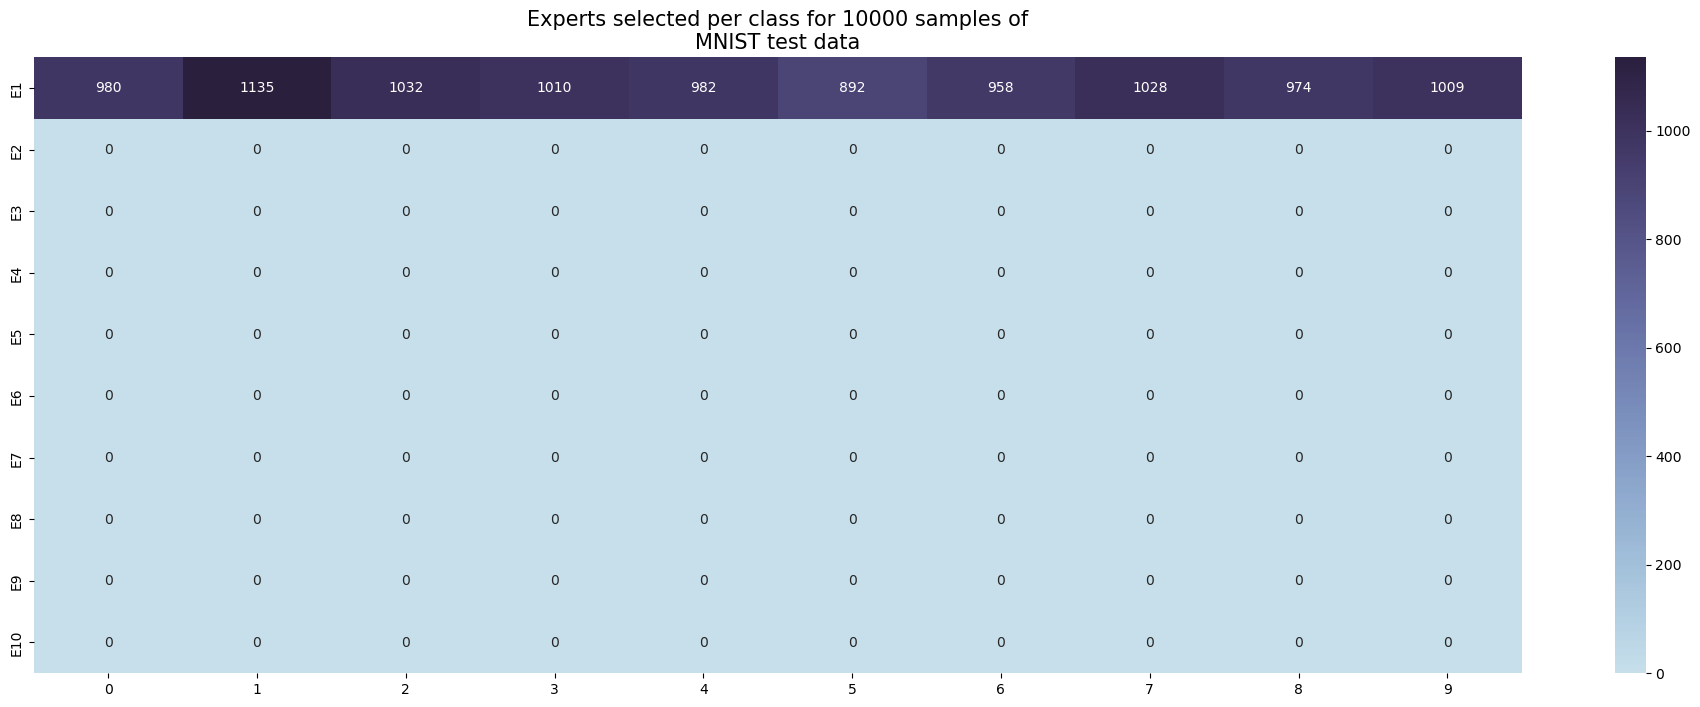

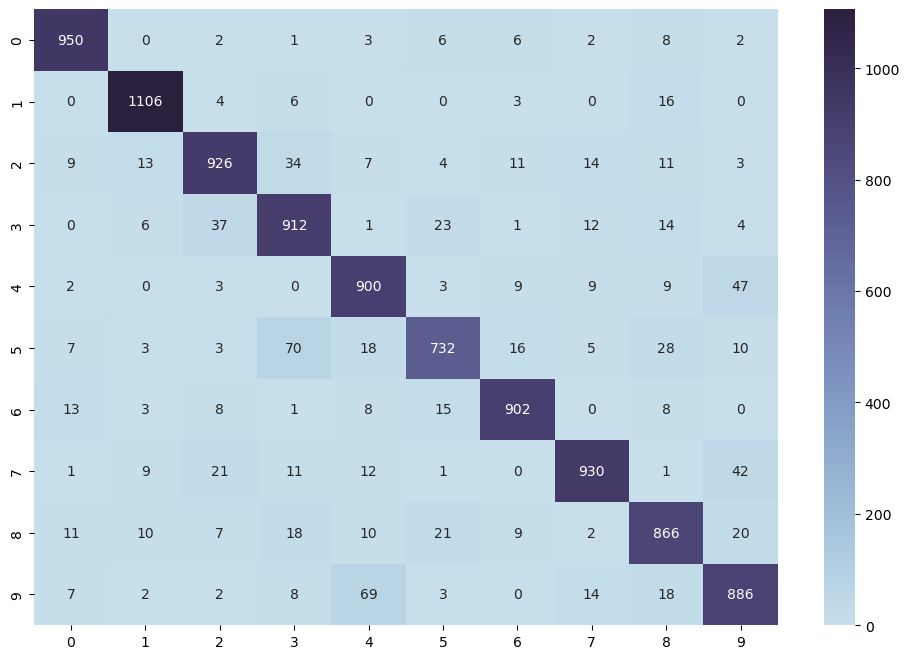

In [42]:
m = 'mnist_without_reg_loss_gate'
total_experts = 10
num_classes = 10
classes = range(10)
num_epochs = 100

w_importance_range = [0.0]
test_loader = testloader

plot_expert_usage(m, test_loader,w_importance_range=w_importance_range,
                  total_experts=total_experts,num_classes=num_classes,
                 classes=classes, num_epochs=num_epochs, fig_path=fig_path,
                  model_path=model_path, device=device)

mnist_with_reg_hidden_32_importance_0.2_10_5_models.pt
Min Training Error 0.015
Mutual Information 2.252
Sample Entropy 0.056
Expert Usage 2.320
mnist_with_reg_hidden_32_importance_0.2_10_5_models.pt


<Figure size 640x480 with 0 Axes>

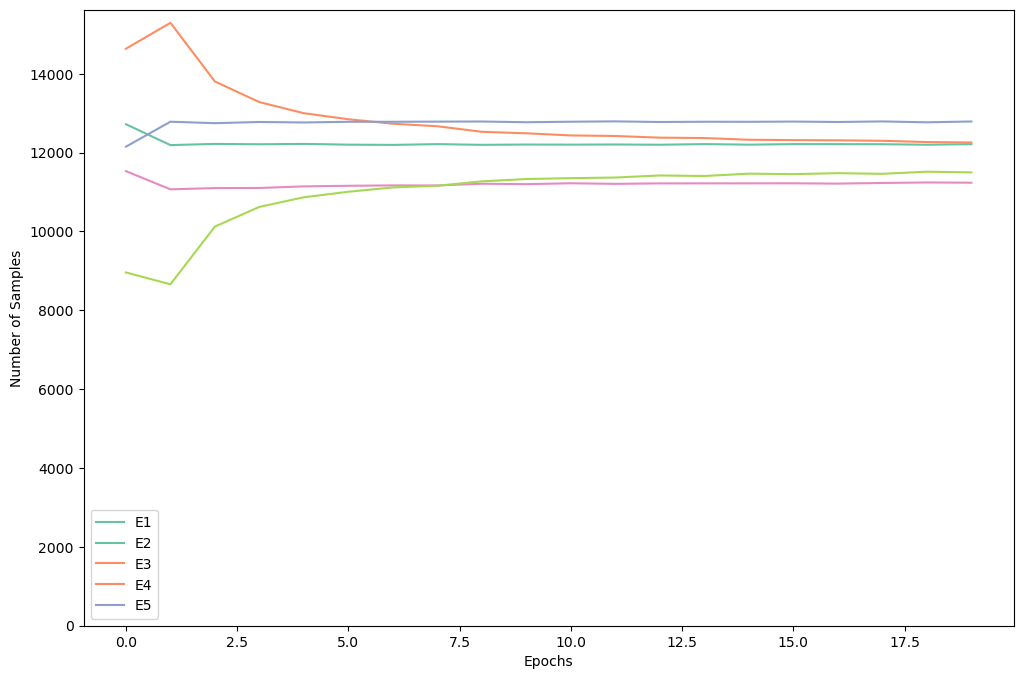

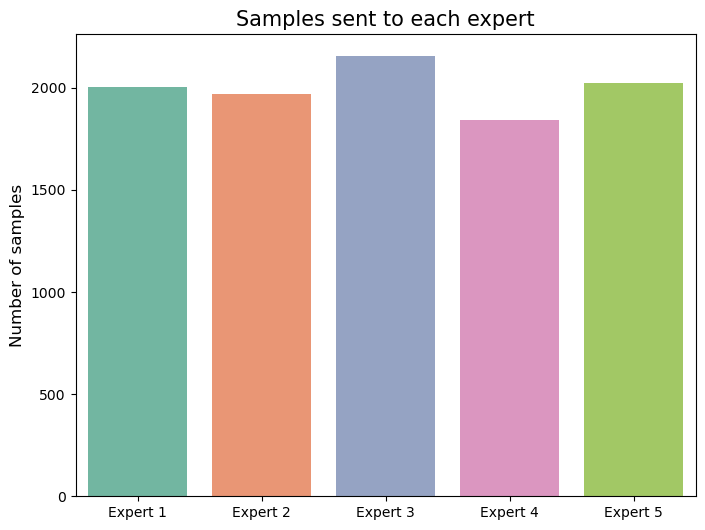

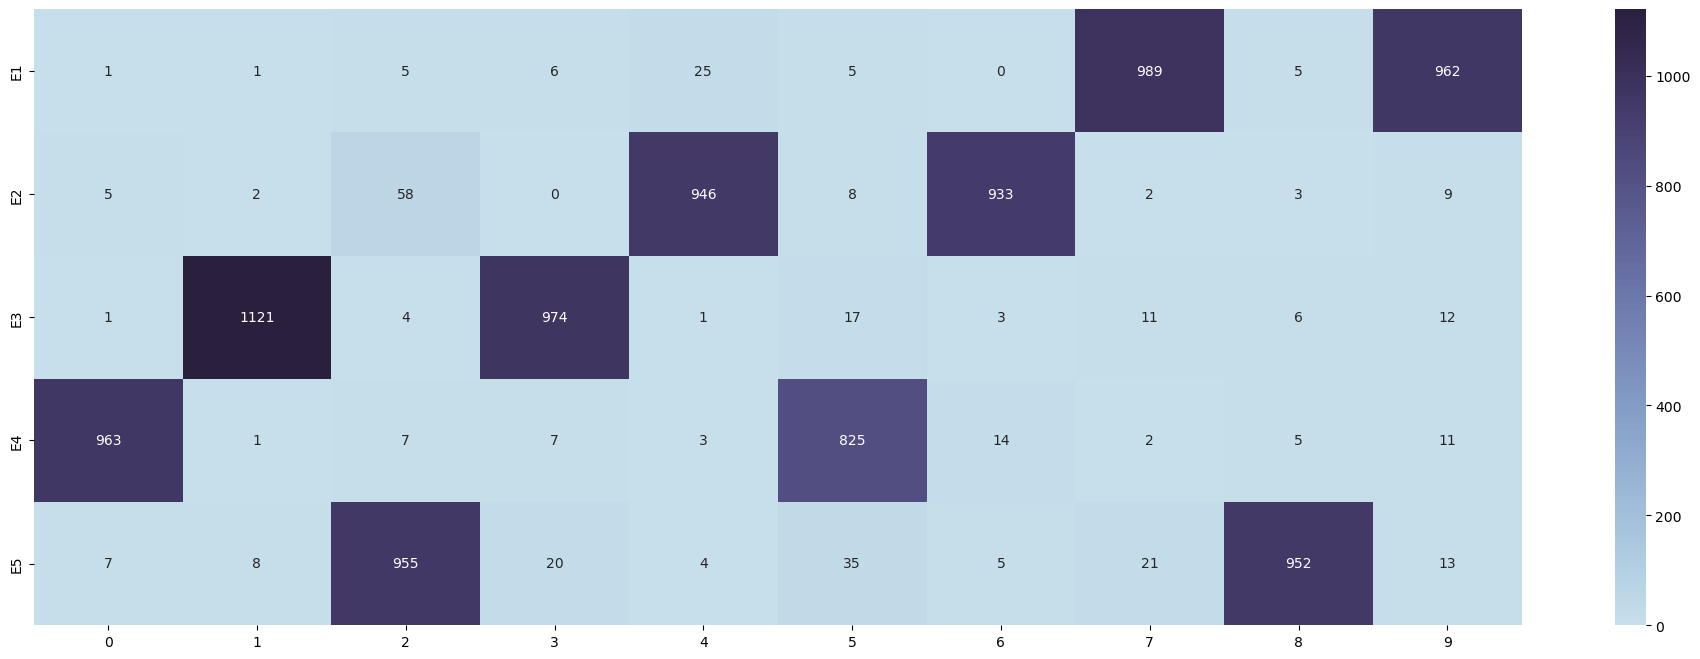


Experts used by the gate for classification of each class


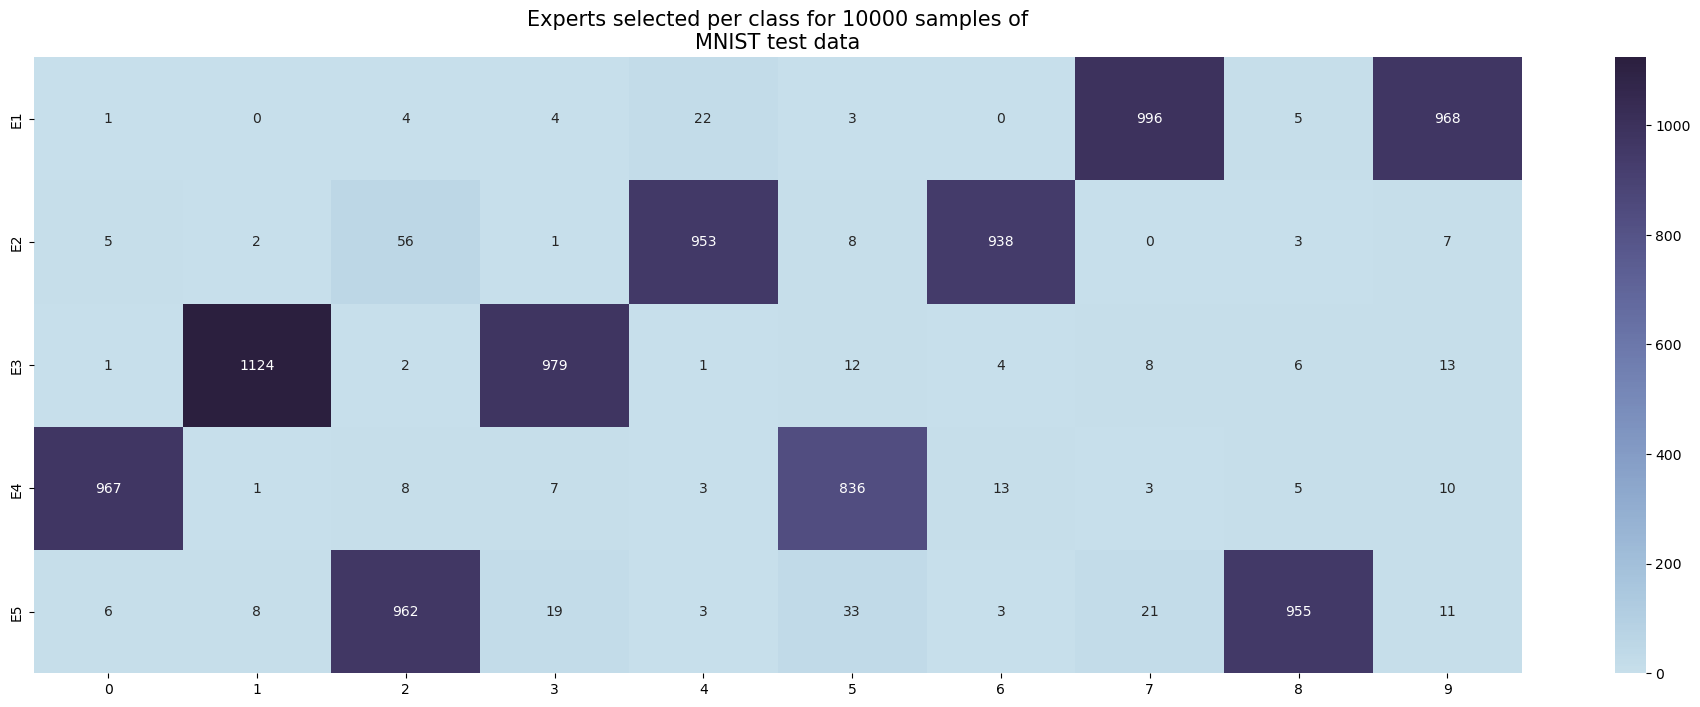

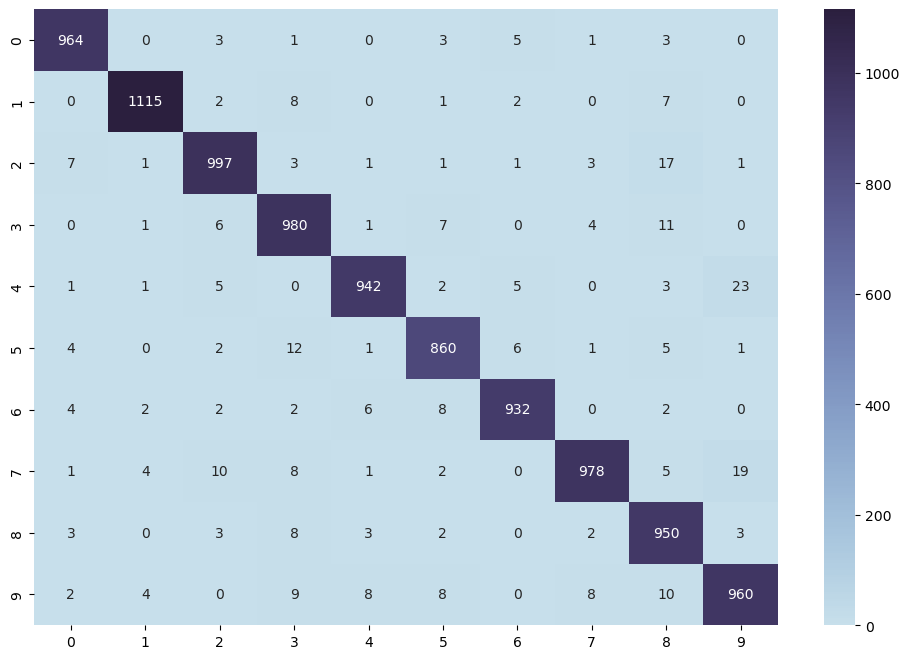

In [44]:
m = 'mnist_with_reg_hidden_32'
total_experts = 5
num_classes = 10
classes = range(10)
num_epochs = 20

w_importance_range = [0.2]                           

test_loader = testloader

plot_expert_usage(m, test_loader, w_importance_range=w_importance_range,
                  total_experts=total_experts,num_classes=num_classes,
                 classes=classes, num_epochs=num_epochs, fig_path=fig_path,
                  model_path=model_path, device=device)

Min Training Error 0.015
Mutual Information 2.245
Sample Entropy 0.047
Expert Usage 2.247
new_mnist_with_reg_hidden_32_sample_sim_same_1e-06_sample_sim_diff_1e-06_10_5_models.pt


<Figure size 640x480 with 0 Axes>

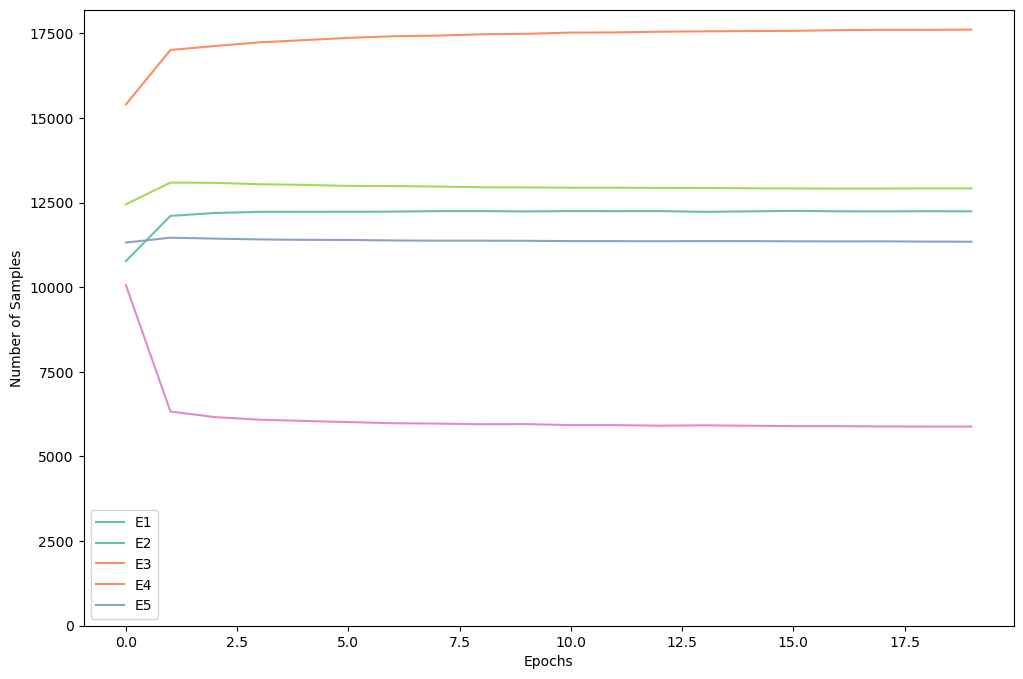

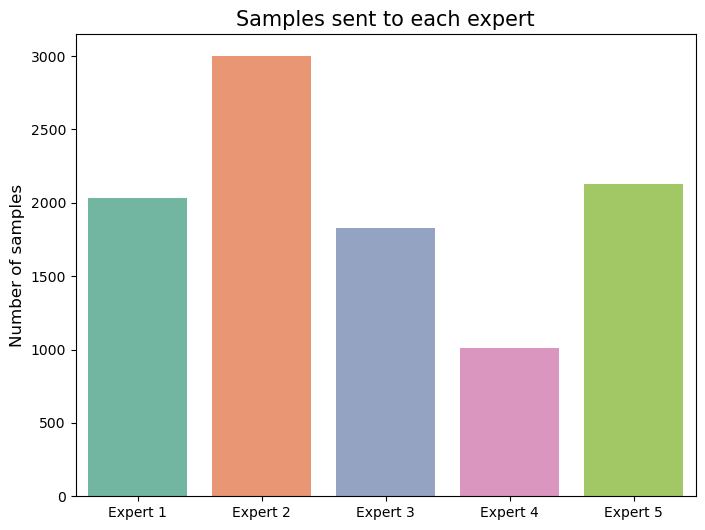

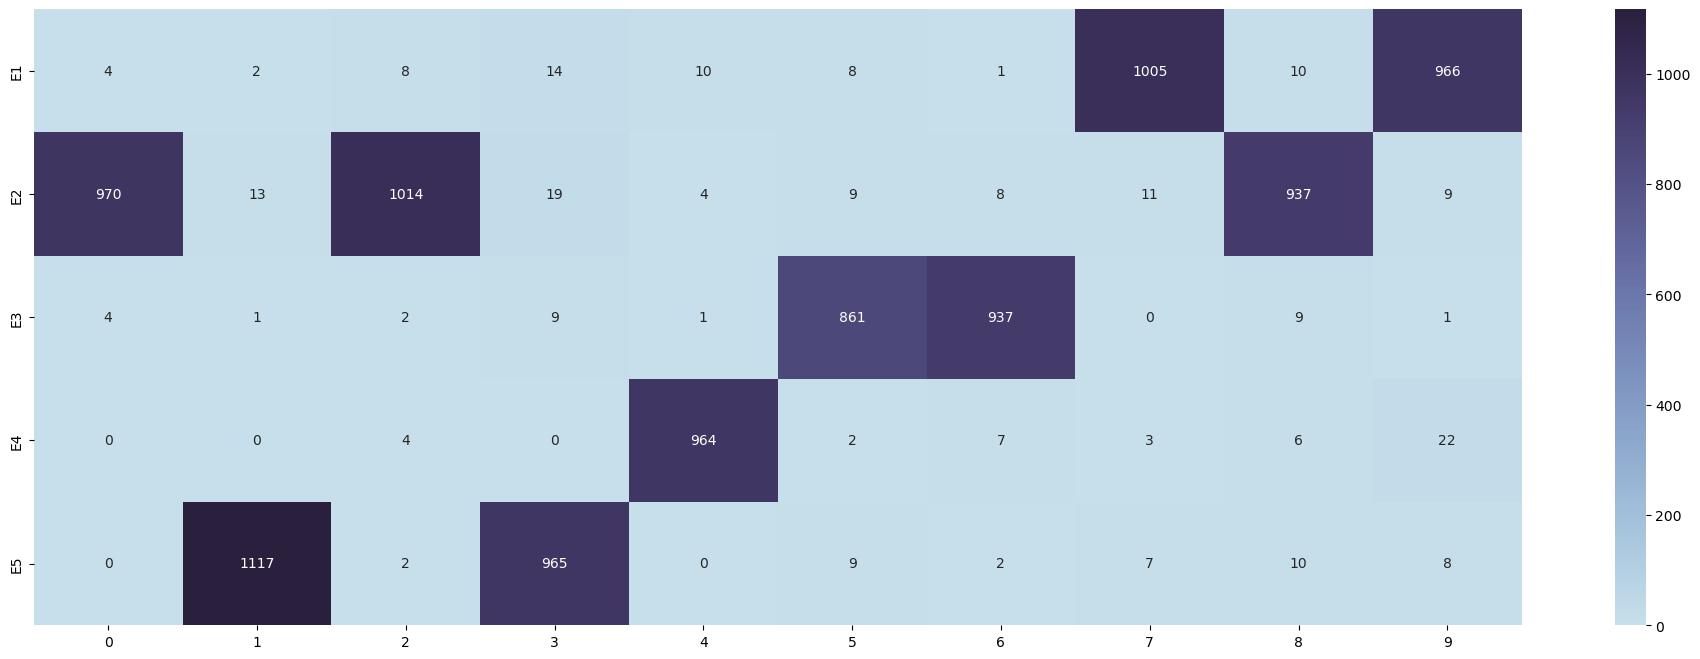


Experts used by the gate for classification of each class


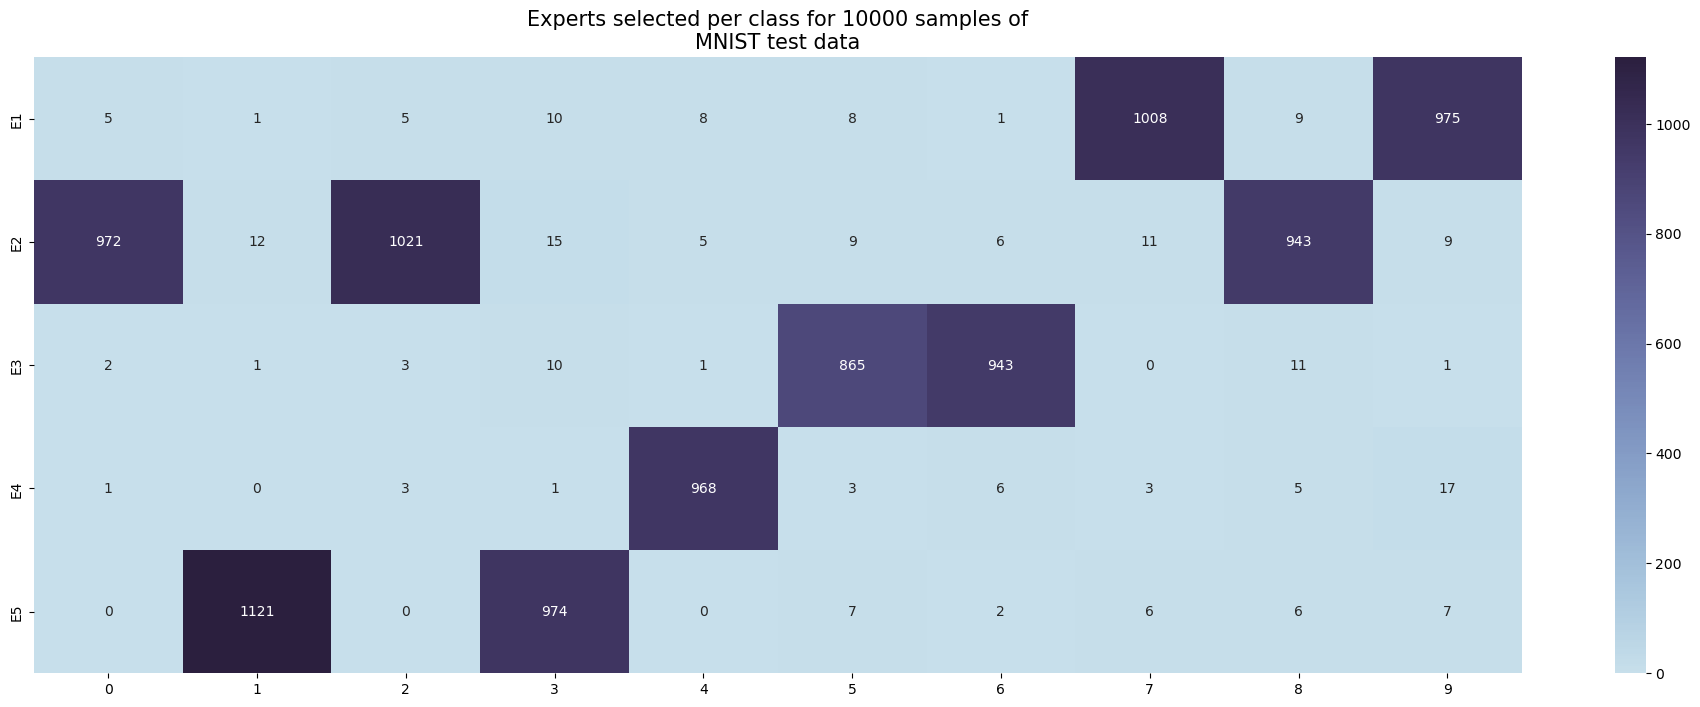

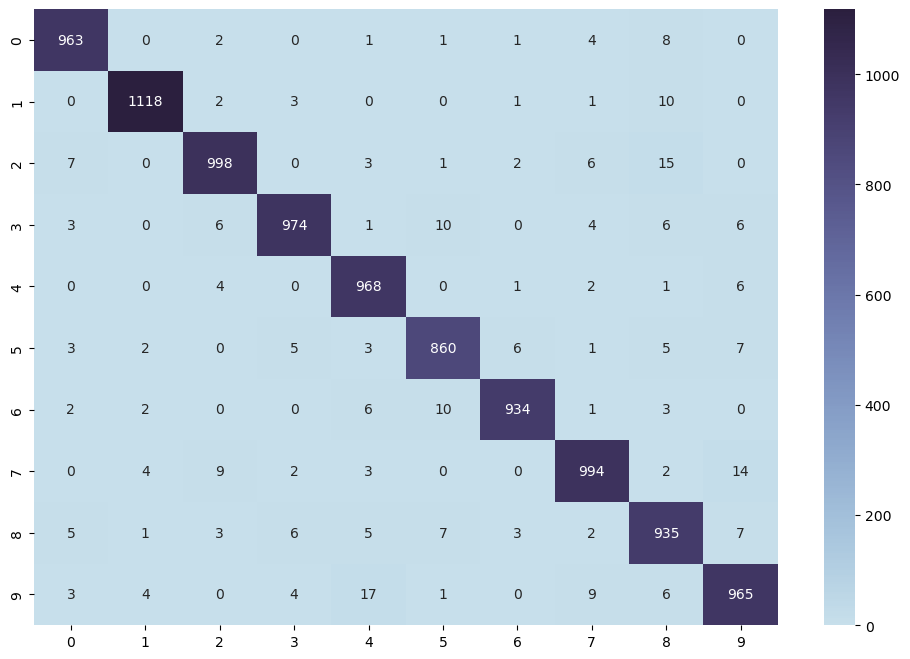

In [47]:
m = 'new_mnist_with_reg_hidden_32'
total_experts = 5
num_classes = 10
classes = range(10)
num_epochs = 20

w_sample_sim_same_range = [1e-6]
w_sample_sim_diff_range = [1e-6]                        

test_loader = testloader

plot_expert_usage(m, test_loader, 
                  w_sample_sim_same_range=w_sample_sim_same_range,
                  w_sample_sim_diff_range = w_sample_sim_diff_range,
                  total_experts=total_experts,num_classes=num_classes,
                 classes=classes, num_epochs=num_epochs, fig_path=fig_path,
                  model_path=model_path, device=device)

10000
mnist_without_reg_10_10_models.pt
Min Training Error 0.047
Mutual Information 1.567
Sample Entropy 0.031
Expert Usage 1.571
mnist_without_reg_10_10_models.pt


<Figure size 640x480 with 0 Axes>

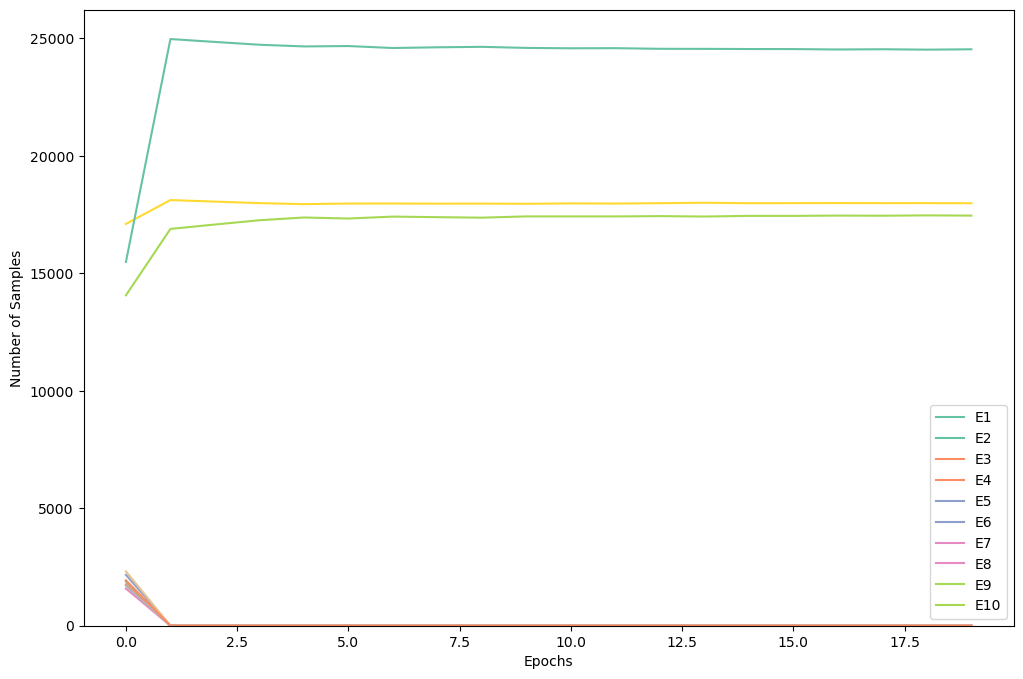

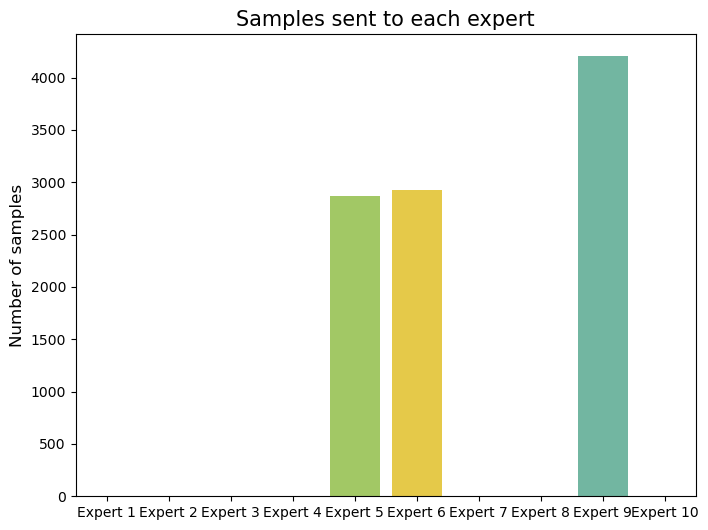

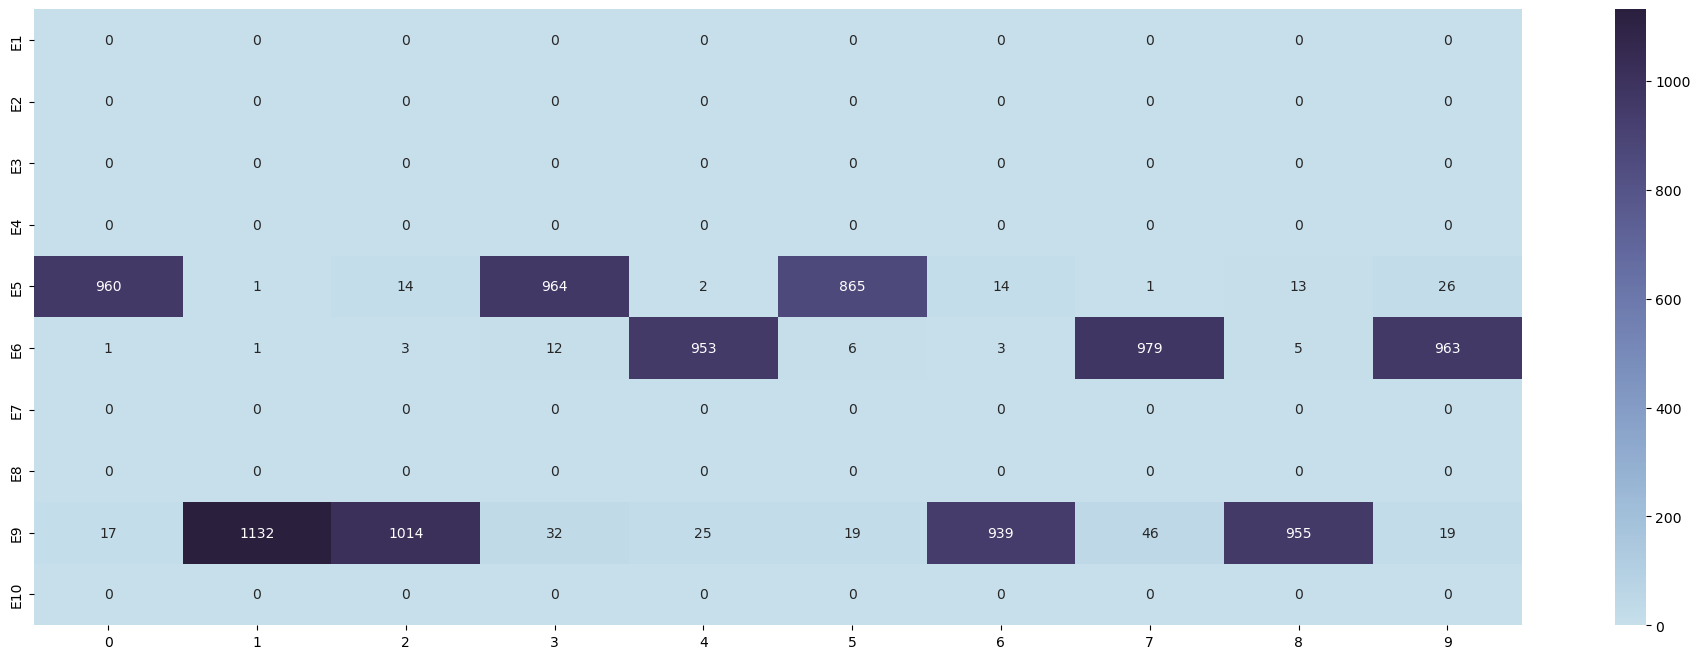


Experts used by the gate for classification of each class


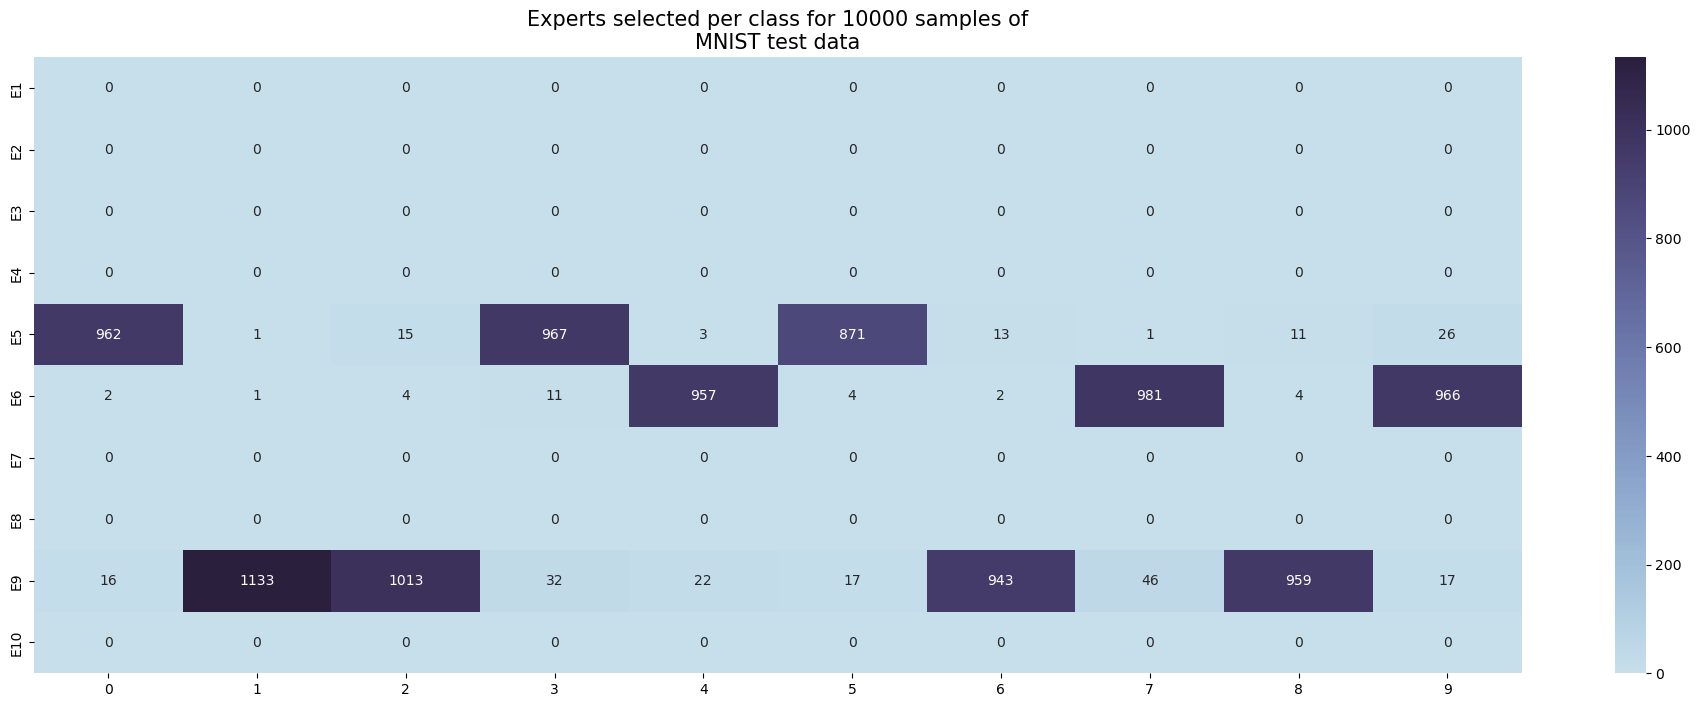

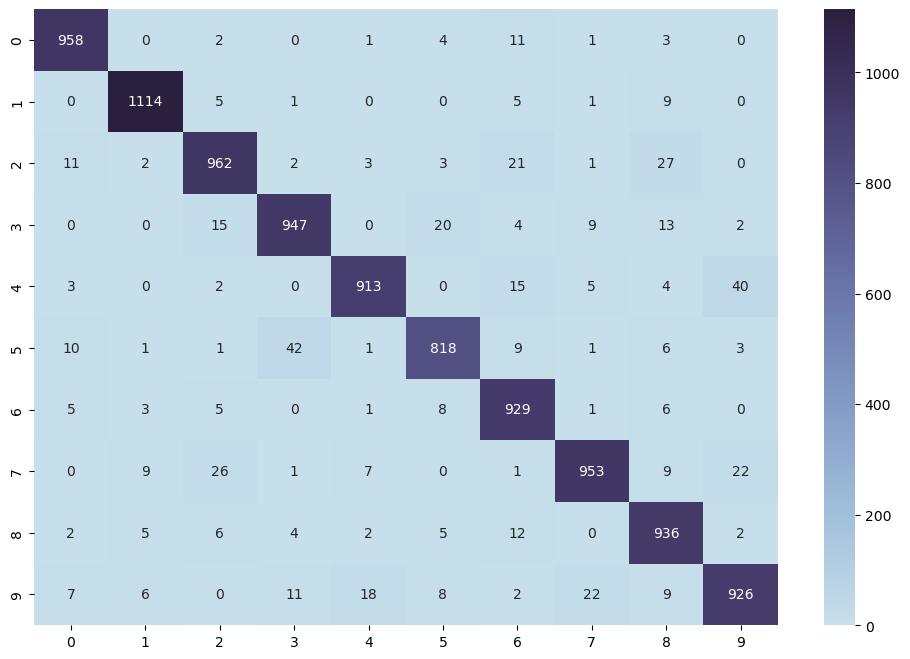

In [33]:
m = 'mnist_without_reg'
total_experts = 10
num_classes = 10
classes = range(10)
num_epochs = 20

w_importance_range = [0.0]
test_loader = testloader
print(len(test_loader.dataset))
plot_expert_usage(m, test_loader,w_importance_range=w_importance_range,
                  total_experts=total_experts,num_classes=num_classes,
                 classes=classes, num_epochs=num_epochs, fig_path=fig_path,
                  model_path=model_path, device=device)

new_mnist_with_attention_hidden_32_10_5_models.pt
Min Training Error 0.019
Mutual Information 1.797
Sample Entropy 0.067
Expert Usage 2.064
new_mnist_with_attention_hidden_32_10_5_models.pt


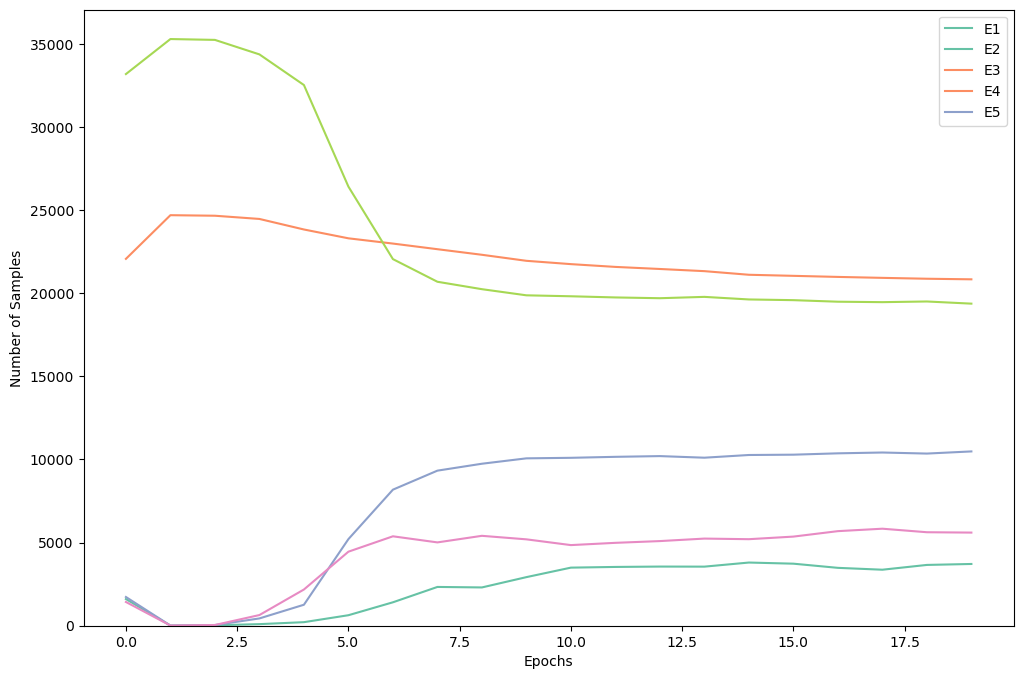

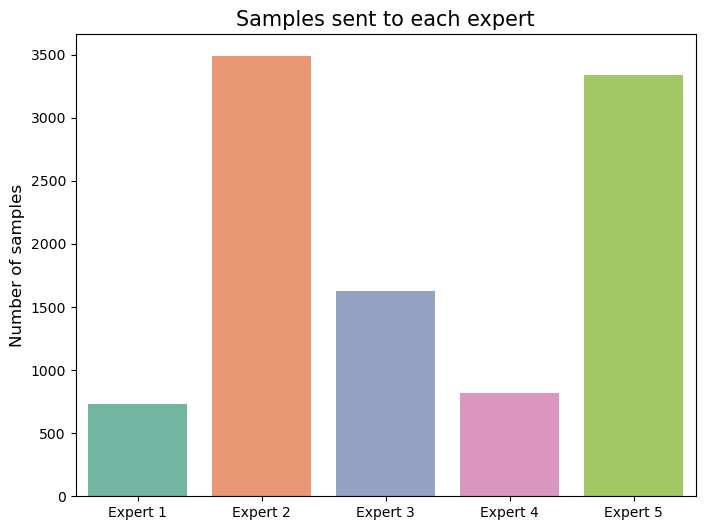

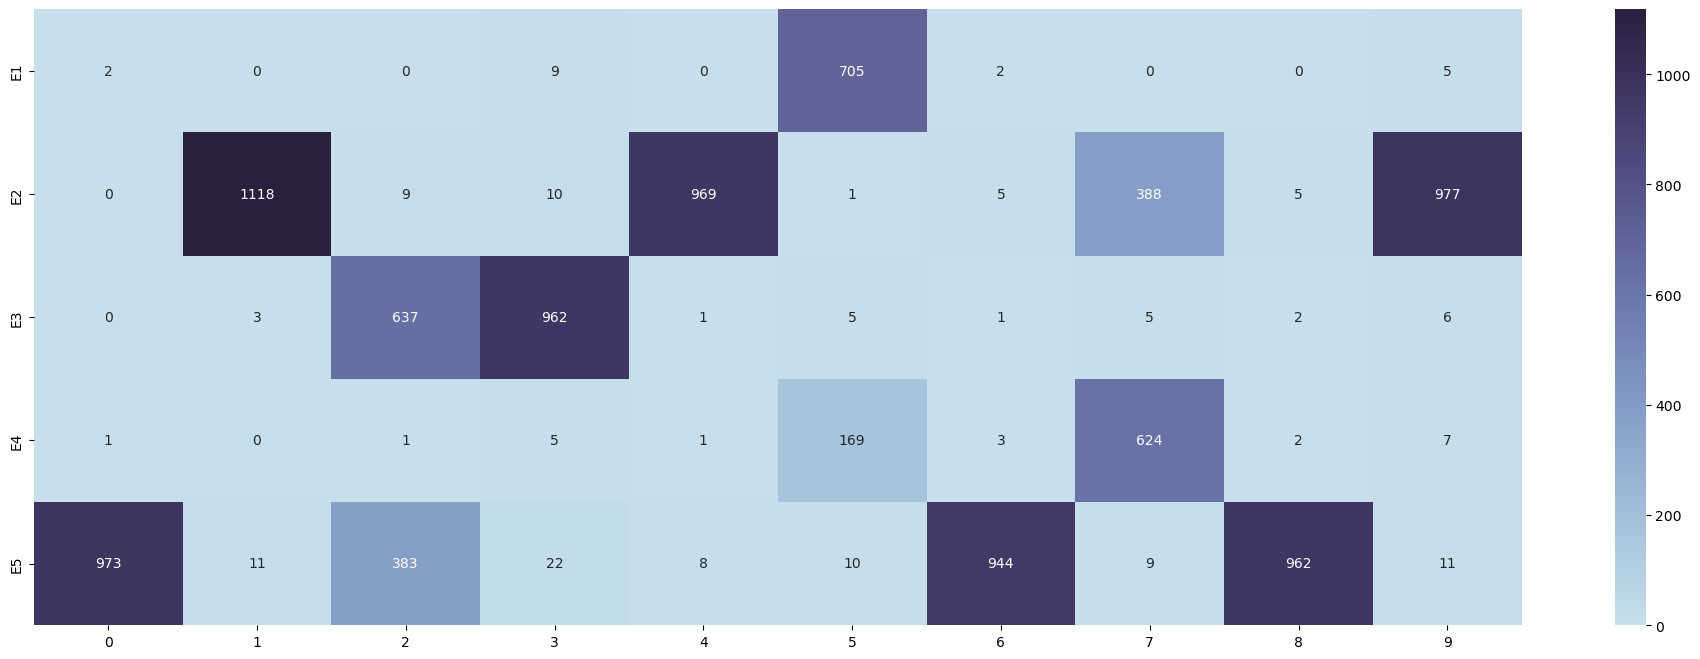


Experts used by the gate for classification of each digit


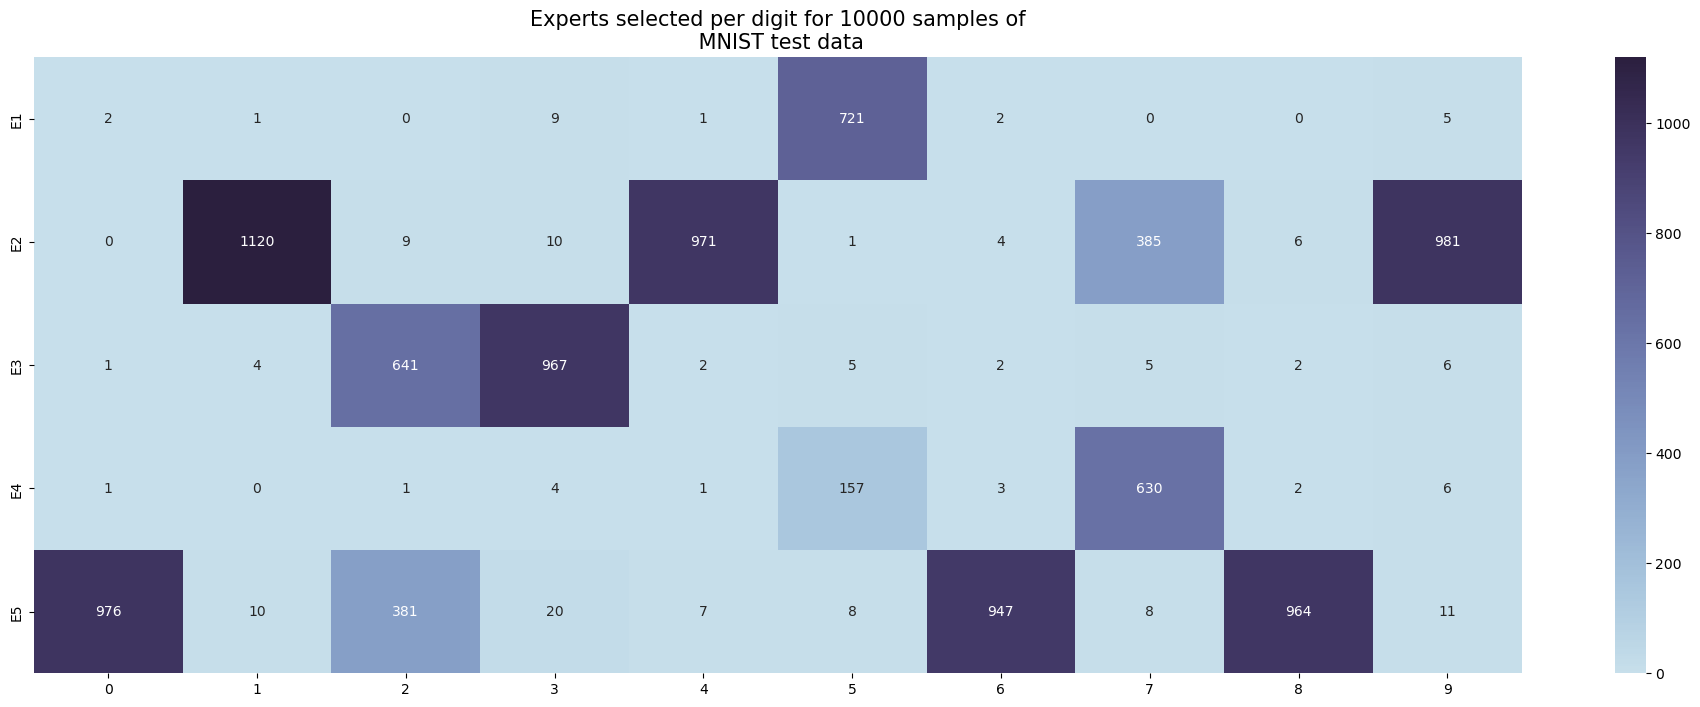

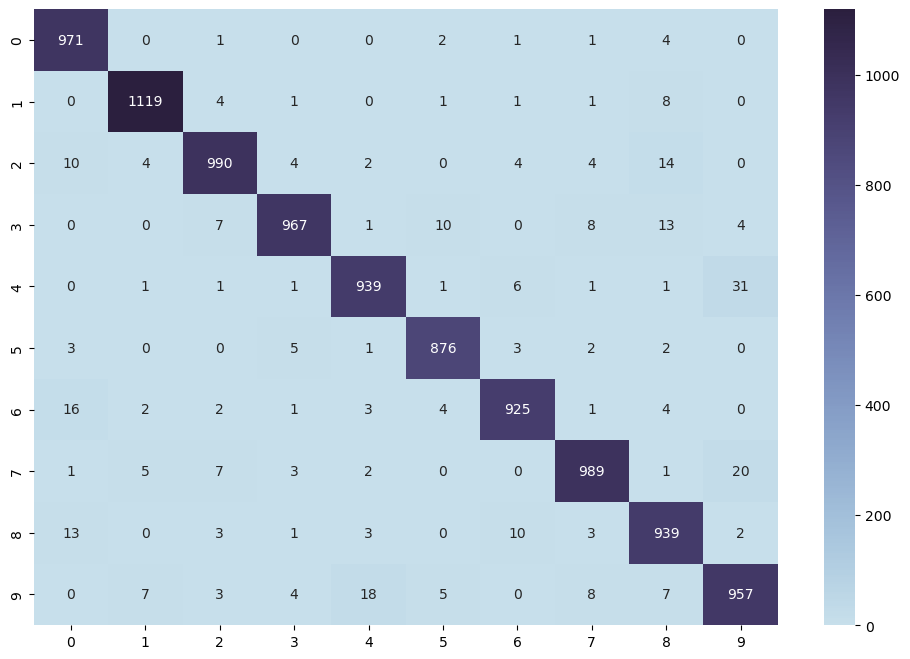

In [20]:
m = 'new_mnist_with_attention_hidden_32'
total_experts = 5
num_classes = 10
classes = range(10)
num_epochs = 20

w_importance_range = [0.0]
test_loader = testloader

plot_expert_usage(m, test_loader,w_importance_range=w_importance_range,
                  total_experts=total_experts,num_classes=num_classes,
                 classes=classes, num_epochs=num_epochs, fig_path=fig_path,
                  model_path=model_path, device=device)

new_mnist_with_reg_hidden_32_importance_0.2_10_5_models.pt
Min Training Error 0.015
Mutual Information 2.252
Sample Entropy 0.056
Expert Usage 2.320
new_mnist_with_reg_hidden_32_importance_0.2_10_5_models.pt


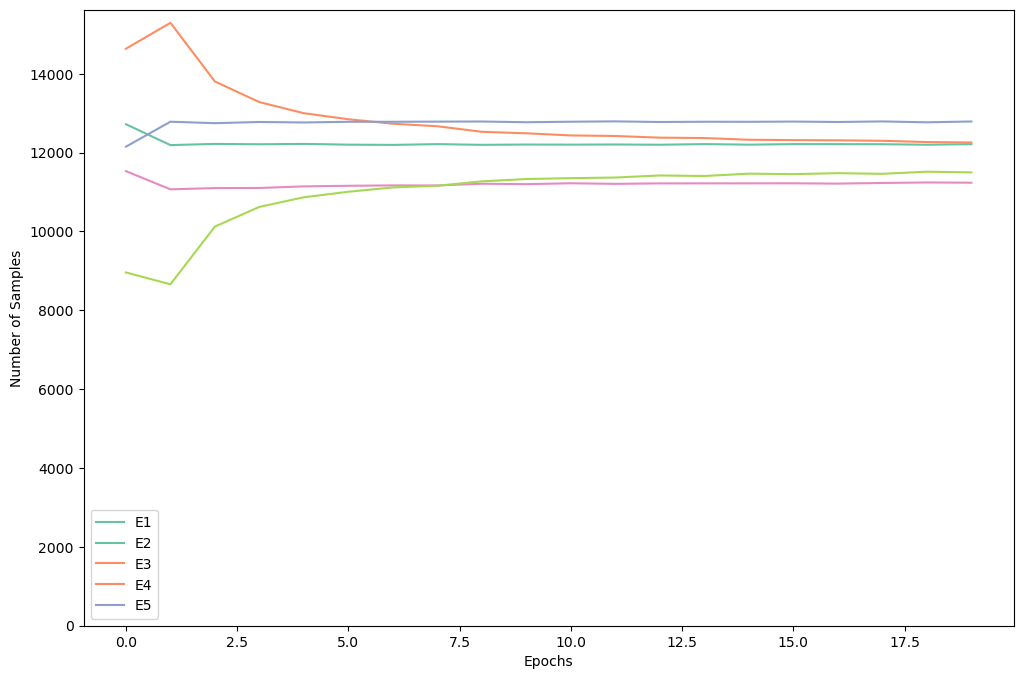

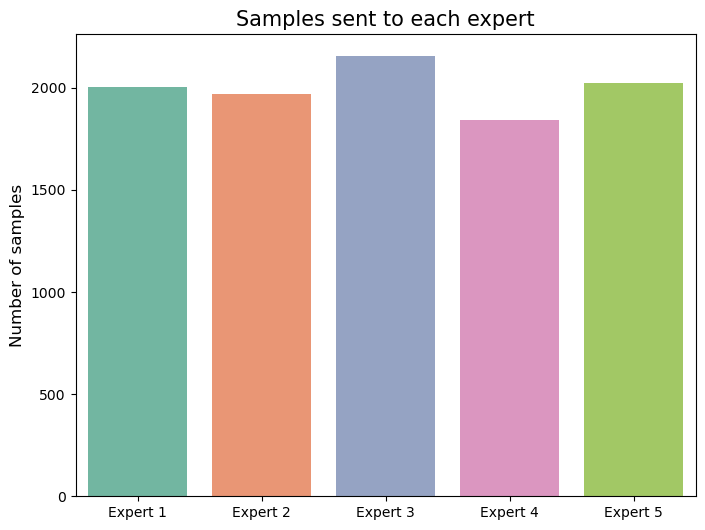

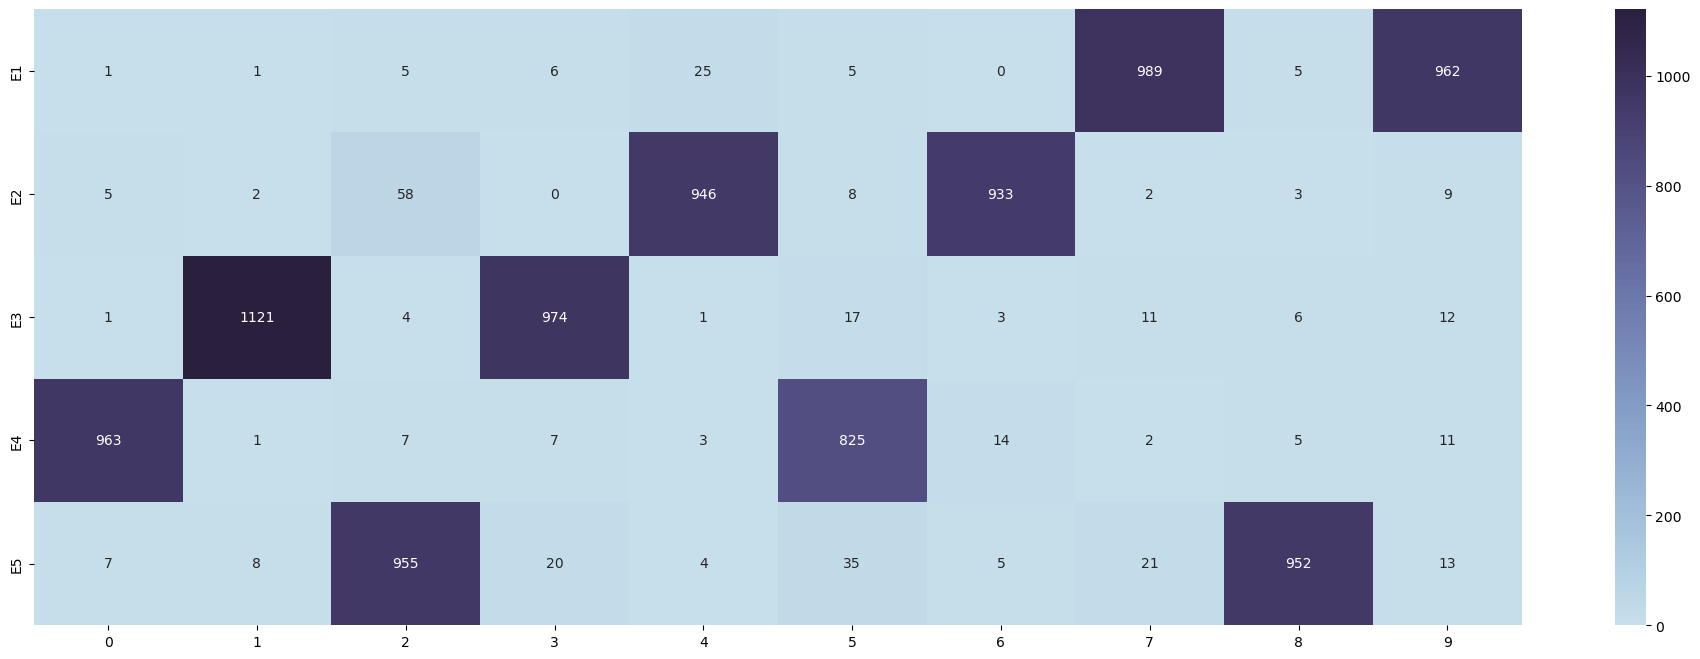


Experts used by the gate for classification of each digit


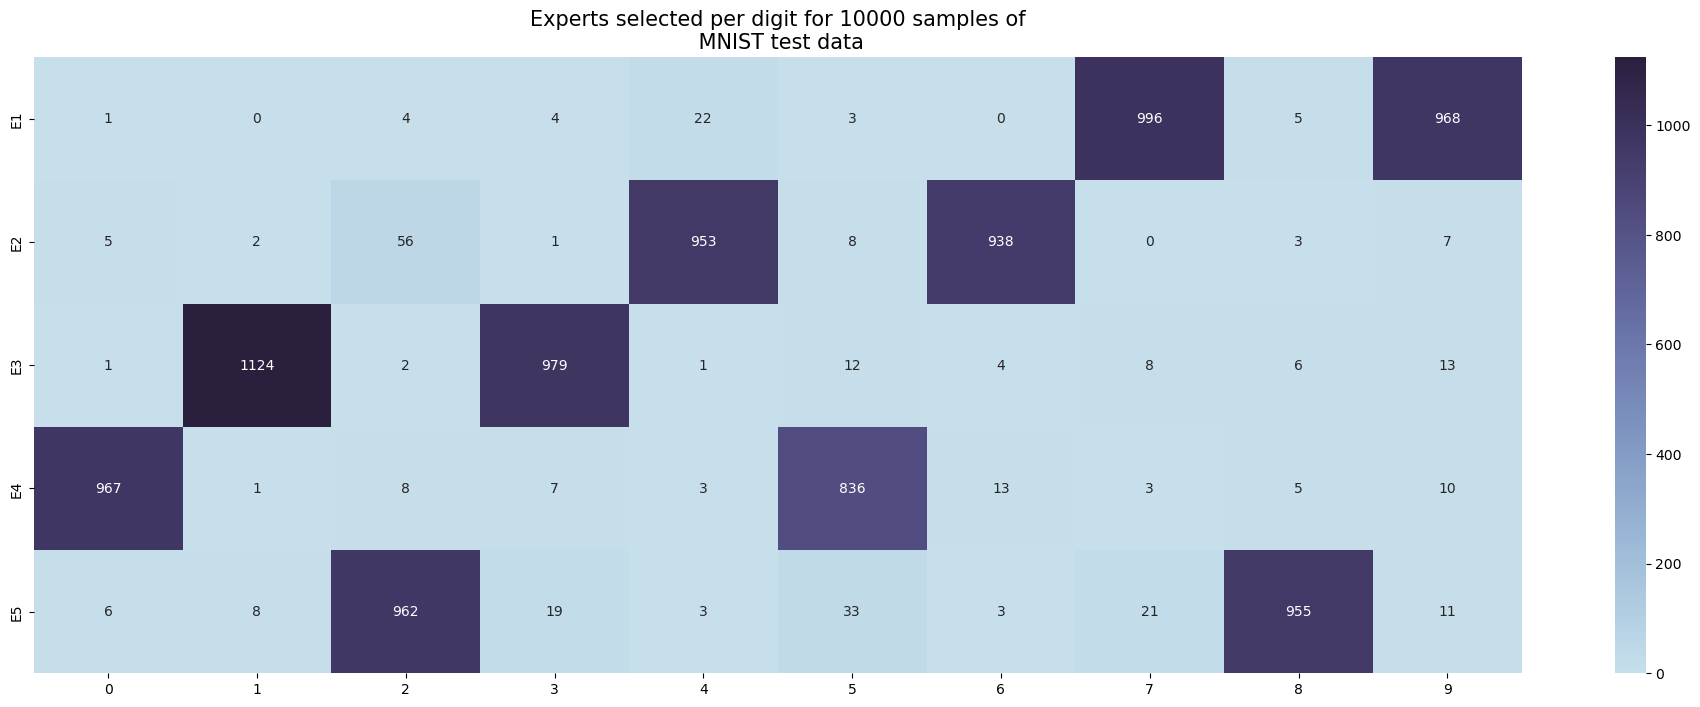

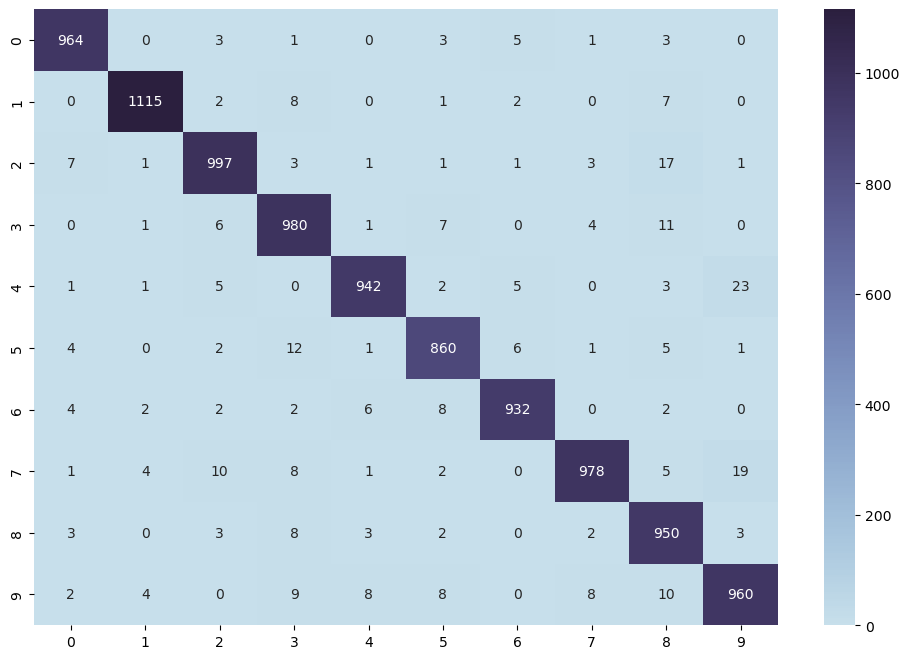

In [31]:
m = 'new_mnist_with_reg_hidden_32'
w_importance_range = [0.2]

total_experts = 5
num_classes = 10
classes = range(10)
num_epochs = 20

test_loader = testloader

plot_expert_usage(m, test_loader,w_importance_range=w_importance_range,
                  total_experts=total_experts,num_classes=num_classes,
                 classes=classes, num_epochs=num_epochs, fig_path=fig_path,
                  model_path=model_path, device=device)


new_mnist_with_attn_reg_hidden_32_importance_0.2_10_5_models.pt
Min Training Error 0.013
Mutual Information 2.244
Sample Entropy 0.044
Expert Usage 2.252
new_mnist_with_attn_reg_hidden_32_importance_0.2_10_5_models.pt


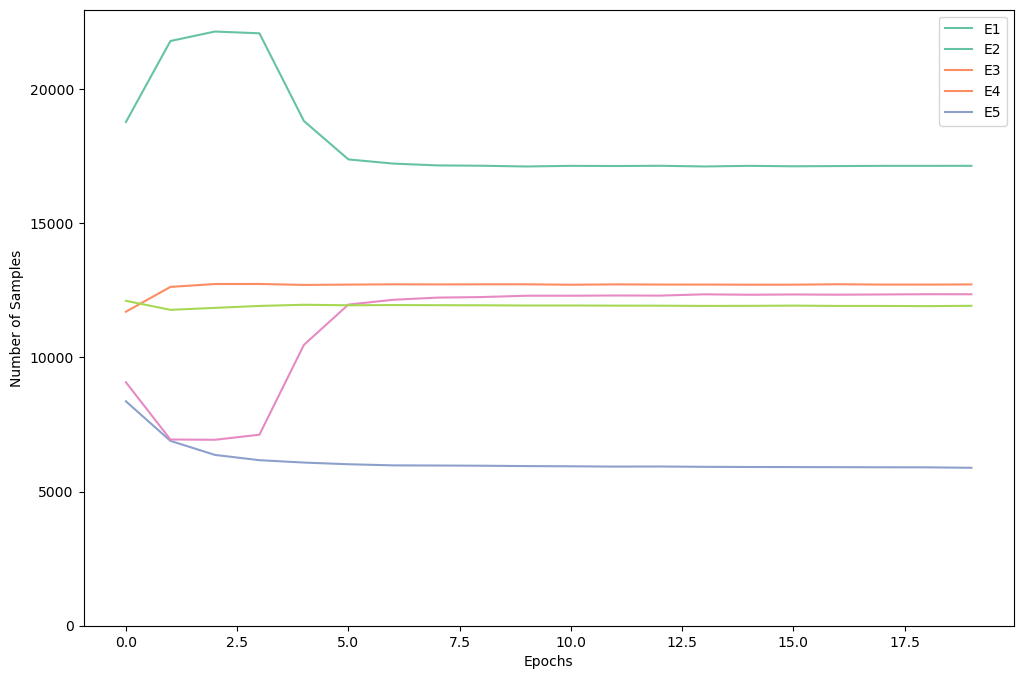

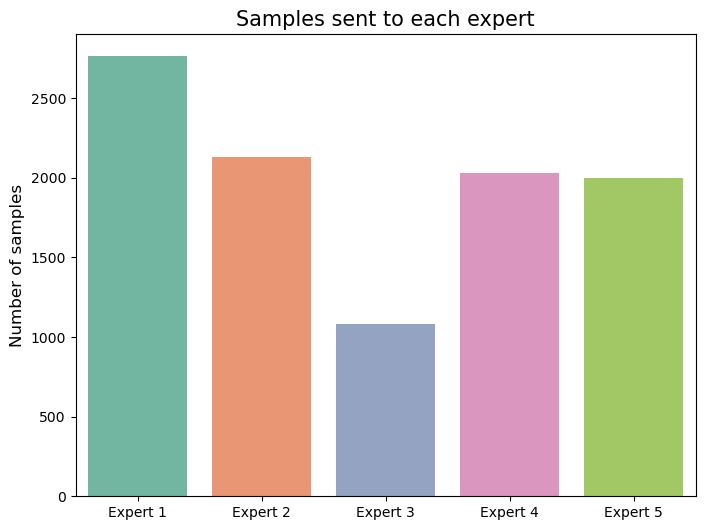

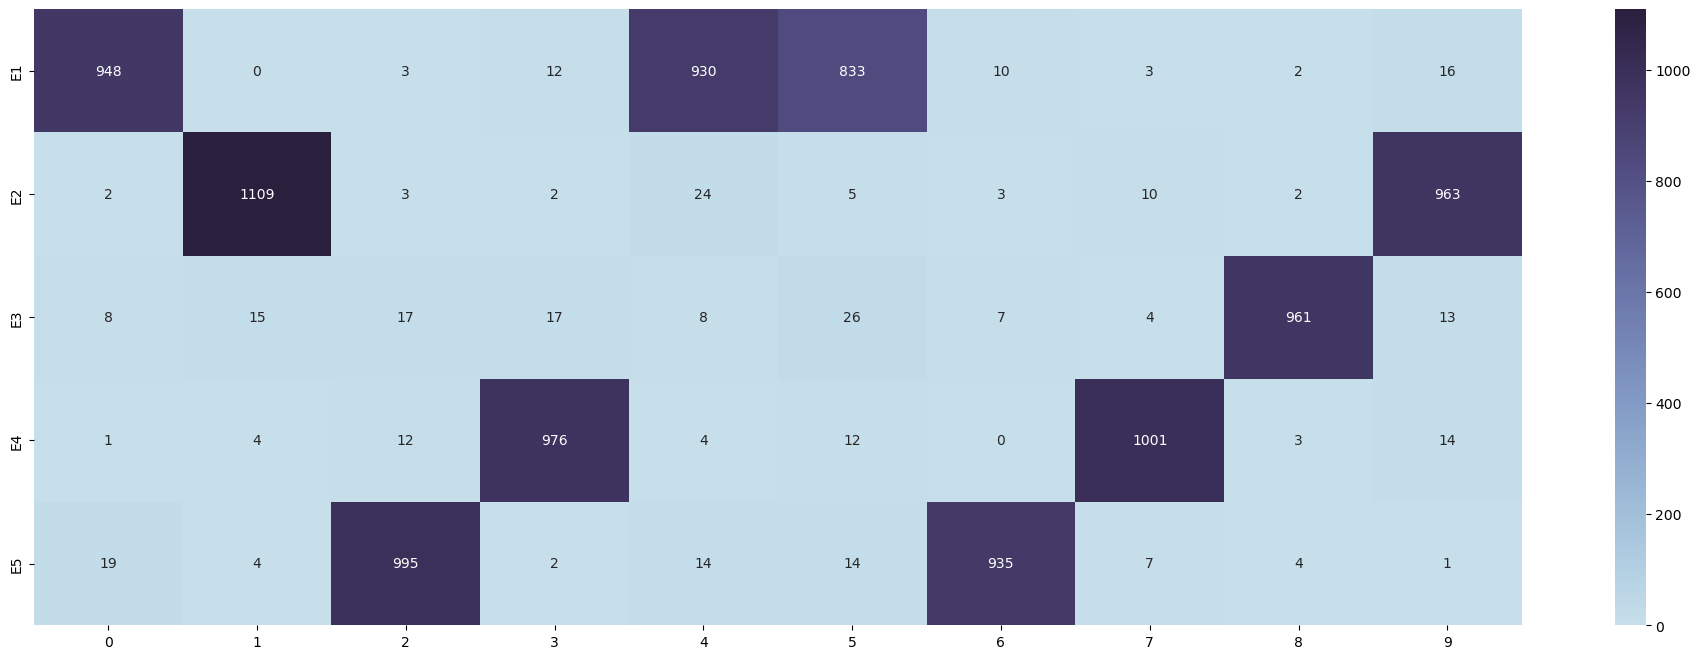


Experts used by the gate for classification of each digit


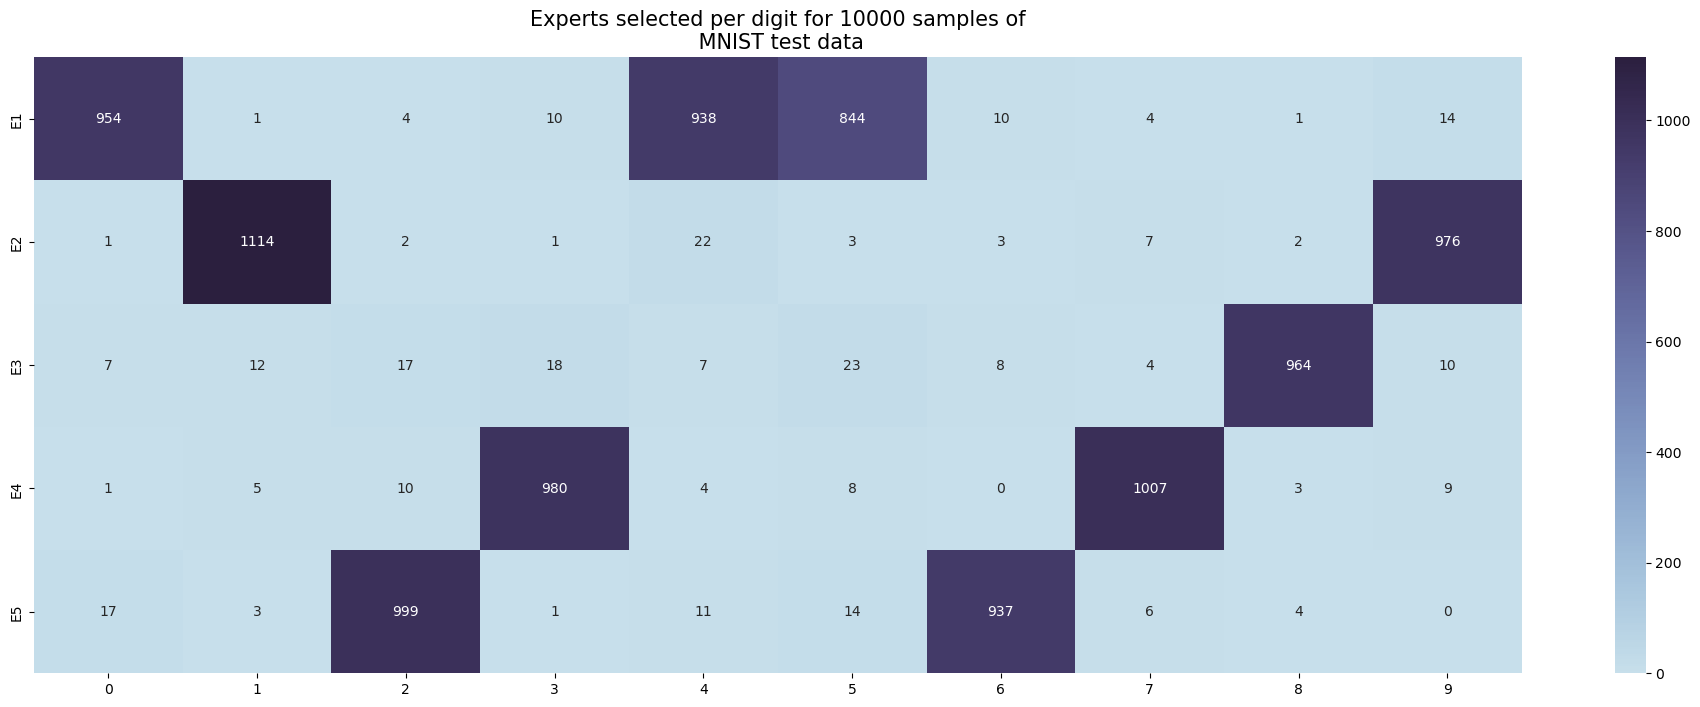

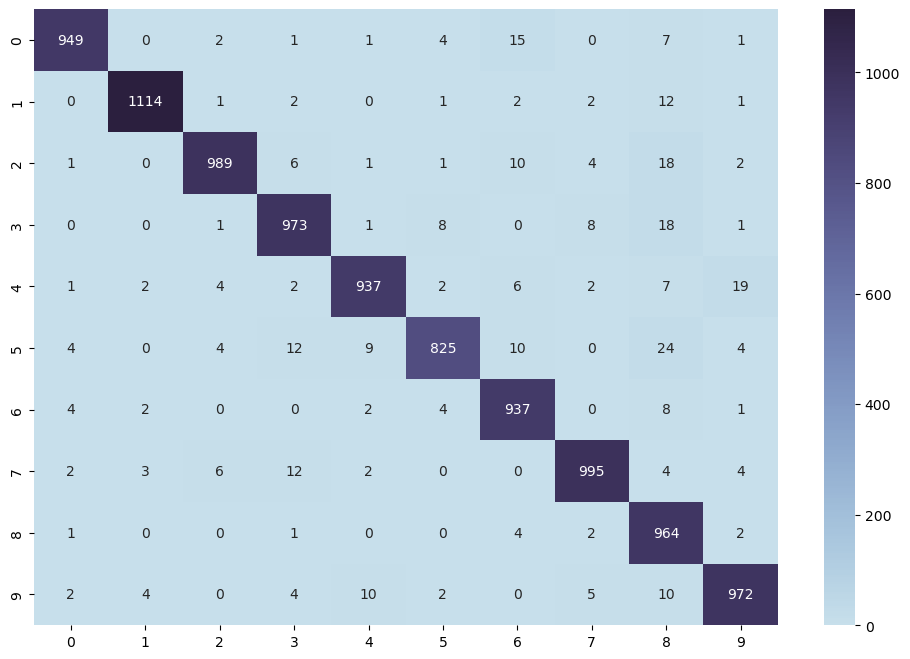

In [32]:
m = 'new_mnist_with_attn_reg_hidden_32'
w_importance_range = [0.2]

total_experts = 5
num_classes = 10
classes = range(10)
num_epochs = 20

test_loader = testloader

plot_expert_usage(m, test_loader,w_importance_range=w_importance_range,
                  total_experts=total_experts,num_classes=num_classes,
                 classes=classes, num_epochs=num_epochs, fig_path=fig_path,
                  model_path=model_path, device=device)


mnist_with_reg_hidden_32_importance_1.0_10_15_models.pt
Min Training Error 0.035
Mutual Information 2.348
Sample Entropy 0.463
Expert Usage 3.907
mnist_with_reg_hidden_32_importance_1.0_10_15_models.pt


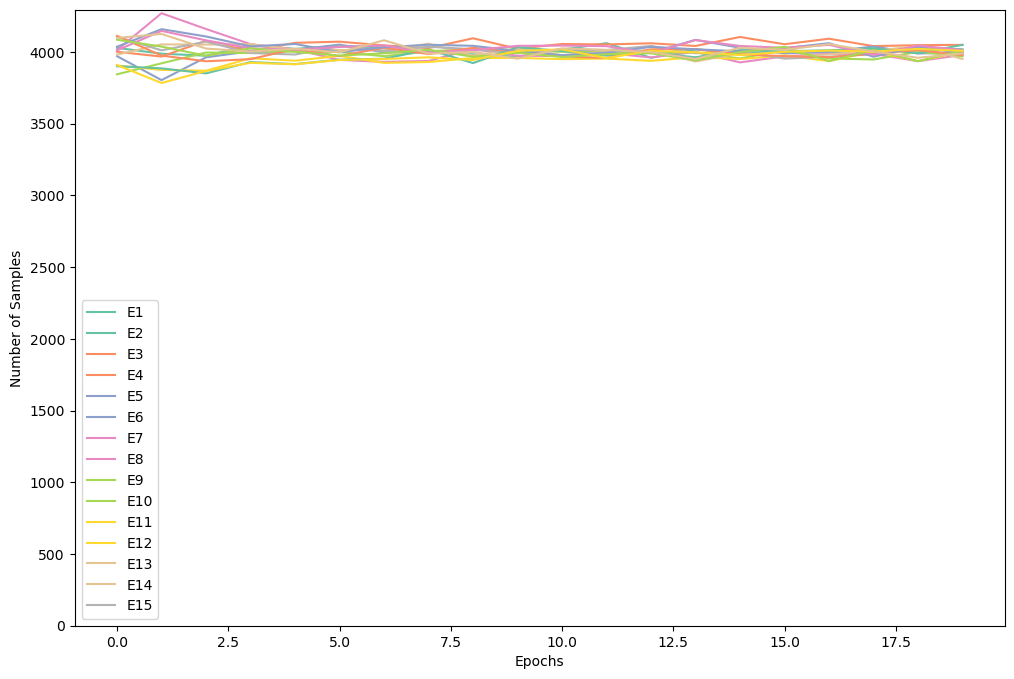

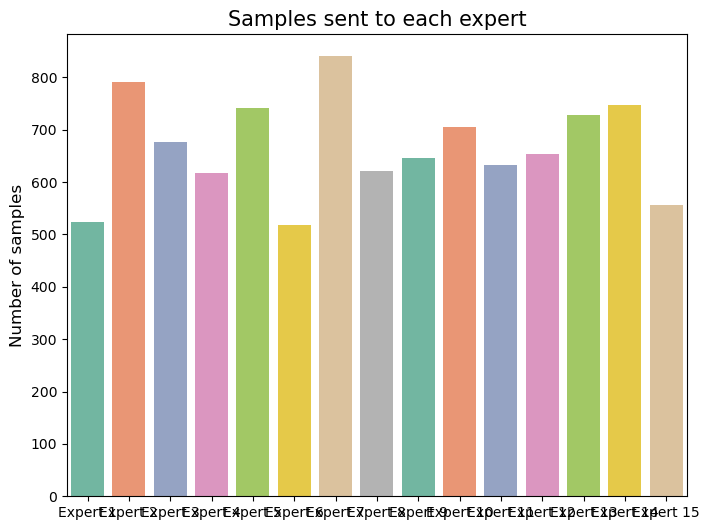

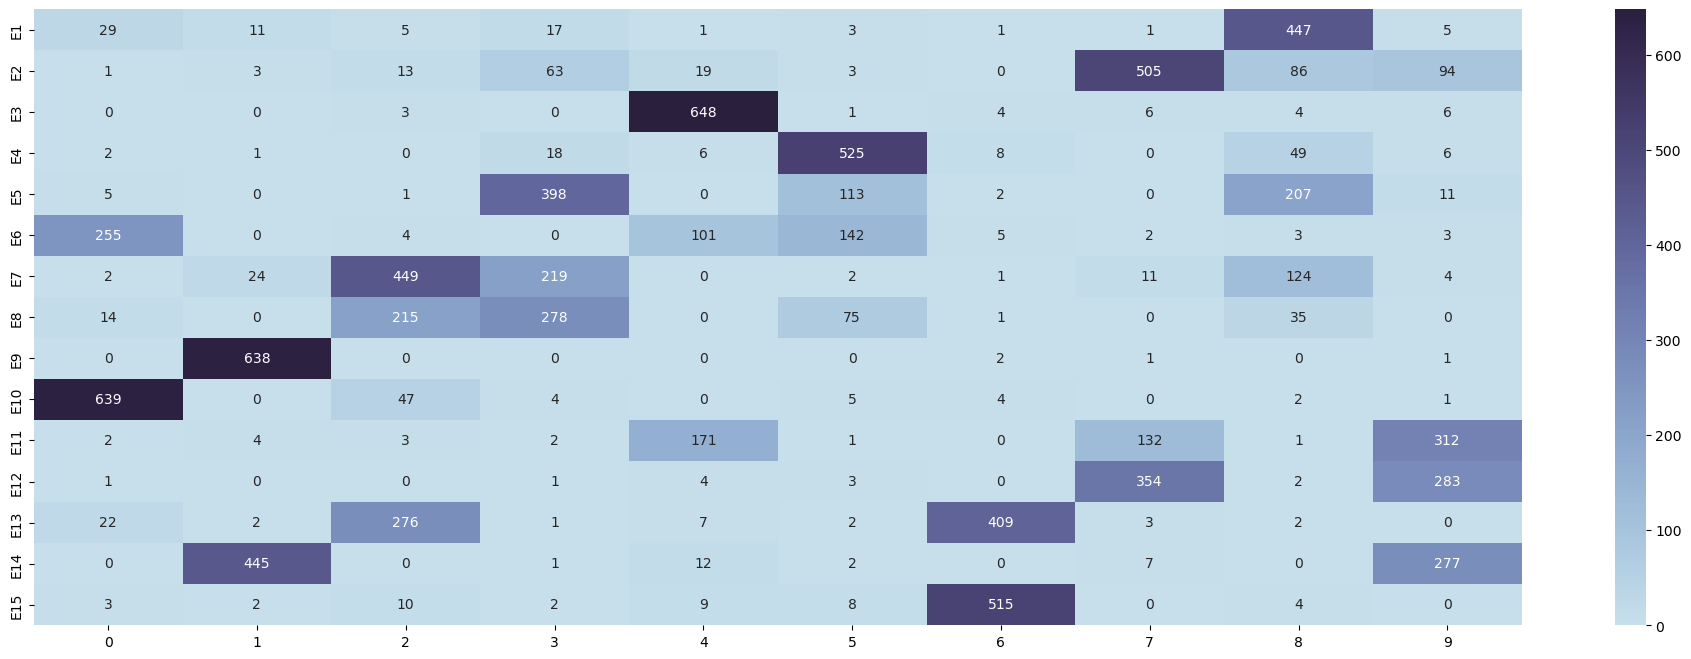


Experts used by the gate for classification of each digit


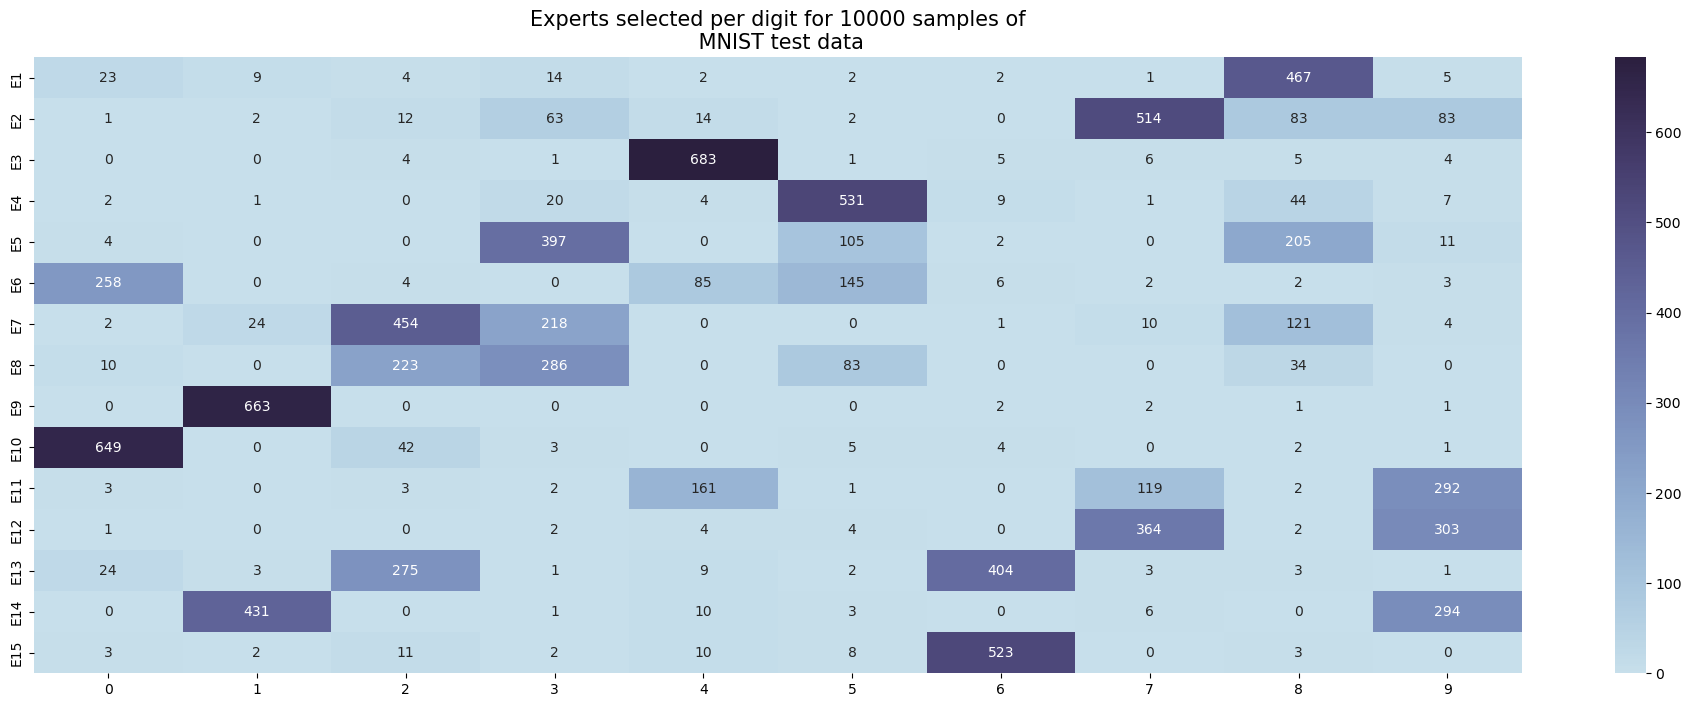

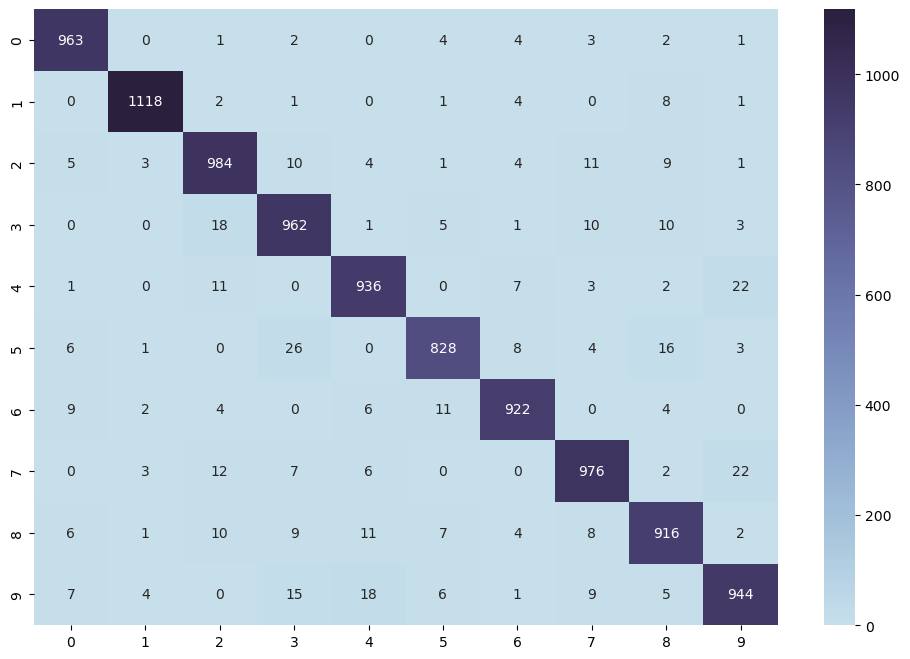

In [34]:
m = 'mnist_with_reg_hidden_32'
total_experts = 15
num_classes = 10
classes = range(10)
num_epochs = 20

w_importance_range = [1.0]                           

test_loader = testloader

plot_expert_usage(m, test_loader, w_importance_range=w_importance_range,
                  total_experts=total_experts,num_classes=num_classes,
                 classes=classes, num_epochs=num_epochs, fig_path=fig_path,
                  model_path=model_path, device=device)

Min Training Error 0.065
Mutual Information 0.819
Sample Entropy 0.025
Expert Usage 0.927
mnist_with_reg_hidden_32_sample_sim_same_1e-06_sample_sim_diff_1e-06_10_15_models.pt


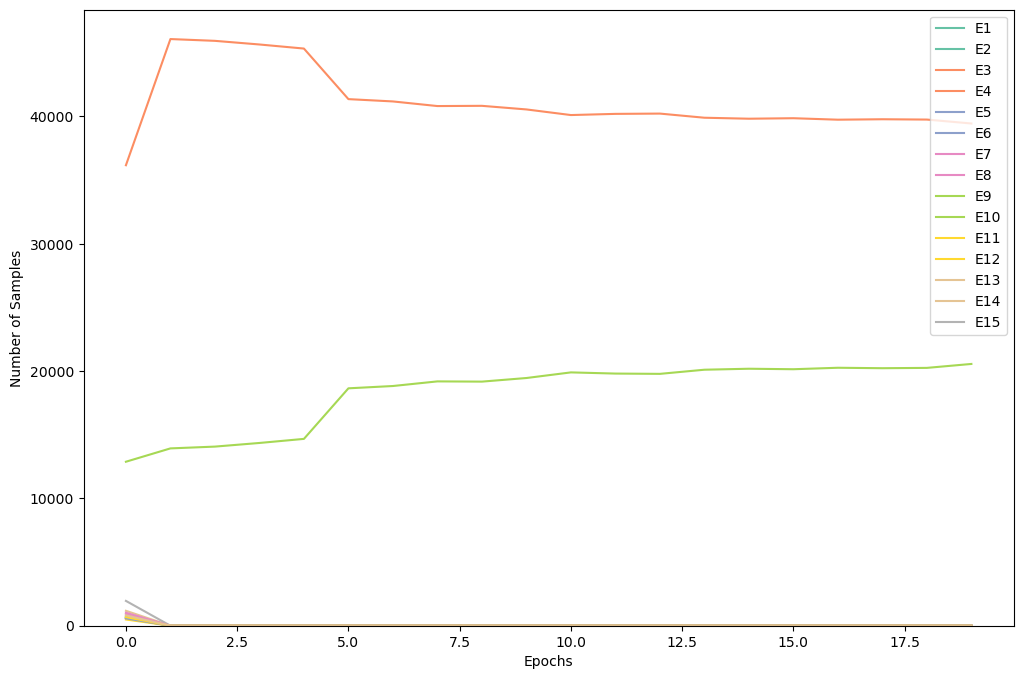

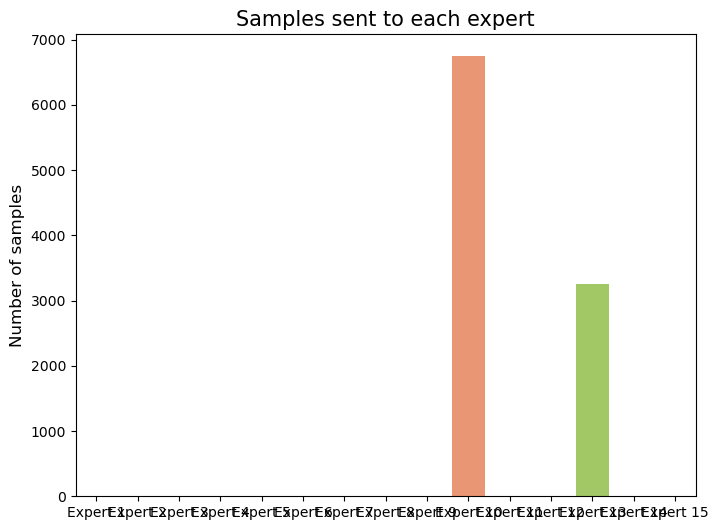

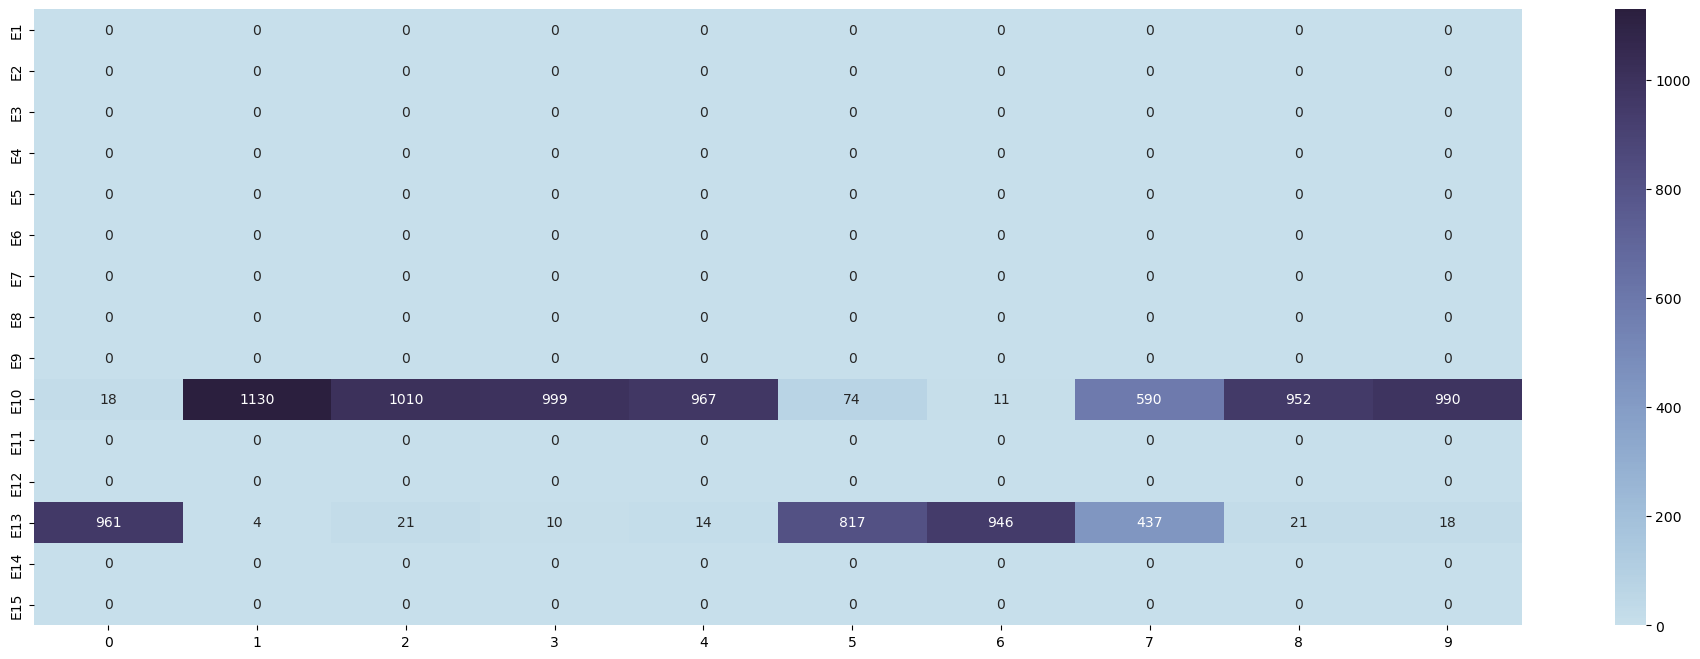


Experts used by the gate for classification of each digit


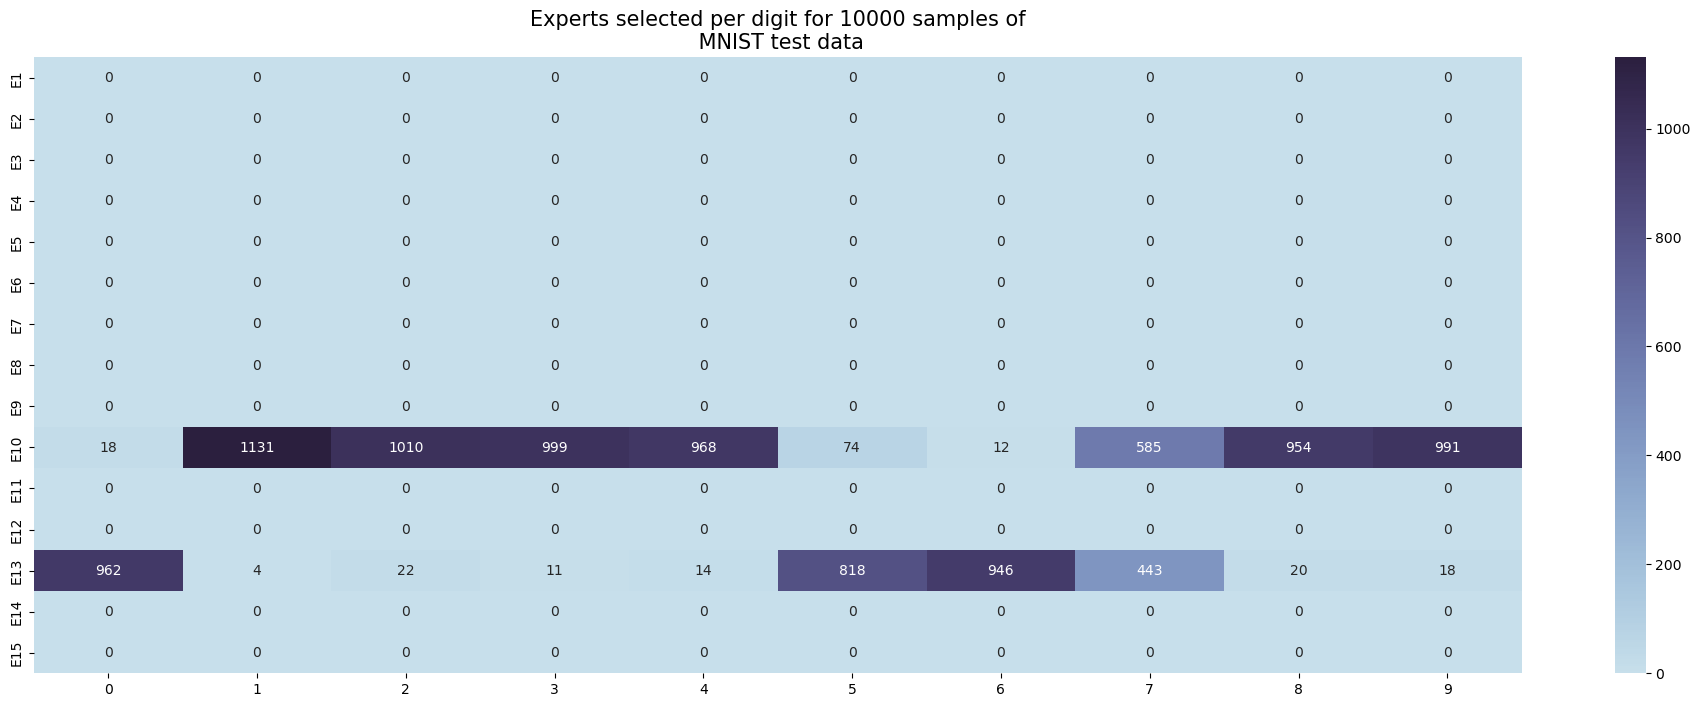

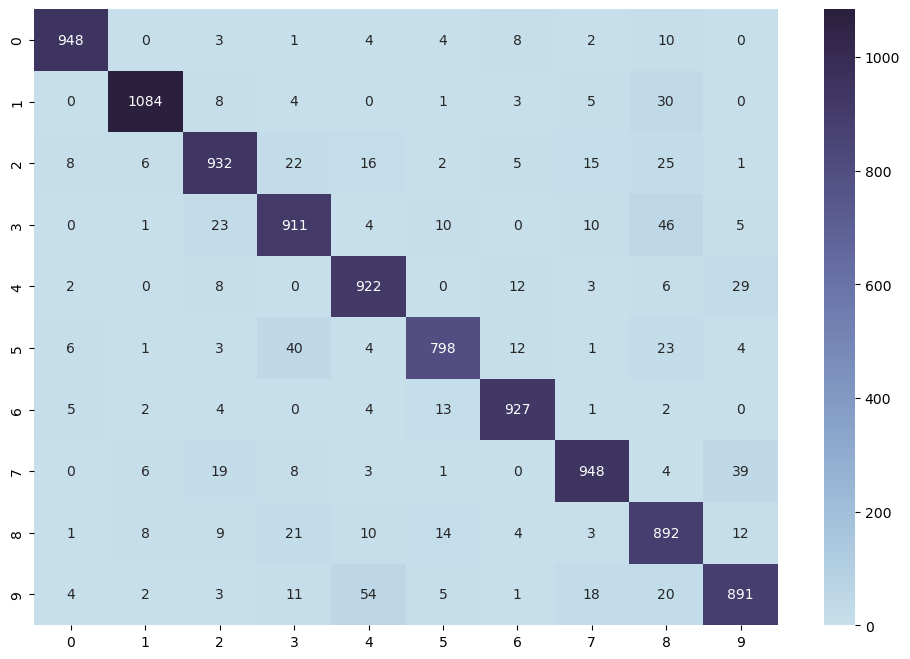

In [20]:
m = 'mnist_with_reg_hidden_32'
total_experts = 15
num_classes = 10
classes = range(10)
num_epochs = 20

w_sample_sim_same_range = [1e-6]
w_sample_sim_diff_range = [1e-6]                        

test_loader = testloader

plot_expert_usage(m, test_loader, 
                  w_sample_sim_same_range=w_sample_sim_same_range,
                  w_sample_sim_diff_range = w_sample_sim_diff_range,
                  total_experts=total_experts,num_classes=num_classes,
                 classes=classes, num_epochs=num_epochs, fig_path=fig_path,
                  model_path=model_path, device=device)